In [52]:
import networkx as nx
import sqlite3
import pandas as pd
import numpy as np
from graphviz import Source
import json
from nltk import ngrams


class WorkflowViz:
    def __init__(self,state_viz=None):
        self.state_idx = {}
        if state_viz != None:
            self.state_viz = state_viz
            self.refresh_state(state)
        else:
            self.state_viz = []
        self._relation = set()
        self.relation = []

    def add_state(self,step,step_id):
        self.state_viz.append(StateViz(step,[],step_id=step_id))
        self.refresh_state()

    def refresh_state(self):
        for i,x in enumerate(self.state_viz):
            self.state_idx[x.step] = i

    def get_state(self,state):
        return self.state_viz[self.state_idx[state]]

    def add_relation(self,input_step,input_col,output_step,output_col,relation):
        if (input_step,input_col,output_step,output_col,relation) not in self._relation:
            self._relation.add((input_step,input_col,output_step,output_col,relation))
            self.relation.append(RelationViz(input_step,input_col,output_step,output_col,relation))
        #self.get_state(input_step).get_data(input_col).next = self.get_state(output_step).get_data(output_col)
        #self.get_state(output_step).get_data(output_col).prev = self.get_state(input_step).get_data(input_col)

class RelationViz:
    def __init__(self,input_step,input_col,output_step,output_col,relation):
        #self.input_data = None
        #self.output_data = None
        #self.relation = None        
        self.add_relation(input_step,input_col,output_step,output_col,relation)

    def add_relation(self,input_step,input_col,output_step,output_col,relation):
        #self.input_data = self.get_state(input_step).get_data(input_col)
        #self.output_data = self.get_state(output_step).get_data(output_col)
        self.relation = relation
        self.input_step = input_step
        self.input_col = input_col
        self.output_step = output_step
        self.output_col = output_col
        

class StateViz:
    def __init__(self,step,data_list,step_id=None):
        self.step = step
        self.step_id = step_id
        self.col_idx = {}
        self.data_list = data_list
        self.refresh_index()
        #for i,x in enumerate(self.data_list):
        #    self.col_idx[x.col_id] = i
    
    def get_data(self,col_id):
        return self.data_list[self.col_idx[col_id]]

    def add_data(self,col_id,col_name,row=None,value=None,is_used=False):
        self.data_list.append(DataViz(col_id,col_name,row,value,is_used))

    def refresh_index(self):
        for i,x in enumerate(self.data_list):
            self.col_idx[x.col_id] = i

class DataViz:
    def __init__(self,col_id,col_name,row=None,value=None,is_used=False):
        self.col_id = col_id
        self.col_name = col_name
        self.row = row
        self.value = value
        self.next = set()
        self.prev = set()
        self.is_used = is_used


class ProvenanceExplorer:    
    def __init__(self,dbfile):
        self.dbfile = dbfile
        #self.conn = sqlite3.connect(self.dbfile)
        #self.cursor = self.conn.cursor()
        self.open_connection()

    def open_connection(self):
        self.conn = sqlite3.connect(self.dbfile)
        self.cursor = self.conn.cursor()
    
    def close_connection(self):
        self.conn.close()

    def get_removed_rows(self):
        return pd.read_sql_query("SELECT * FROM row_position where prev_row_pos_id=-1 and state_id>-1",self.conn)

    def get_number_of_state(self):
        return pd.read_sql_query("""
        SELECT max(state_id) as num_state FROM state 
        """, self.conn)

    def get_state_order(self):
        return pd.read_sql_query("""
        WITH RECURSIVE
        state_prev(ord,array_id,prev_state_id,state_id) AS
        (SELECT 0,array_id,prev_state_id,state_id from state where prev_state_id=-1
        UNION ALL
        select b.ord+1,a.array_id,a.prev_state_id,a.state_id  from state a,state_prev b
        where b.state_id=a.prev_state_id and b.array_id=a.array_id)
        select * from state_prev order by ord
        """,self.conn)

    def get_linear_recipe(self):
        #return pd.read_sql_query("""
        ##select * from state_command sc NATURAL JOIN state_detail sd NATURAL JOIN state
        #""",self.conn)

        #return pd.read_sql_query("""select * from state_command a,state_detail b, state c
        #where a.state_id = b.state_id
        #and a.state_id=c.state_id;
        #""",self.conn)

        return pd.read_sql_query("""
        select * from state_detail sd NATURAL JOIN state
        """,self.conn)

    

    def get_changes_each_state(self,state):
        if type(state) in (range,list):
            state=list(state)
            state = ",".join([str(x) for x in state ])
        return pd.read_sql_query("""
        SELECT (state_id-(select max(state_id)+1 from state s))*-1 as state,substr(command,33) as operation,col_id,count(1) as cell_changes FROM state 
        NATURAL JOIN content NATURAL JOIN value  NATURAL JOIN cell NATURAL JOIN state_command
        where state in ({state})
        group by state,col_id
        order by state asc        
        """.format(state=state), self.conn)

    def get_column_at_state(self,state):
        """
        col_at_state = list(self.cursor.execute("select * from col_each_state where state={}".format(state)))
        names = list(map(lambda x: x[0], self.cursor.description))   
        table_dict = {}
        for x in names:
            table_dict[x] = []
        for x in col_at_state:
            for i,y in enumerate(x):
                table_dict[names[i]].append(y)
        
        return pd.DataFrame(table_dict)
        """
        if type(state) in (range,list):
            state=list(state)
            state = ",".join([str(x) for x in state ])        
        
        #return pd.read_sql_query("select * from col_each_state where state={}".format(state), self.conn)
        return pd.read_sql_query("select * from col_each_state where state in ({state}) order by state".format(state=state), self.conn)

    def get_col_at_state_order(self,state):
        if type(state) in (range,list):
            state=list(state)
            state = ",".join([str(x) for x in state ])        

        return pd.read_sql_query("""
        SELECT * FROM (WITH RECURSIVE
        col_state_order(state,col_id,col_name,prev_col_id,level) AS (
        select state,col_id,col_name,prev_col_id,0 from col_each_state 
        where prev_col_id=-1
        UNION ALL
        SELECT a.state,a.col_id, a.col_name, a.prev_col_id,b.level+1 
        FROM col_each_state a, col_state_order b
        WHERE a.prev_col_id=b.col_id and a.state=b.state)
        SELECT state,col_id,col_name,prev_col_id,level from col_state_order
        ) where state in ({state})
        order by state,level
        """.format(state=state)
        , self.conn)

    def get_step_to_state(self,step):
        max_state = self.get_number_of_state().num_state.values[0]
        return max_state - step

    def get_state_to_step(self,state):
        max_state = self.get_number_of_state().num_state.values[0]
        return (state - max_state) * -1
        #{state}-(select max(state_id) from state s))*-1  

    def get_row_at_state(self,state):
        return pd.read_sql_query("select * from row_at_state where state={}".format(state), self.conn)

    def get_row_at_state(self,state):
        return pd.read_sql_query("select * from row_at_state where state={}".format(state), self.conn)

    def get_row_at_state_order(self,state):
        '''
        return pd.read_sql_query("""
        SELECT * FROM (WITH RECURSIVE
        row_state_order(state,row_id,prev_row_id,level) AS (
        select state,row_id,prev_row_id,0 from row_at_state 
        where prev_row_id=-1
        and state={}
        UNION ALL
        SELECT a.state,a.row_id,a.prev_row_id,b.level+1 
        FROM row_at_state a, row_state_order b
        WHERE a.prev_row_id=b.row_id and a.state=b.state)
        SELECT state,row_id,prev_row_id,level from row_state_order
        order by state asc)
        """.format(state)
        , self.conn)
        '''
        return pd.read_sql_query("""
        select distinct * from (
        WITH RECURSIVE
        row_state_order(state,state_id,row_id,prev_row_id,level) AS (
        select ({state}-(select max(state_id) from state s))*-1 as state
        ,{state} as state_id,rp.row_id,rp.prev_row_id,0 from row_position rp 
        where rp.state_id<={state} and
        rp.row_pos_id not IN 
        (
        select prev_row_pos_id from row_position rp2 
        where rp2.state_id<={state}
        and prev_row_pos_id>-1
        )
        and prev_row_id=-1
        UNION ALL
        SELECT a.state,a.state_id,a.row_id,a.prev_row_id,b.level+1 
        FROM (select ({state}-(select max(state_id) from state s))*-1 as state
        ,{state} as state_id,rp.row_pos_id,rp.row_id,rp.prev_row_id,rp.prev_row_pos_id from row_position rp 
        where rp.state_id<={state} and
        rp.row_pos_id not IN 
        (
        select prev_row_pos_id from row_position rp2 
        where rp2.state_id<={state}
        and prev_row_pos_id>-1
        )) a, row_state_order b
        WHERE a.prev_row_id=b.row_id and a.state_id=b.state_id)
        SELECT state,state_id,row_id,prev_row_id,level from row_state_order
        )        
        """.format(state=state),self.conn)

    def get_row_logic_to_idx(self,state,row):
        row_logic = self.get_row_at_state_order(state)
        return row_logic.iloc[row].row_id

    def get_row_idx_to_logic(self,state,row):
        row_idx = self.get_row_at_state_order(state)
        return row_idx.row_id.tolist().index(row)        

    def get_col_logic_to_idx(self,state,col):
        col_logic = self.get_col_at_state_order(state)
        #print(col_logic)
        return col_logic.iloc[col].col_id        
        #return col_logic.col_id.tolist().index(col)
    
    def get_col_idx_to_logic(self,state,col):
        col_idx = self.get_col_at_state_order(state)
        return col_idx.col_id.tolist().index(col) 

    def get_values_at_state(self,state):
        return pd.read_sql_query("""
        select ({state}-(select max(state_id) from state s))*-1 as state
        ,{state} as state_id,a.content_id,a.prev_content_id,c.value_text,d.row_id,d.col_id 
        from content a
        NATURAL JOIN value c
        NATURAL JOIN cell d
        where a.state_id<={state}
        and a.content_id not in
        (
        select a.prev_content_id from content a
        where a.state_id<={state}
        )
        """.format(state=state), self.conn)

    def get_snapshot_at_state(self,state):
        row_order = self.get_row_at_state_order(state)
        col_order = self.get_col_at_state_order(state)
        #print(col_order)
        values = self.get_values_at_state(state)

        max_row_id = row_order.row_id.max()
        max_col_id = col_order.col_id.max()
        new_arr = np.empty((max_row_id+1,max_col_id+1),dtype=object)
        #print(new_arr.shape)
        for x in values.to_records():
            try:
                new_arr[x.row_id,x.col_id] = x.value_text
            except:
                continue
        
        col_sort = sorted(col_order[["level","col_id","col_name"]].values.tolist(),key=lambda x:x[0])
        row_sort = sorted(row_order[["level","row_id"]].values.tolist(),key=lambda x:x[0])
        
        #print(col_names,row_names)
        snapshot_pd = pd.DataFrame(new_arr)
        #snapshot_pd.columns = col_names
        snapshot_pd = snapshot_pd.iloc[[x[1] for x in row_sort],[x[1] for x in col_sort]]
        snapshot_pd.columns = [x[2] for x in col_sort]
        return snapshot_pd

    def get_cell_history(self,row,col,is_id=True):
        # if it's a logical id, get the id
        if not is_id:
            col_id = self.get_col_logic_to_idx(state,col)
            row_id = self.get_row_logic_to_idx(state,row)
        else:
            col_id = col
            row_id = row
        
        return pd.read_sql_query("""
        select * from value_at_state a  where row_id={} and col_id={} order by state
        """.format(row_id,col_id), self.conn)

    def get_state_dependency(self,state):
        if type(state) in (range,list):
            state=list(state)
            state = ",".join([str(x) for x in state ])        

        return pd.read_sql_query("""
        select distinct (a.state_id-(select max(state_id)+1 from state s))*-1 as state,substr(c.command,33) command,(b.state_id-(select max(state_id)+1 from state s))*-1 as dep_state,substr(d.command,33) as dep_command,a.input_column,a.output_column
        from col_dependency a,col_dep_state b,state_command c,state_command d
        where a.input_column = b.prev_input_column
        and a.state_id>-1
        and a.state_id<=b.state_id
        and a.state_id=c.state_id 
        and b.state_id=d.state_id
        and state in ({state})
        order by state,dep_state asc;       
         """.format(state=state), self.conn)


    def get_column_dependency(self,col_id):        
        return pd.read_sql_query("""
        select distinct (a.state_id-(select max(state_id)+1 from state s))*-1 as state,substr(c.command,33) command,substr(d.command,33) as dep_command,a.input_column,a.output_column
        from col_dependency a,state_command c,state_command d
        where 
        a.state_id>-1
        and a.state_id=c.state_id 
        and d.state_id=a.state_id
        and output_column={col_id}
        order by state asc;       
         """.format(col_id=col_id), self.conn)

    def get_all_column_dependency(self):        
        return pd.read_sql_query("""
        select distinct (a.state_id-(select max(state_id)+1 from state s))*-1 as state,substr(c.command,33) command,substr(d.command,33) as dep_command,a.input_column,a.output_column,a.state_id
        from col_dependency a,state_command c,state_command d
        where 
        a.state_id>-1
        and a.state_id=c.state_id 
        and d.state_id=a.state_id
        order by state asc;       
         """, self.conn)        

    def get_all_state_command(self):        
        return pd.read_sql_query("""
        select * from state_command NATURAL JOIN state_detail
         """, self.conn)         

    def lineage_viz(self,row,col,step=-1):
        if step>-1:
            #col = self.get_col_logic_to_idx(self.get_step_to_state(step),col)
            #row = self.get_row_logic_to_idx(self.get_step_to_state(step),row)
            col = self.get_col_logic_to_idx(step,col)
            row = self.get_row_logic_to_idx(step,row)
        col_state_dep = self.get_column_dependency(col).state.tolist()
        state_dep = self.get_state_dependency(col_state_dep)
        dep_state = state_dep.dep_state.unique()
        all_dep = self.get_all_column_dependency()
        state_dep = all_dep[all_dep.state.isin(dep_state)]
        #print(dep_state)        
        #xx = state_dep[state_dep.command!=]state_dep[["input_column","output_column"]].values.flatten()
        #xx = state_dep[state_dep.command!="RowReorderChange"][["input_column","output_column"]].values.flatten()
        xx = state_dep[state_dep.command!="ColumnMoveChange"][["input_column","output_column"]].values.flatten()
        #print(xx)
        xx_col = {x:x for x in xx}.keys()
        #print(xx_col)
        xx_hist = {}
        for x in xx_col:
            xx_hist[x] = self.get_cell_history(row,x)
        
        dep_state = set(dep_state)
        dep_state.add(0)
        dep_state = list(set(dep_state))
        dep_state = sorted(dep_state)
        #first_state = max(dep_state)
        #if first_state<self.get_number_of_state().num_state.values[0]:
        #    dep_state.append(self.get_number_of_state().num_state.values[0])
        print(dep_state)

        output_trace = []
        for i,x in enumerate(dep_state[1:]):
            dep_x = all_dep[all_dep.state==x]
            print(x,dep_x)
            #print(dep_x)
            for y in dep_x[["input_column","output_column"]].to_records():
                if y.input_column in xx_hist.keys():
                    xx_input = xx_hist[y.input_column]
                if y.output_column in xx_hist.keys():
                    xx_output = xx_hist[y.output_column]
                #print(dep_state[i-1],x)
                #print("input",xx_input[xx_input.state==dep_state[(i+1)-1]])
                #print("output",xx_output[xx_output.state==x])
                output_trace.append((dep_state[(i+1)-1],x,y.input_column,y.output_column,xx_input[xx_input.state==dep_state[(i+1)-1]],xx_output[xx_output.state==x]))
                #print(dep_x)
        
        is_processed = []

        s_ah = {}
        for s in output_trace:
            try:
                s_ah[s[0]]
            except:
                s_ah[s[0]] = []
            s_ah[s[0]].append(s)
            if s[0]>0:
                try:
                    s_ah[s[0]-1]
                except:
                    s_ah[s[0]-1] = []
                s_ah[s[0]-1].append(s)
            
        s0_s1_rel = []

        wf = WorkflowViz()

        for s in output_trace:
            s0 = s[0]
            s1 = s[1]
            row_logic_s0 = self.get_row_at_state_order(s0)
            row_logic_s1 = self.get_row_at_state_order(s1)
            
            if s0 not in is_processed:
                wf.add_state(s0,step_id=self.get_state_to_step(s0))            

                for x in self.get_col_at_state_order(s0).to_records():
                    if x.col_id not in xx_col:
                        wf.get_state(s0).add_data(x.col_id,x.col_name,row=row_logic_s0[row_logic_s0.row_id==row].level.values[0],value=None)
                    else:
                        xx_tt = xx_hist[x.col_id]
                        xx_tt = xx_tt[xx_tt.state==s0]                     
                        #print(xx_tt)   
                        wf.get_state(s0).add_data(x.col_id,x.col_name,row=row_logic_s0[row_logic_s0.row_id==row].level.values[0],value=xx_tt.value_text.values[0],is_used=True)
                is_processed.append(s0)

            if s1 not in is_processed:
                wf.add_state(s1,step_id=self.get_state_to_step(s1))            

                for x in self.get_col_at_state_order(s1).to_records():
                    if x.col_id not in xx_col:
                        wf.get_state(s1).add_data(x.col_id,x.col_name,row=row_logic_s1[row_logic_s1.row_id==row].level.values[0],value=None)
                    else:
                        xx_tt = xx_hist[x.col_id]
                        xx_tt = xx_tt[xx_tt.state==s1]  
                        #print(xx_tt)   
                        wf.get_state(s1).add_data(x.col_id,x.col_name,row=row_logic_s1[row_logic_s1.row_id==row].level.values[0],value=xx_tt.value_text.values[0],is_used=True)
                is_processed.append(s1)
            
            wf.add_relation(s0,s[2],s1,s[3],all_dep[all_dep.state==s1].command.values[0]) 
            wf.add_relation(s0,col,s1,col,all_dep[all_dep.state==s1].command.values[0])
            #wf.add_relation(self,input_step,input_col,output_step,output_col,relation)

            '''
            s_port+="""
            struct{}:port{}o -> struct{}:port{}i [ label="{}" ];
            """.format(s0,s[2],s1,s[3],all_dep[all_dep.state==s1].command.values[0])
            s0_s1_rel.append((s0,s[2],s1,s[3]))

            #print(col,s0_ex_col,s1_ex_col)

            if s0_ex_col and s1_ex_col and ((s0,col,s1,col) not in s0_s1_rel):
                s_port+="""
                struct{}:port{}o -> struct{}:port{}i [ label="{}" ];
                """.format(s0,col,s1,col,all_dep[all_dep.state==s1].command.values[0])
                s0_s1_rel.append((s0,col,s1,col))            
            '''
        return wf


    def         get_cell_lineage(self,row,col,step=-1):
        if step>-1:
            #col = self.get_col_logic_to_idx(self.get_step_to_state(step),col)
            #row = self.get_row_logic_to_idx(self.get_step_to_state(step),row)
            col = self.get_col_logic_to_idx(step,col)
            row = self.get_row_logic_to_idx(step,row)
        col_state_dep = self.get_column_dependency(col).state.tolist()
        state_dep = self.get_state_dependency(col_state_dep)
        dep_state = state_dep.dep_state.unique()
        all_dep = self.get_all_column_dependency()
        state_dep = all_dep[all_dep.state.isin(dep_state)]
        #print(dep_state)        
        #xx = state_dep[state_dep.command!=]state_dep[["input_column","output_column"]].values.flatten()
        #xx = state_dep[state_dep.command!="RowReorderChange"][["input_column","output_column"]].values.flatten()
        xx = state_dep[state_dep.command!="ColumnMoveChange"][["input_column","output_column"]].values.flatten()
        #print(xx)
        xx_col = {x:x for x in xx}.keys()
        #print(xx_col)
        xx_hist = {}
        for x in xx_col:
            xx_hist[x] = self.get_cell_history(row,x)
        
        dep_state = set(dep_state)
        dep_state.add(0)
        dep_state = list(set(dep_state))
        dep_state = sorted(dep_state)
        #print(dep_state)

        output_trace = []
        for i,x in enumerate(dep_state[1:]):
            dep_x = all_dep[all_dep.state==x]
            #print(dep_x)
            for y in dep_x[["input_column","output_column"]].to_records():
                xx_input = xx_hist[y.input_column]
                xx_output = xx_hist[y.output_column]
                #print(dep_state[i-1],x)
                #print("input",xx_input[xx_input.state==dep_state[(i+1)-1]])
                #print("output",xx_output[xx_output.state==x])
                output_trace.append((dep_state[(i+1)-1],x,y.input_column,y.output_column,xx_input[xx_input.state==dep_state[(i+1)-1]],xx_output[xx_output.state==x]))
            #print(dep_x)
        
        from graphviz import Source
        temp = """
        digraph {
        rankdir=TB;
        node [ shape=record ];
        splines="line";
        """
        s_coll=""
        s_port=""
        is_processed = []

        s_ah = {}
        for s in output_trace:
            try:
                s_ah[s[0]]
            except:
                s_ah[s[0]] = []
            s_ah[s[0]].append(s)
            if s[0]>0:
                try:
                    s_ah[s[0]-1]
                except:
                    s_ah[s[0]-1] = []
                s_ah[s[0]-1].append(s)

                
        #print(s_ah)

        s0_s1_rel = []

        for s in output_trace:
            s0 = s[0]
            s1 = s[1]
            row_logic_s0 = self.get_row_at_state_order(s0)
            row_logic_s1 = self.get_row_at_state_order(s1)
            
            s0_ex_col = False
            s1_ex_col =False

            if col in self.get_col_at_state_order(s0).col_id.values:
                s0_ex_col = True
            
            if col in self.get_col_at_state_order(s1).col_id.values:
                s1_ex_col = True

            if s0 not in is_processed:
                col_port = []
                for x in self.get_col_at_state_order(s0).to_records():
                    is_ss = False
                    for ss in s_ah[s0]:
                        if (x.col_id==col):
                            xx_col = xx_hist[col]
                            #print(xx_col)
                            #xx_col = xx_col[xx_col.state_id==self.get_state_to_step(ss[0])]
                            xx_col = xx_col[xx_col.state==s0]
                            #print(xx_col)
                            xx = "{{<port{col_id}i>{col_name}|row:{row}|<port{col_id}o>{value}}}".format(col_id=x.col_id,col_name=x.col_name,value=xx_col.value_text.values[0],row=row_logic_s1[row_logic_s1.row_id==row].level.values[0])
                            is_ss = True
                        elif (x.col_id==ss[4].col_id.values[0]):
                            xx = "{{<port{col_id}i>{col_name}|row:{row}|<port{col_id}o>{value}}}".format(col_id=x.col_id,col_name=x.col_name,value=ss[4].value_text.values[0],row=row_logic_s0[row_logic_s0.row_id==row].level.values[0])
                            #xx = "{{<port{col_id}>{col_name}|row:{row}|<port{col_id}>{value}}}".format(col_id=x.col_id,col_name=x.col_name,value=ss[4].value_text.values[0],row=row_logic_s0.iloc[row].row_id)
                            is_ss = True

                    #print(x.col_id)

                    if not is_ss:
                        #xx = "{{<port{col_id}>{col_name}}}".format(col_id=x.col_id,col_name=x.col_name)
                        xx = "{{<port{}i>{}|<port{}o>}}".format(x.col_id,x.col_name,x.col_id)
                        #xx = "<port{}>{}\n{}".format(x.col_id,x.col_name,s[4].value_text.values[0])
                    col_port.append(xx)

                s_coll+="""
                subgraph cluster_{step} {{
                    label="step {step}";

                    struct{s_num}[
                        label = "{s_label}";
                    ];
                }}
                """.format(step=s[0],s_num=s0,s_label="|".join(col_port))
                is_processed.append(s0)

            if s1 not in is_processed:
                col_port = []
                for x in self.get_col_at_state_order(s1).to_records():
                    is_ss = False
                    for ss in s_ah[s0]:
                        if (x.col_id==col):
                            xx_col = xx_hist[col]
                            #xx_col = xx_col[xx_col.state_id==self.get_state_to_step(ss[0])]
                            xx_col = xx_col[xx_col.state==s1]
                            #print(xx_col)
                            xx = "{{<port{col_id}i>{col_name}|row:{row}|<port{col_id}o>{value}}}".format(col_id=x.col_id,col_name=x.col_name,value=xx_col.value_text.values[0],row=row_logic_s1[row_logic_s1.row_id==row].level.values[0])
                            is_ss = True
                        elif (x.col_id==ss[5].col_id.values[0]):
                            #xx = "{{<port{col_id}>{col_name}|row:{row}|<port{col_id}>{value}}}".format(col_id=x.col_id,col_name=x.col_name,value=ss[5].value_text.values[0],row=row_logic_s1.iloc[row].row_id)                                         
                            xx = "{{<port{col_id}i>{col_name}|row:{row}|<port{col_id}o>{value}}}".format(col_id=x.col_id,col_name=x.col_name,value=ss[5].value_text.values[0],row=row_logic_s1[row_logic_s1.row_id==row].level.values[0])
                            is_ss = True
                            
                            #xx = "{{<port{}i>{}|<port{}o>{}}}".format(x.col_id,x.col_name,x.col_id,s[5].value_text.values[0])
                            #xx = "<port{}>{}\n{}".format(x.col_id,x.col_name,s[5].value_text.values[0])

                    #print(x.col_id)
                    if x.col_id == col:
                        s1_ex_col = True

                    if not is_ss:
                        #xx = "{{<port{col_id}>{col_name}}}".format(col_id=x.col_id,col_name=x.col_name)
                        xx = "{{<port{}i>{}|<port{}o>}}".format(x.col_id,x.col_name,x.col_id)                    

                    col_port.append(xx)
                '''
                for x in orpe.get_col_at_state_order(s1).to_records():
                    xx = "<port{}>".format(x.col_id)+x.col_name
                    col_port.append(xx)
                '''
                s_coll+="""
                subgraph cluster_{step} {{
                    label="step {step}";
                    struct{s_num}[
                        label = "{s_label}";
                    ];
                }}
                """.format(step=s1,s_num=s1,s_label="|".join(col_port))
                is_processed.append(s1)
            
            
            s_port+="""
            struct{}:port{}o -> struct{}:port{}i [ label="{}" ];
            """.format(s0,s[2],s1,s[3],all_dep[all_dep.state==s1].command.values[0])
            s0_s1_rel.append((s0,s[2],s1,s[3]))

            #print(col,s0_ex_col,s1_ex_col)

            
            if s0_ex_col and s1_ex_col and ((s0,col,s1,col) not in s0_s1_rel):
                #s_port+="""
                #struct{}:port{}o -> struct{}:port{}i [ label="{}" ];
                #""".format(s0,col,s1,col,all_dep[all_dep.state==s1].command.values[0])
                s_port+="""
                struct{}:port{}o -> struct{}:port{}i [ label="{}" ];
                """.format(s0,col,s1,col,"")
                s0_s1_rel.append((s0,col,s1,col))

            #print(s0_s1_rel)

            '''
            s_port+="""
            struct{source} -> struct{target} [
                tailport = port{porto}
                headport = port{porti}
                label = {label}
            ];
            """.format(source=s0,target=s1,porto=s[2],porti=s[3],label=all_dep[all_dep.state==s1].command.values[0])
            '''

            #if s>0:
            #    s_port+="""
            #    struct{}:port1 -> struct{}:port2 [ label="xyz" ];
            #    """.format(s-1,s)

        temp+=s_coll
        temp+="""
        {}
        }}
        """.format(s_port)
        s = Source(temp)
        #s.view()
        #s
        return output_trace,s

    def reuse_recipe(self,col_id):
        state_dep = self.get_state_dependency(self.get_column_dependency(col_id).state.tolist())
        #print(",".join([str(x) for x in state_dep.dep_state.unique()]))
        state_det = pd.read_sql("select * from state_detail where state_id in ({})".format(",".join([str(self.get_step_to_state(x)+1) for x in state_dep.dep_state.unique()])),self.conn)
        state_det = {x.state_id:json.loads(x.detail)["operation"] for x in state_det[["detail","state_id"]].to_records()}
        #print(state_det)
        state_list = []
        state_ids = []
        for x in self.get_state_order().sort_values("ord",ascending=False).to_records():
            try:
                #print(state_det[x.state_id])
                state_list.append(state_det[x.state_id])
                state_ids.append(x.state_id)
            except:
                pass
        
        #state_list = list(filter(lambda x: x!=None,[json.loads(x)["operation"] for x in state_det.detail]))
        return state_list,state_ids


    def gv_template(self,stack_process,process=None):

        nodes_def = """
        digraph "[stackcollapse]" {
        node [style=filled fillcolor="#f8f8f8"]
        """

        edge_def = ""
                
        # workflow template gv format

        header = """
        /* Start of top-level graph */
        digraph Workflow {
        rankdir=TB

        /* Start of double cluster for drawing box around nodes in workflow */
        subgraph cluster_workflow_box_outer { label=""; penwidth=0
        subgraph cluster_workflow_box_inner { label=""; penwidth=0
        """

        single_process = """
        /* Style for nodes representing atomic programs in workflow */
        node[shape=box style=filled fillcolor="#CCFFCC" peripheries=1 fontname=Helvetica]

        /* Nodes representing atomic programs in workflow */
        """
        #state_4 [shape=record rankdir=LR label="{<f0> step 4 (to_date) | grel\:value.replace(/\\/i,'') | 16492 cells changed}"];


        group_process_nodes = """
        node[shape=box style=filled fillcolor="#CCCCFF" peripheries=1 fontname=Helvetica]
        """
        #state_5 [shape=record rankdir=LR label="{<f0> state_5 |<f1> core/mass-edit\nclustering\ngroup clustering 4 processes}"];

        freq_pattern_nodes = """
        node[shape=box style=filled fillcolor="#CCFFFF" peripheries=1 fontname=Helvetica]
        """
        #state_5 [shape=record rankdir=LR label="{<f0> state_5 |<f1> core/mass-edit\nclustering\ngroup clustering 4 processes}"];

        column_nodes = """
        /* Style for nodes representing non-parameter data channels in workflow */
        node[shape=box style="rounded,filled" fillcolor="#FFFFCC" peripheries=1 fontname=Helvetica]

        /* Nodes for non-parameter data channels in workflow */
        """
        #"col12_0-date" [shape=record rankdir=LR label="{<f0> date_0 }"]

        parameters_nodes = """
        /* Style for nodes representing parameter channels in workflow */
        node[shape=box style="rounded,filled" fillcolor="#FCFCFC" peripheries=1 fontname=Helvetica]

        /* Nodes representing parameter channels in workflow */
        """

        edges = """
        /* Edges representing connections between programs and channels */
        """
        #"col12_0-date" -> state_4


        footer = """
        /* End of double cluster for drawing box around nodes in workflow */
        }}

        /* End of top-level graph */
        }
        """

        isinput = set()

        process_nodes = []
        data_nodes_in = set()
        data_nodes_out = set()

        parallel_graph = nx.DiGraph()

        if process==None:
            process = stack_process

        #for key,val in process.items():
        #for key,val in collapsed_process.items():
        #for key,val in freq_pattern_process.items():
        #for key,val in simple_process.items():
        for key,val in stack_process.items():
            try:
                # remove single process
                val["input"]
            except:
                continue 

            try:
                group_process = val["group_process"]
                step_name = "Step {}".format(key.split("_")[-1])
            except:
                group_process = []
                step_name = "Step {}".format(key.split("_")[-1])

            try:
                freq_pattern = val["freq_pattern"]
                step_name = "Step {}".format(key.split("_")[-1])
            except:
                freq_pattern = []
                step_name = "Step {}".format(key.split("_")[-1])

            try:
                json_recipe = val["operation"]
            except:
                json_recipe = {}
                json_recipe["op"] = "single-operation"
                val["op"] = "single-operation"

            detail = ""

            #if (len(group_process)==0) & (len(freq_pattern)==0) & () 

            #if len(freq_pattern_process)>0:
                
            if len(group_process)==0:
                if len(freq_pattern)>0:
                    for y in freq_pattern[1]:
                        pname = y[0][2]
                        internal_group = [y[0]] + y[2]
                        detail += "| {}{} ".format("group-" if len(internal_group)>1 else "",pname)
                        # if freq_pattern is cluster
                        if len(internal_group)>0:                    
                            detail+=" ({}, {})".format(internal_group[0][0],len(internal_group))

                            for x in internal_group:
                                temp_val = process[x[0]]
                                try:
                                    json_recipe = temp_val["operation"]
                                except:
                                    json_recipe = {}
                                    json_recipe["op"] = "single-operation"
                                    temp_val["op"] = "single-operation"
                                                        
                                """
                                if temp_val["op"]=="core/mass-edit":
                                    cells_variance = sum([len(x["from"]) for x in json_recipe["edits"]])
                                    cells_affected = int(temp_val["desc"].split("edit")[-1].split("cells")[0])
                                    detail+="| {} =\> {}, {} cells".format(cells_variance,len(json_recipe["edits"]),cells_affected)
                                else:
                                    try:
                                        cells_affected = int(temp_val["desc"].split("Text transform on")[-1].split("cells")[0])        
                                        detail += "| {}, {} changed".format(json_recipe["expression"].replace('"','\\"'),cells_affected)
                                    except:
                                        pass
                                    #break
                                """
                        else:                    
                            temp_val = process[y[0][0]]
                            try:
                                json_recipe = temp_val["operation"]
                            except:
                                json_recipe = {}
                                json_recipe["op"] = "single-operation"   
                                temp_val["op"] = "single-operation"
                                    
                            if temp_val["op"]=="core/mass-edit":
                                cells_variance = sum([len(x["from"]) for x in json_recipe["edits"]])
                                cells_affected = int(temp_val["desc"].split("edit")[-1].split("cells")[0])
                                detail+="| {} =\> {}, {} cells".format(cells_variance,len(json_recipe["edits"]),cells_affected)
                            else:
                                try:
                                    cells_affected = int(temp_val["desc"].split("Text transform on")[-1].split("cells")[0])        
                                    detail += "| {}, {} changed".format(json_recipe["expression"].replace('"','\\"'),cells_affected)
                                except:
                                    pass
                                    
                else:
                    if val["op"]!="core/mass-edit":
                        try:
                            detail += "| {} ".format(json_recipe["expression"].replace('"','\\"'))
                        except:
                            pass
                    else:
                        """
                        for x in json_recipe["edits"]:
                            detail+=",".join(x["from"])[:25]+" ({})".format(len(x["from"]))+" => "+x["to"][:25]+"\n"
                        """
                        cells_variance = sum([len(x["from"]) for x in json_recipe["edits"]])
                        
                        detail+="| {} =\> {} clusters".format(cells_variance,len(json_recipe["edits"]))
            else:
                for x in group_process:
                    temp_val = process[x[0]]
                    try:
                        json_recipe = temp_val["operation"]
                    except:
                        json_recipe = {}
                        json_recipe["op"] = "single-operation"
                        val["op"] = "single-operation"
                    if temp_val["op"]=="core/mass-edit":
                        cells_variance = sum([len(x["from"]) for x in json_recipe["edits"]])
                        cells_affected = int(temp_val["desc"].split("edit")[-1].split("cells")[0])
                        detail+="| {} =\> {}, {} cells".format(cells_variance,len(json_recipe["edits"]),cells_affected)
                    else:
                        try:
                            cells_affected = int(temp_val["desc"].split("Text transform on")[-1].split("cells")[0])        
                            detail += "| {}, {} changed".format(json_recipe["expression"].replace('"','\\"'),cells_affected)
                        except:
                            pass
            
            description = ""
            if (len(group_process)==0) & (len(freq_pattern)==0):
                if val["op"]=="core/mass-edit":
                    cells_affected = int(val["desc"].split("edit")[-1].split("cells")[0])
                    description+="| {} cells affected".format(cells_affected)
                elif val["op"]=="core/text-transform":
                    cells_affected = int(val["desc"].split("Text transform on")[-1].split("cells")[0])        
                    description+="| {} cells changed".format(cells_affected)

            if len(freq_pattern)>0:
                freq_pattern_nodes+='''
                {state_id} [shape=record rankdir=LR label="{{<f0> {step_name} ({function_name}) {detail} {description}}}"];
                '''.format(state_id=key,step_name=step_name,function_name=freq_pattern[0],detail=detail,description=description)    
            elif len(group_process)>0:
                group_process_nodes+='''
                {state_id} [shape=record rankdir=LR label="{{<f0> {step_name} ({is_group}{function_name}) {detail} {description}}}"];
                '''.format(state_id=key,step_name=step_name,is_group="group-" if len(group_process)>0 else "",function_name=val["annotation"],detail=detail,description=description)
            else:  
                single_process+='''
                {state_id} [shape=record rankdir=LR label="{{<f0> {step_name} ({is_group}{function_name}) {detail} {description}}}"];
                '''.format(state_id=key,step_name=step_name,is_group="group-" if len(group_process)>0 else "",function_name=val["annotation"],detail=detail,description=description)
                #print(single_process)

            

            temp_name = "{state}\\n".format(state=key)
            temp_desc = ""
            try:
                temp_desc += val["op"] +"\\n" + val["annotation"] +"\\n"
            except:
                pass
            temp_desc += val["desc"]
            nodes_def+="""
                {x} [label="{label}" id="{id}" fontsize=18 shape=box tooltip="{tt}" color="#b20400" fillcolor="#edd6d5"]
            """.format(x=key,label=temp_name+temp_desc.replace('"',"'"),id=key,tt="")
                
            colkey = key.split("_")[-1]
            parallel_graph.add_node(key,label=temp_desc,type="state",t_id=colkey)
            try:
                val["input"]
            except:
                continue

            temp_process_yw = """
            #@begin {key} #@desc {desc} 
            """.format(key=key,desc=temp_desc.replace('"',"'"))
            #format(key=key,desc=key)
            
            
            col_state = self.get_column_at_state(int(key.split("_")[-1]))
            
            prev_col_state = self.get_column_at_state(int(key.split("_")[-1])-1)
            
            #if int(key.split("_")[-1])==25:
            #    print("cstate",key,col_state)
            #    print("pstate",key,prev_col_state)

            
            for valinput in val["input"]:
                try:
                    colkey = valinput.split("_")[0].split("col")[-1]
                    #print(colkey)
                    colname = prev_col_state[prev_col_state.col_id==int(colkey)].col_name.values[0]
                    #print("colname-x",colname)
                except:
                    print(colkey)
                    colname = colkey 
                if valinput not in isinput:            
                    #prev_col_state = orpe.get_column_at_state(int(key.split("_")[-1])+1)            
                    nodes_def+="""
                        {x} [label="{label}" id="{id}" fontsize=18 shape=oval tooltip="" color="#b20400" fillcolor="#edd6d5"]
                    """.format(x=valinput,label=valinput.replace('"',"'")+"\\n"+colname,id=key,tt="")
                    isinput.add(valinput)
                    
                    parallel_graph.add_node(valinput,label=valinput,type="col",t_id=colkey)
                
                #print(col_state)

                edge_def+="""
                    {input} -> {output} [label="{data}" weight=14 color="#b26e37" tooltip="" labeltooltip=""]    
                """.format(input=valinput,output=key,data="")

                parallel_graph.add_edge(valinput,key)
                data_nodes_in.add("{key}-{colname}".format(key=valinput,colname=colname).replace(" ","_"))
                temp_process_yw += """
                #@in """+ """{key}-{colname}
                    """.format(key=valinput,colname=colname).replace(" ","_")
                
                col_label = "{}_{}".format(colname,valinput.split("_")[-1]) 
                column_nodes+="""
                "{node_name}" [shape=record rankdir=LR label="{{<f0> {label} }}"]
                """.format(node_name=valinput,label=col_label)

                edges+="""
                "{}" -> {}
                """.format(valinput,key)

            for valoutput in val["output"]:
                try:
                    colkey = valoutput.split("_")[0].split("col")[-1]
                    #print(colkey)
                    colname = col_state[col_state.col_id==int(colkey)].col_name.values[0]
                    #print(colname)
                except:
                    #print(colkey)
                    colname = "_".join(valoutput.split("_")[:-1])
                    
                if valoutput not in isinput:
                    nodes_def+="""
                        {x} [label="{label}" id="{id}" fontsize=18 shape=oval tooltip="" color="#b20400" fillcolor="#edd6d5"]
                    """.format(x=valoutput,label=valoutput.replace('"',"'")+"\\n"+colname,id=key,tt="")
                    isinput.add(valoutput)

                    parallel_graph.add_node(valoutput,label=valoutput,type="col",t_id=colkey)

                #print(col_state)
                
                edge_def+="""
                    {input} -> {output} [label="{data}" weight=14 color="#b26e37" tooltip="" labeltooltip=""]    
                """.format(input=key,output=valoutput,data="")

                parallel_graph.add_edge(key,valoutput)
                data_nodes_out.add("{key}-{colname}".format(key=valoutput,colname=colname).replace(" ","_"))
                temp_process_yw += """
                #@out """+"""{key}-{colname}
                """.format(key=valoutput,colname=colname).replace(" ","_")

                col_label = "{}_{}".format(colname,valoutput.split("_")[-1]) 
                column_nodes+="""
                "{node_name}" [shape=record rankdir=LR label="{{<f0> {label} }}"]
                """.format(node_name=valoutput,label=col_label)

                edges+="""
                "{}" -> {}
                """.format(key,valoutput)

            temp_process_yw += """
            #@end {key}     in
            """.format(key=key)
            process_nodes.append(temp_process_yw)
        
        return process_nodes,parallel_graph 


    def parallel_workflow(self):
        linear_recipe = self.get_linear_recipe()

        col_dependency = self.get_all_column_dependency()
        state_order = self.get_state_order()
        state_col_dep = col_dependency.merge(state_order)

        process = {}
        col_counter = {}
        max_state = self.get_number_of_state()

        for x in linear_recipe.sort_values("state_id",ascending=False).to_records():
            sid = x.state_id    
            #print(sid)


            xx = json.loads(x.detail)

            real_state = max_state.values[0][0]-x.state_id    
            prev_state = max_state.values[0][0]-x.prev_state_id
            #print(x.prev_state_id)

            if real_state == 0:
                input_name = "tableoriginal"
            else:
                input_name = "table{}".format(real_state) 

            process["state_{}".format(prev_state)] = {}
            try:
                state_pd = state_col_dep.groupby("state_id").get_group(sid)
                process["state_{}".format(prev_state)]["input"] = []
                process["state_{}".format(prev_state)]["output"] = []

                icol = set()
                ocol = set()
                for y in state_pd.to_records():
                    colname = "col{}".format(y.input_column)
                    if colname not in icol:
                        try:
                            col_counter[colname] #+= 1
                        except:
                            col_counter[colname] = 0                                                
                        process["state_{}".format(prev_state)]["input"].append("{colname}_{counter}".format(colname=colname,counter=col_counter[colname]))
                        icol.add(colname)
                    
                    if y.output_column==-2:
                        colname = "col_removed"
                    else:
                        colname = "col{}".format(y.output_column)
                    if colname not in ocol:
                        try:
                            col_counter[colname] += 1
                        except:
                            col_counter[colname] = 0     
                        process["state_{}".format(prev_state)]["output"].append("{colname}_{counter}".format(colname=colname,counter=col_counter[colname]))
                        ocol.add(colname)
                #print(state_pd)
            except BaseException as ex:
                print(ex)
                pass
                #print(x.command)

            process["state_{}".format(prev_state)]["desc"] = xx["description"]
            try:
                process["state_{}".format(prev_state)]["annotation"] = x.process_annotation
            except:
                process["state_{}".format(prev_state)]["annotation"] =  ""
            try:
                process["state_{}".format(prev_state)]["op"] = xx["operation"]["op"]
                if process["state_{}".format(prev_state)]["annotation"] == "":
                    process["state_{}".format(prev_state)]["annotation"] = xx["operation"]["op"]
                process["state_{}".format(prev_state)]["operation"] = xx["operation"]
            except:
                pass      
        
        return process

    def parallel_state(self,parallel_graph,col_name):

        state_cmd = self.get_all_state_command()
        #temp_path_recipe = list(filter(lambda x:x!=None,[json.loads(state_cmd[state_cmd.state_id==orpe.get_state_to_step(int(yy.split("_")[-1])-1)].detail.values[0])["operation"] for yy in combined_recipe]))
        #temp_path_recipe

        sink_nodes = [node for node, outdegree in dict(parallel_graph.out_degree(parallel_graph.nodes())).items() if outdegree == 0]
        source_nodes = [col_name]
        recipes = []
        data = []
        paths = []
        for x in [(source, sink) for sink in sink_nodes for source in source_nodes]:
            a_simple_path = list(nx.all_simple_paths(parallel_graph, source=x[0], target=x[1]))
            a_state_path = [list(filter(lambda x:x.startswith("state"), x)) for x in a_simple_path]
            #print(a_simple_path)
            a_data = [list(filter(lambda x:x.startswith("col"), x)) for x in a_simple_path]
            for i,path in enumerate(a_state_path):
                print(x)
                temp_path_recipe = list(filter(lambda x:x!=None,[json.loads(state_cmd[state_cmd.state_id==self.get_state_to_step(int(yy.split("_")[-1])-1)].detail.values[0])["operation"] for yy in path]))
                recipes.append(temp_path_recipe)
                paths.append((path,a_data[i]))
        return recipes,paths


    def collapsed_iterative(self,process,parallel_graph):
        sink_nodes = [node for node, outdegree in dict(parallel_graph.out_degree(parallel_graph.nodes())).items() if outdegree == 0]
        source_nodes = [node for node, indegree in dict(parallel_graph.in_degree(parallel_graph.nodes())).items() if indegree == 0]

        all_parallel_test = []
        for x in source_nodes: 
            all_parallel_test.extend(self.parallel_state(parallel_graph,x)[1])

        import networkx as nx
        state_graph = nx.DiGraph()
        for x in all_parallel_test:
            #print(x[0])
            if len(x[0])>1:
                for i,y in enumerate(x[0][:-1]):
                    state_graph.add_edge(y,x[0][i+1])
            else:
                #print(y)
                state_graph.add_node(x[0][0])

        end_sink_nodes = [node for node, outdegree in dict(state_graph.out_degree(state_graph.nodes())).items() if outdegree == 0]
        start_source_nodes = [node for node, indegree in dict(state_graph.in_degree(state_graph.nodes())).items() if indegree == 0]
        end_split =  [node for node, outdegree in dict(state_graph.out_degree(state_graph.nodes())).items() if outdegree > 1]
        start_split =   list(set([x[1] for x in state_graph.out_edges(end_split)]))
        start_merge = [node for node, indegree in dict(state_graph.in_degree(state_graph.nodes())).items() if indegree > 1]
        end_merge =   list(set([x[0] for x in state_graph.in_edges(start_merge)]))


        start_points = start_source_nodes+start_split+start_merge
        end_points = end_sink_nodes+end_split+end_merge

        cluster = {}
        for x in start_points:
            for y in end_points:
                try:
                    #print(x)
                    ps = nx.shortest_path(state_graph,x,y)
                    try:
                        if len(ps) < len(cluster[ps[-1]]):
                            cluster[ps[-1]] = ps
                    except:
                        cluster[ps[-1]] = ps
                    #print(ps)
                except:
                    pass
                
        ind_combined = list(cluster.values())

        detail_parallel = []
        for x in ind_combined:
            #it_process = [(y,process[y]["op"],process[y]["annotation"],process[y]["input"],process[y]["output"]) for y in x]
            it_process = []
            for y in x:
                try:
                    it_process.append((y,process[y]["op"],process[y]["annotation"],process[y]["input"],process[y]["output"]))
                except:
                    it_process.append((y,"single-op","single-op",process[y]["input"],process[y]["output"]))
            #print(it_process)
            temp = it_process[0][2]
            temp_y = it_process[0]
            #print("tt",it_process)
            let_temp = []
            details = []
            #print(len(it_process))
            if len(it_process)==1:
                let_temp = [(temp_y,None,details)]
            else:
                #print(temp_y[0])
                test_break = False
                is_collapsed = False        
                if temp_y[0]=="state_14":
                    print(it_process)
                    test_break = True
                for y in it_process[1:]:
                    #if test_break:
                    #    print(y,temp,let_temp)
                    if temp!=y[2]:            
                        let_temp.append((temp_y,details[-1][4] if len(details)>0 else None,details))
                        temp = y[2]
                        temp_y = y
                        details = []
                        is_collapsed = False        
                    else:
                        details.append(y)
                        is_collapsed = True
                if is_collapsed:
                    let_temp.append((temp_y,details[-1][4] if len(details)>0 else None,details))
                if len(details)==0 and not is_collapsed:
                    let_temp.append((temp_y,details[-1][4] if len(details)>0 else None,details))
                #print(let_temp)        
            detail_parallel.append(let_temp)

        collapsed_process = {}
        skip_orphan_nodes = False
        for x in detail_parallel:
            if (len(x)==1) and (len(x[0][2])!=2) and skip_orphan_nodes :
                continue    
            for y in x:           
                print(y[0][0])
                group_process = y[2]
                group_detail = []
                try:
                    temp_process = collapsed_process[y[0][0]]
                except:
                    temp_process = process[y[0][0]].copy()
                if len(group_process)>0:
                    temp_process["output"] = group_process[-1][4]
                    #temp_process["desc"] = "group {} {} processes".format(temp_process["annotation"],len(group_process)+1)
                    temp_process["group_process"] = [y[0]] + group_process
                    #print(group_process[-1][4])            
                collapsed_process[y[0][0]] = temp_process


        n = 1
        is_recur = True
        all_n_count = {}
        while is_recur:
            n_count = {}
            for x in detail_parallel:
                yy = [y[0][2] for y in x]
                for y in ngrams(yy,n):
                    try:
                        n_count[y]
                    except:
                        n_count[y] = 0
                    n_count[y]+=1
            if sum(n_count.values()) == len(n_count.values()):
                is_recur=False        
            else:
                all_n_count[n] = n_count
                #print(sum(n_count.values()),len(n_count.values()))
                n+=1
                #is_recur=False


        max_keys = max(all_n_count.keys())
        filtered_freq = []
        temp_all_n_count = all_n_count.copy()
        for x in range(max_keys,0,-1):
            temp = filter(lambda x:x[1]>1,list(temp_all_n_count[x].items()))
            for y in temp:
                for ii in range(x-1,0,-1):
                    for j in list(ngrams(y[0],x-ii)):
                        temp_all_n_count[x-ii][j]-=y[1]
            print(list(temp))


        flattened_items = []
        for y in [list(x.items()) for x in temp_all_n_count.values()]:
            for x in y:
                flattened_items.append(x)
        list(filter(lambda x:x[1]>1,flattened_items))

        combined_ops = []
        for i,x in enumerate(temp_all_n_count.values()):
            if i == 0:
                combined_ops.extend(list(filter(lambda x: x[1]> 0, list(x.items()))))
            else:
                combined_ops.extend(list(filter(lambda x: x[1]> 1, list(x.items()))))


        sub_workflow = [x[0] for x in list(filter(lambda x: len(x[0])>1,combined_ops))]

        import itertools

        def lookup(iterable, length):
            tees = itertools.tee(iterable, length)
            for i, t in enumerate(tees):
                for _ in range(i):
                    next(t, None)
            return zip(*tees)

        def has_sequence(array, sequence):
            sequence = tuple(sequence)
            group_index = []
            j = 0
            for i,group in enumerate(lookup(array, len(sequence))):
                #if j>0:
                #    j-=1
                #    continue
                if group == sequence:
                    #print(i,array,group)
                    #array=array[i+len(group):]
                    #group_index.append((i,array,group))
                    #j=len(group)
                    return [i,array,group]
                
            #return any(group == sequence for group in lookup(array, len(sequence)))
            return None


        all_new_proc = []
        all_det_proc = []
        for x in detail_parallel:
            proces_det = [y[0][2] for y in x]
            j=0
            new_proc = []
            det_proc = []
            for i,y in enumerate(sub_workflow):
                sequence = has_sequence(proces_det[j:],y)
                if sequence!=None:
                    sequence[0] = sequence[0]+j
                    sequence[1] = proces_det
                    print(sequence)
                    new_proc = new_proc + proces_det[j:sequence[0]] + ["sub_process_{}".format(i)]
                    det_proc = det_proc + x[j:sequence[0]] + [ (("sub_process_{}".format(i),x[j+sequence[0]:(j+sequence[0]+len(sequence[2]))]),) ]
                    j+=sequence[0]+len(sequence[2])
            if j == 0:
                new_proc = proces_det
                det_proc = x
            else:
                new_proc = new_proc + proces_det[j:]
                det_proc = det_proc + x[j:]
            all_new_proc.append(new_proc)
            all_det_proc.append(det_proc)


        freq_pattern_process = {}
        for x in all_det_proc:
            # skip orphan process
            if (len(x)==1) and (len(x[0][0])!=2) and skip_orphan_nodes :
                continue
            for y in x:           
                state = y[0][0]
                #print(state)
                # check freq_pattern_output
                #if len(y[0])
                #print(state)
                #if state=="sub_process_1":
                #    break
                if len(y[0]) == 2:
                    first_process = y[0][1][0]
                    #print(first_process)
                    temp_process = process[first_process[0][0]].copy()
                    last_process = y[0][1][-1]
                    group_process = last_process[2]
                    #group_process = last_process[0]
                    if len(group_process)>0:
                        temp_process["output"] = group_process[-1][4]                
                    else:
                        temp_process["output"] = last_process[0][4]

                    #if len(group_process)>0:
                    #        temp_process["output"] = group_process[-1][4]
                    
                    if state=="sub_process_1":
                        print(group_process)

                    """
                    inside_group = []
                    for z in y[0][1]:
                        inside_state = z[0][0]
                        group_process = z[2]
                        temp_process = process[inside_state].copy()
                        if len(group_process)>0:
                            temp_process["group_process"] = [z[0]] + group_process
                        inside_group.append(temp_process)
                    
                    temp_process["inside_group"] = inside_group
                    """
                    
                    temp_process["freq_pattern"] = y[0]
                    freq_pattern_process[first_process[0][0]] = temp_process
                else:
                    #if state=="sub_process_1":
                    #    print(temp_process)

                    group_process = y[2]
                    temp_process = process[state].copy()
                    if len(group_process)>0:
                        temp_process["output"] = group_process[-1][4]
                        temp_process["group_process"] = [y[0]] + group_process
                    freq_pattern_process[state] = temp_process
                

                """
                group_process = y[2]
                group_detail = []
                try:
                    temp_process = collapsed_process[y[0][0]]
                except:
                    temp_process = process[y[0][0]].copy()
                if len(group_process)>0:
                    temp_process["output"] = group_process[-1][4]
                    #temp_process["desc"] = "group {} {} processes".format(temp_process["annotation"],len(group_process)+1)
                    temp_process["group_process"] = [y[0]] + group_process
                    #print(group_process[-1][4])            
                collapsed_process[y[0][0]] = temp_process
                """
        return collapsed_process,freq_pattern_process
        


In [53]:
import ipywidgets as widgets
from ipywidgets import interact, interact_manual


In [54]:
import os

db_files = []
for x in os.listdir():
    if x.endswith(".db"):
        db_files.append(x)

global orpe,num_state

@interact
def interactive_form(file=db_files):
    global orpe,num_state
    #orpe = ProvenanceExplorer(file)
    #orpe = ProvenanceExplorer("workflow-demo-3.openrefine.db")
    orpe = ProvenanceExplorer("airbnb_demo.db")
    num_state = orpe.get_number_of_state().num_state.values[0]    

interactive(children=(Dropdown(description='file', options=('airbnb_demo.db', 'collaborative_demo_t1.openrefin…

In [55]:
temp_parallel = orpe.gv_template(orpe.parallel_workflow())
collapsed,freq_pattern = orpe.collapsed_iterative(orpe.parallel_workflow(),temp_parallel[1])

3
2
1
3
2
1
('col1_0', 'col22_3')
('col1_0', 'col23_3')
('col3_0', 'col20_2')
('col3_0', 'col19_5')
('col3_0', 'col19_5')
('col3_0', 'col3_4')
('col3_0', 'col3_4')
('col5_0', 'col16_3')
('col5_0', 'col18_5')
('col5_0', 'col26_0')
('col8_0', 'col26_0')
('col2_0', 'col2_3')
('col6_0', 'col6_1')
('col7_0', 'col7_1')
('col9_0', 'col24_0')
('col10_0', 'col25_0')
('col11_0', 'col11_1')
('col13_0', 'col13_1')
('col14_0', 'col14_1')
('col15_0', 'col15_1')
('col4_0', 'col_removed_0')
('col12_0', 'col21_0')
state_37
state_33
state_34
state_1
state_31
state_32
state_43
state_52
state_55
state_3
state_27
state_41
state_50
state_51
state_45
state_22
state_23
state_49
state_59
state_5
state_18
state_19
state_20
state_21
state_47
state_7
state_9
state_53
state_10
state_11
state_12
state_35
state_13
state_36
state_14
state_15
state_16
state_17
state_28
state_29
state_30
[]
[]
[]
[0, ['core/text-transform', 'core/column-addition', 'core/text-transform'], ('core/text-transform', 'core/column-addition')]

In [58]:
orpe.gv_template(freq_pattern,orpe.parallel_workflow())

3
2
1


(['\n            #@begin state_37 #@desc core/text-transform\\ncore/text-transform\\nText transform on 9 cells in column name_grel: value.trim() \n            \n                #@in col22_1-name_grel\n____________________\n                #@out col22_3-name_grel\n________________\n            #@end state_37     in\n            ',
  '\n            #@begin state_33 #@desc core/column-addition\\ncore/column-addition\\nCreate new column name_grel_star based on column name_grel by filling 7594 rows with grel:value \n            \n                #@in col22_1-name_grel\n____________________\n                #@out col23_0-name_grel_star\n________________\n            #@end state_33     in\n            ',
  "\n            #@begin state_34 #@desc core/text-transform\\ncore/text-transform\\nText transform on 1196 cells in column name_grel_star: grel:value.replace(/[*!]/,'') \n            \n                #@in col23_0-name_grel_star\n____________________\n                #@out col23_3-name_grel_

In [57]:
temp_parallel

(['\n            #@begin state_1 #@desc core/text-transform\\ncore/text-transform\\nText transform on 0 cells in column name: value.trim() \n            \n                #@in col1_0-name\n____________________\n                #@out col1_1-name\n________________\n            #@end state_1     in\n            ',
  "\n            #@begin state_2 #@desc core/text-transform\\ncore/text-transform\\nText transform on 210 cells in column name: value.replace(/\\s+/,' ') \n            \n                #@in col1_1-name\n____________________\n                #@out col1_2-name\n________________\n            #@end state_2     in\n            ",
  '\n            #@begin state_3 #@desc core/text-transform\\ncore/text-transform\\nText transform on 6 cells in column host_name: value.trim() \n            \n                #@in col3_0-host_name\n____________________\n                #@out col3_1-host_name\n________________\n            #@end state_3     in\n            ',
  "\n            #@begin state_

In [66]:
orpe.get_column_at_state(0)

,state,state_id,col_schema_id,col_id,col_name,prev_col_id,prev_col_schema_id
0,0,58,0,0,id,-1,-1
1,0,58,1,1,name,0,-1
2,0,58,14,7,longitude,6,-1
3,0,58,15,8,room_type,7,-1
4,0,58,16,9,price,8,-1
5,0,58,21,12,last_review,11,-1
6,0,58,24,14,calculated_host_listings_count,13,-1
7,0,58,25,15,availability_365,14,-1
8,0,58,30,3,host_name,2,6
9,0,58,32,11,number_of_reviews,10,20


In [67]:
num_state

58

# Serial Workflow

In [68]:
orpe.get_linear_recipe()

,state_id,array_id,detail,prev_state_id
0,0,0,"{""id"": 1611854777058, ""description"": ""Create n...",-1
1,1,0,"{""id"": 1594506908967, ""description"": ""Remove 2...",0
2,2,0,"{""id"": 1594507343124, ""description"": ""Star row...",1
3,3,0,"{""id"": 1594506907209, ""description"": ""Star row...",2
4,4,0,"{""id"": 1594503237787, ""description"": ""Edit sin...",3
5,5,0,"{""id"": 1594503237407, ""description"": ""Reorder ...",4
6,6,0,"{""id"": 1594496953856, ""description"": ""Reorder ...",5
7,7,0,"{""id"": 1594402354527, ""description"": ""Move col...",6
8,8,0,"{""id"": 1594402057321, ""description"": ""Edit sin...",7
9,9,0,"{""id"": 1594399699296, ""description"": ""Rename c...",8


In [69]:
orpe.get_all_state_command()

,state_id,state_label,command,array_id,detail
0,0,1611854777058,com.google.refine.model.changes.ColumnAddition...,0,"{""id"": 1611854777058, ""description"": ""Create n..."
1,1,1594506908967,com.google.refine.model.changes.RowRemovalChange,0,"{""id"": 1594506908967, ""description"": ""Remove 2..."
2,2,1594507343124,com.google.refine.model.changes.RowStarChange,0,"{""id"": 1594507343124, ""description"": ""Star row..."
3,3,1594506907209,com.google.refine.model.changes.RowStarChange,0,"{""id"": 1594506907209, ""description"": ""Star row..."
4,4,1594503237787,com.google.refine.model.changes.CellChange,0,"{""id"": 1594503237787, ""description"": ""Edit sin..."
5,5,1594503237407,com.google.refine.model.changes.RowReorderChange,0,"{""id"": 1594503237407, ""description"": ""Reorder ..."
6,6,1594496953856,com.google.refine.model.changes.RowReorderChange,0,"{""id"": 1594496953856, ""description"": ""Reorder ..."
7,7,1594402354527,com.google.refine.model.changes.ColumnMoveChange,0,"{""id"": 1594402354527, ""description"": ""Move col..."
8,8,1594402057321,com.google.refine.model.changes.CellChange,0,"{""id"": 1594402057321, ""description"": ""Edit sin..."
9,9,1594399699296,com.google.refine.model.changes.ColumnRenameCh...,0,"{""id"": 1594399699296, ""description"": ""Rename c..."


In [70]:
import json

linear_recipe = orpe.get_linear_recipe()

params = set()
process = {}

max_state = orpe.get_number_of_state()

for x in linear_recipe.to_records():
    xx = json.loads(x.detail)

    real_state = max_state.values[0][0]-x.state_id    
    prev_state = max_state.values[0][0]-x.prev_state_id

    if real_state == 0:
        input_name = "tableoriginal"
    else:
        input_name = "table{}".format(real_state) 

    process["state{}".format(prev_state)] = {}
    process["state{}".format(prev_state)]["input"] = input_name
    process["state{}".format(prev_state)]["output"] = "table{}".format(prev_state)
    process["state{}".format(prev_state)]["desc"] = xx["description"]
    try:
        process["state{}".format(prev_state)]["op"] = xx["operation"]["op"]
        process["state{}".format(prev_state)]["operation"] = xx["operation"]
    except:
        pass
    #print(xx)

    

In [71]:
process

{'state59': {'input': 'table58',
  'output': 'table59',
  'desc': 'Create new column test_combine based on column neighbourhood_loop by filling 7592 rows with grel:cell.value +" : " + cells["room_type"].value',
  'op': 'core/column-addition',
  'operation': {'op': 'core/column-addition',
   'engineConfig': {'facets': [], 'mode': 'record-based'},
   'baseColumnName': 'neighbourhood_loop',
   'expression': 'grel:cell.value +" : " + cells["room_type"].value',
   'onError': 'set-to-blank',
   'newColumnName': 'test_combine',
   'columnInsertIndex': 11,
   'description': 'Create column test_combine at index 11 based on column neighbourhood_loop using expression grel:cell.value +" : " + cells["room_type"].value'}},
 'state58': {'input': 'table57',
  'output': 'table58',
  'desc': 'Remove 2 rows',
  'op': 'core/row-removal',
  'operation': {'op': 'core/row-removal',
   'engineConfig': {'facets': [{'type': 'list',
      'name': 'Starred Rows',
      'expression': 'row.starred',
      'columnNa

In [72]:

nodes_def = """
digraph "[stackcollapse]" {
node [style=filled fillcolor="#f8f8f8"]
"""

edge_def = ""

isinput = set()

process_nodes = []
data_nodes_in = set()
data_nodes_out = set()

for key,val in process.items():
    temp_name = "{state}\\n".format(state=key)
    temp_desc = ""
    try:
        temp_desc += val["op"] +"\\n"
    except:
        pass
    temp_desc += val["desc"]
    nodes_def+="""
        {x} [label="{label}" id="{id}" fontsize=18 shape=box tooltip="{tt}" color="#b20400" fillcolor="#edd6d5"]
    """.format(x=key,label=temp_name+temp_desc.replace('"',"'"),id=key,tt="")
    
    temp_process_yw = """
    #@begin {key} #@desc {desc} 
    """.format(key=key,desc=temp_desc.replace('"',"'"))
    
    if val["input"] not in isinput:
        nodes_def+="""
            {x} [label="{label}" id="{id}" fontsize=18 shape=oval tooltip="" color="#b20400" fillcolor="#edd6d5"]
        """.format(x=val["input"],label=val["input"].replace('"',"'"),id=key,tt="")
        isinput.add(val["input"])
        

    if val["output"] not in isinput:
        nodes_def+="""
            {x} [label="{label}" id="{id}" fontsize=18 shape=oval tooltip="" color="#b20400" fillcolor="#edd6d5"]
        """.format(x=val["output"],label=val["output"].replace('"',"'"),id=key,tt="")
        isinput.add(val["output"])
        
        
    edge_def+="""
        {input} -> {output} [label="{data}" weight=14 color="#b26e37" tooltip="" labeltooltip=""]    
    """.format(input=val["input"],output=key,data="")
    
    data_nodes_in.add("{key}".format(key=val["input"]).replace(" ","_"))
    temp_process_yw += """
    #@in """+ """{key}
        """.format(key=val["input"]).replace(" ","_")   
    
    
    edge_def+="""
        {input} -> {output} [label="{data}" weight=14 color="#b26e37" tooltip="" labeltooltip=""]    
    """.format(input=key,output=val["output"],data="")
    
    data_nodes_out.add("{key}".format(key=val["output"]).replace(" ","_"))
    temp_process_yw += """
    #@out """+"""{key}
    """.format(key=val["output"]).replace(" ","_")            
    
    temp_process_yw += """
    #@end {key}     
    """.format(key=key)
    process_nodes.append(temp_process_yw)

In [73]:
compiled_yw = """#@begin test_or
"""
for x in data_nodes_in-data_nodes_out:
    compiled_yw+="#@in {}\n".format(x)
for x in data_nodes_out-data_nodes_in:
    compiled_yw+="#@out {}\n".format(x)    
for x in process_nodes:
    compiled_yw+=x+"\n"
compiled_yw += """#@end test_or"""

In [74]:
print(compiled_yw.strip())

#@begin test_or
#@in tableoriginal
#@out table59

    #@begin state59 #@desc core/column-addition\nCreate new column test_combine based on column neighbourhood_loop by filling 7592 rows with grel:cell.value +' : ' + cells['room_type'].value 
    
    #@in table58
________
    #@out table59
____
    #@end state59     
    

    #@begin state58 #@desc core/row-removal\nRemove 2 rows 
    
    #@in table57
________
    #@out table58
____
    #@end state58     
    

    #@begin state57 #@desc Star row 4 
    
    #@in table56
________
    #@out table57
____
    #@end state57     
    

    #@begin state56 #@desc Star row 3 
    
    #@in table55
________
    #@out table56
____
    #@end state56     
    

    #@begin state55 #@desc Edit single cell on row 1, column host_name 
    
    #@in table54
________
    #@out table55
____
    #@end state55     
    

    #@begin state54 #@desc core/row-reorder\nReorder rows 
    
    #@in table53
________
    #@out table54
____
    #@end state54   

In [98]:
def display_yw(compiled_yw,output="temporary.png"):
    with open("temporary.yw","w") as file:
        file.write(compiled_yw)
    !java -jar yesworkflow-0.2.2.0-SNAPSHOT-jar-with-dependencies.jar  graph temporary.yw -c extract.comment="#" | dot -Tpng -o $output
    from IPython.display import Image
    return Image(filename=output) 
def save_pdf_yw(compiled_yw,output="temporary.pdf"):
    with open("temporary.yw","w") as file:
        file.write(compiled_yw)
    !java -jar yesworkflow-0.2.2.0-SNAPSHOT-jar-with-dependencies.jar  graph temporary.yw -c extract.comment="#" | dot -Tpdf -o $output

In [305]:
save_pdf_yw(compiled_yw)
#display_yw(compiled_yw)

In [306]:
#save_pdf_yw(compiled_yw,"linear_test.pdf")

In [307]:
#print(nodes_def+edge_def+"\n}")
from graphviz import Source

temp = nodes_def+edge_def+"\n}"
s = Source(temp)
#s

# Parallel Workflow

In [75]:
col_dependency = orpe.get_all_column_dependency()
state_order = orpe.get_state_order()
state_col_dep = col_dependency.merge(state_order)
state_col_dep.head()

,state,command,dep_command,input_column,output_column,state_id,ord,array_id,prev_state_id
0,1,MassCellChange,MassCellChange,1,1,58,58,0,57
1,2,MassCellChange,MassCellChange,1,1,57,57,0,56
2,3,MassCellChange,MassCellChange,3,3,56,56,0,55
3,4,MassCellChange,MassCellChange,3,3,55,55,0,54
4,5,MassCellChange,MassCellChange,5,5,54,54,0,53


In [76]:
state_col_dep

,state,command,dep_command,input_column,output_column,state_id,ord,array_id,prev_state_id
0,1,MassCellChange,MassCellChange,1,1,58,58,0,57
1,2,MassCellChange,MassCellChange,1,1,57,57,0,56
2,3,MassCellChange,MassCellChange,3,3,56,56,0,55
3,4,MassCellChange,MassCellChange,3,3,55,55,0,54
4,5,MassCellChange,MassCellChange,5,5,54,54,0,53
5,6,MassCellChange,MassCellChange,5,5,53,53,0,52
6,7,MassCellChange,MassCellChange,8,8,52,52,0,51
7,8,MassCellChange,MassCellChange,8,8,51,51,0,50
8,9,MassCellChange,MassCellChange,2,2,50,50,0,49
9,10,MassCellChange,MassCellChange,6,6,49,49,0,48


In [77]:
orpe.get_linear_recipe()

,state_id,array_id,detail,prev_state_id
0,0,0,"{""id"": 1611854777058, ""description"": ""Create n...",-1
1,1,0,"{""id"": 1594506908967, ""description"": ""Remove 2...",0
2,2,0,"{""id"": 1594507343124, ""description"": ""Star row...",1
3,3,0,"{""id"": 1594506907209, ""description"": ""Star row...",2
4,4,0,"{""id"": 1594503237787, ""description"": ""Edit sin...",3
5,5,0,"{""id"": 1594503237407, ""description"": ""Reorder ...",4
6,6,0,"{""id"": 1594496953856, ""description"": ""Reorder ...",5
7,7,0,"{""id"": 1594402354527, ""description"": ""Move col...",6
8,8,0,"{""id"": 1594402057321, ""description"": ""Edit sin...",7
9,9,0,"{""id"": 1594399699296, ""description"": ""Rename c...",8


In [78]:
linear_recipe = orpe.get_linear_recipe()

process = {}
col_counter = {}

for x in linear_recipe.sort_values("state_id",ascending=False).to_records():
    sid = x.state_id    
    print(sid)


    xx = json.loads(x.detail)

    real_state = max_state.values[0][0]-x.state_id    
    prev_state = max_state.values[0][0]-x.prev_state_id

    if real_state == 0:
        input_name = "tableoriginal"
    else:
        input_name = "table{}".format(real_state) 

    process["state_{}".format(prev_state)] = {}
    try:
        state_pd = state_col_dep.groupby("state_id").get_group(sid)
        process["state_{}".format(prev_state)]["input"] = []
        process["state_{}".format(prev_state)]["output"] = []

        icol = set()
        ocol = set()
        for y in state_pd.to_records():
            colname = "col{}".format(y.input_column)
            if colname not in icol:
                try:
                    col_counter[colname] #+= 1
                except:
                    col_counter[colname] = 0                                                
                process["state_{}".format(prev_state)]["input"].append("{colname}_{counter}".format(colname=colname,counter=col_counter[colname]))
                icol.add(colname)
            
            if y.output_column==-2:
                colname = "col_removed"
            else:
                colname = "col{}".format(y.output_column)
            if colname not in ocol:
                try:
                    col_counter[colname] += 1
                except:
                    col_counter[colname] = 0     
                process["state_{}".format(prev_state)]["output"].append("{colname}_{counter}".format(colname=colname,counter=col_counter[colname]))
                ocol.add(colname)
        #print(state_pd)
    except:
        #print(x.command)
        pass

    process["state_{}".format(prev_state)]["desc"] = xx["description"]
    
    try:
        process["state_{}".format(prev_state)]["op"] = xx["operation"]["op"]
        try:
            process["state_{}".format(prev_state)]["annotation"] = x.process_annotation
        except:
            process["state_{}".format(prev_state)]["annotation"] =  xx["operation"]["op"]
        process["state_{}".format(prev_state)]["operation"] = xx["operation"]
    except:
        pass        

58
57
56
55
54
53
52
51
50
49
48
47
46
45
44
43
42
41
40
39
38
37
36
35
34
33
32
31
30
29
28
27
26
25
24
23
22
21
20
19
18
17
16
15
14
13
12
11
10
9
8
7
6
5
4
3
2
1
0


In [79]:
#x.prod

In [80]:
linear_recipe = orpe.get_linear_recipe()

process = {}
col_counter = {}
max_state = orpe.get_number_of_state()

for x in linear_recipe.sort_values("state_id",ascending=False).to_records():
    sid = x.state_id    
    print(sid)


    xx = json.loads(x.detail)

    real_state = max_state.values[0][0]-x.state_id    
    prev_state = max_state.values[0][0]-x.prev_state_id
    print(x.prev_state_id)

    if real_state == 0:
        input_name = "tableoriginal"
    else:
        input_name = "table{}".format(real_state) 

    process["state_{}".format(prev_state)] = {}
    try:
        state_pd = state_col_dep.groupby("state_id").get_group(sid)
        process["state_{}".format(prev_state)]["input"] = []
        process["state_{}".format(prev_state)]["output"] = []

        icol = set()
        ocol = set()
        for y in state_pd.to_records():
            colname = "col{}".format(y.input_column)
            if colname not in icol:
                try:
                    col_counter[colname] #+= 1
                except:
                    col_counter[colname] = 0                                                
                process["state_{}".format(prev_state)]["input"].append("{colname}_{counter}".format(colname=colname,counter=col_counter[colname]))
                icol.add(colname)
            
            if y.output_column==-2:
                colname = "col_removed"
            else:
                colname = "col{}".format(y.output_column)
            if colname not in ocol:
                try:
                    col_counter[colname] += 1
                except:
                    col_counter[colname] = 0     
                process["state_{}".format(prev_state)]["output"].append("{colname}_{counter}".format(colname=colname,counter=col_counter[colname]))
                ocol.add(colname)
        #print(state_pd)
    except:
        pass
        #print(x.command)

    process["state_{}".format(prev_state)]["desc"] = xx["description"]
    try:
        process["state_{}".format(prev_state)]["annotation"] = x.process_annotation
    except:
        process["state_{}".format(prev_state)]["annotation"] =  ""
    try:
        process["state_{}".format(prev_state)]["op"] = xx["operation"]["op"]
        if process["state_{}".format(prev_state)]["annotation"] == "":
            process["state_{}".format(prev_state)]["annotation"] = xx["operation"]["op"]
        process["state_{}".format(prev_state)]["operation"] = xx["operation"]
    except:
        pass           

58
57
57
56
56
55
55
54
54
53
53
52
52
51
51
50
50
49
49
48
48
47
47
46
46
45
45
44
44
43
43
42
42
41
41
40
40
39
39
38
38
37
37
36
36
35
35
34
34
33
33
32
32
31
31
30
30
29
29
28
28
27
27
26
26
25
25
24
24
23
23
22
22
21
21
20
20
19
19
18
18
17
17
16
16
15
15
14
14
13
13
12
12
11
11
10
10
9
9
8
8
7
7
6
6
5
5
4
4
3
3
2
2
1
1
0
0
-1


In [81]:
orpe.get_number_of_state()

,num_state
0,58


In [82]:

nodes_def = """
digraph "[stackcollapse]" {
node [style=filled fillcolor="#f8f8f8"]
"""

edge_def = ""

isinput = set()

parallel_graph = nx.DiGraph()


for key,val in process.items():
    temp_desc = "{state}\\n".format(state=key)
    try:
        temp_desc += val["op"] +"\\n" + val["annotation"] +"\\n"
    except:
        pass
    temp_desc += val["desc"]
    nodes_def+="""
        {x} [label="{label}" id="{id}" fontsize=18 shape=box tooltip="{tt}" color="#b20400" fillcolor="#edd6d5"]
    """.format(x=key,label=temp_desc.replace('"',"'"),id=key,tt="")
    colkey = key.split("_")[-1]
    parallel_graph.add_node(key,label=temp_desc,type="state",t_id=colkey)
    try:
        val["input"]
    except:
        continue
    
    col_state = orpe.get_column_at_state(key.split("_")[-1])
    #print(col_state)
    
    for valinput in val["input"]:
        if valinput not in isinput:
            try:
                colkey = valinput.split("_")[0].split("col")[-1]
                #print(colkey)
                colname = col_state[col_state.col_id==int(colkey)].col_name.values[0]
                #print(colname)
            except:
                #print(colkey)
                colname = ""
            nodes_def+="""
                {x} [label="{label}" id="{id}" fontsize=18 shape=oval tooltip="" color="#b20400" fillcolor="#edd6d5"]
            """.format(x=valinput,label=valinput.replace('"',"'")+"\\n"+colname,id=key,tt="")
            isinput.add(valinput)
            
            parallel_graph.add_node(valinput,label=valinput,type="col",t_id=colkey)

        edge_def+="""
            {input} -> {output} [label="{data}" weight=14 color="#b26e37" tooltip="" labeltooltip=""]    
        """.format(input=valinput,output=key,data="")

        parallel_graph.add_edge(valinput,key)
    for valoutput in val["output"]:
        if valoutput not in isinput:
            try:
                colkey = valoutput.split("_")[0].split("col")[-1]
                #print(colkey)
                colname = col_state[col_state.col_id==int(colkey)].col_name.values[0]
                #print(colname)
            except:
                #print(colkey)
                colname = ""
            nodes_def+="""
                {x} [label="{label}" id="{id}" fontsize=18 shape=oval tooltip="" color="#b20400" fillcolor="#edd6d5"]
            """.format(x=valoutput,label=valoutput.replace('"',"'")+"\\n"+colname,id=key,tt="")
            isinput.add(valoutput)

            parallel_graph.add_node(valoutput,label=valoutput,type="col",t_id=colkey)

        edge_def+="""
            {input} -> {output} [label="{data}" weight=14 color="#b26e37" tooltip="" labeltooltip=""]    
        """.format(input=key,output=valoutput,data="")

        parallel_graph.add_edge(key,valoutput)


In [83]:
orpe.get_column_at_state(0)

,state,state_id,col_schema_id,col_id,col_name,prev_col_id,prev_col_schema_id
0,0,58,0,0,id,-1,-1
1,0,58,1,1,name,0,-1
2,0,58,14,7,longitude,6,-1
3,0,58,15,8,room_type,7,-1
4,0,58,16,9,price,8,-1
5,0,58,21,12,last_review,11,-1
6,0,58,24,14,calculated_host_listings_count,13,-1
7,0,58,25,15,availability_365,14,-1
8,0,58,30,3,host_name,2,6
9,0,58,32,11,number_of_reviews,10,20


In [278]:
_, test = reuse_recipe(0)
_, test2 = reuse_recipe(1)
test.extend(test2)
_, test2 = reuse_recipe(7)
test.extend(test2)
_, test2 = reuse_recipe(8)
test.extend(test2)

simple_process = {}
for x in test:
    st = orpe.get_state_to_step(x)+1
    try:
        simple_process["state_{}".format(st)] = freq_pattern_process["state_{}".format(st)]
    except:
        continue


1,2,3,10
4,5,6,11,12,13
17,18
17,19


In [279]:
simple_process

{'state_1': {'input': ['col0_0'],
  'output': ['col0_1'],
  'desc': 'Text transform on 0 cells in column Book Title: value.trim()',
  'annotation': 'core/text-transform',
  'op': 'core/text-transform',
  'operation': {'op': 'core/text-transform',
   'engineConfig': {'facets': [], 'mode': 'row-based'},
   'columnName': 'Book Title',
   'expression': 'value.trim()',
   'onError': 'keep-original',
   'repeat': False,
   'repeatCount': 10,
   'description': 'Text transform on cells in column Book Title using expression value.trim()'},
  'freq_pattern': ('sub_process_0',
   [(('state_1',
      'core/text-transform',
      'core/text-transform',
      ['col0_0'],
      ['col0_1']),
     ['col0_3'],
     [('state_2',
       'core/text-transform',
       'core/text-transform',
       ['col0_1'],
       ['col0_2']),
      ('state_3',
       'core/text-transform',
       'core/text-transform',
       ['col0_2'],
       ['col0_3'])]),
    (('state_10', 'core/mass-edit', 'core/mass-edit', ['col0_3

In [280]:
len(simple_process)

5

In [84]:
# parallel yesworkflow format

nodes_def = """
digraph "[stackcollapse]" {
node [style=filled fillcolor="#f8f8f8"]
"""

edge_def = ""

isinput = set()

process_nodes = []
data_nodes_in = set()
data_nodes_out = set()

parallel_graph = nx.DiGraph()

for key,val in process.items():
#for key,val in collapsed_process.items():
#for key,val in freq_pattern.items():
#for key,val in simple_process.items():
    temp_name = "{state}\\n".format(state=key)
    temp_desc = ""
    try:
        temp_desc += val["op"] +"\\n" + val["annotation"] +"\\n"
    except:
        pass
    temp_desc += val["desc"]
    nodes_def+="""
        {x} [label="{label}" id="{id}" fontsize=18 shape=box tooltip="{tt}" color="#b20400" fillcolor="#edd6d5"]
    """.format(x=key,label=temp_name+temp_desc.replace('"',"'"),id=key,tt="")
    colkey = key.split("_")[-1]
    parallel_graph.add_node(key,label=temp_desc,type="state",t_id=colkey)
    try:
        val["input"]
    except:
        continue

    temp_process_yw = """
    #@begin {key} #@desc {desc} 
    """.format(key=key,desc=temp_desc.replace('"',"'"))
    #format(key=key,desc=key)
    
    
    col_state = orpe.get_column_at_state(int(key.split("_")[-1]))
    
    prev_col_state = orpe.get_column_at_state(int(key.split("_")[-1])-1)
    
    if int(key.split("_")[-1])==25:
        print("cstate",key,col_state)
        print("pstate",key,prev_col_state)

    
    for valinput in val["input"]:
        try:
            colkey = valinput.split("_")[0].split("col")[-1]
            #print(colkey)
            colname = prev_col_state[prev_col_state.col_id==int(colkey)].col_name.values[0]
            #print("colname-x",colname)
        except:
            #print(colkey)
            colname = ""        
        if valinput not in isinput:            
            #prev_col_state = orpe.get_column_at_state(int(key.split("_")[-1])+1)            
            nodes_def+="""
                {x} [label="{label}" id="{id}" fontsize=18 shape=oval tooltip="" color="#b20400" fillcolor="#edd6d5"]
            """.format(x=valinput,label=valinput.replace('"',"'")+"\\n"+colname,id=key,tt="")
            isinput.add(valinput)
            
            parallel_graph.add_node(valinput,label=valinput,type="col",t_id=colkey)
        
        #print(col_state)

        edge_def+="""
            {input} -> {output} [label="{data}" weight=14 color="#b26e37" tooltip="" labeltooltip=""]    
        """.format(input=valinput,output=key,data="")

        parallel_graph.add_edge(valinput,key)
        data_nodes_in.add("{key}-{colname}".format(key=valinput,colname=colname).replace(" ","_"))
        temp_process_yw += """
        #@in """+ """{key}-{colname}
            """.format(key=valinput,colname=colname).replace(" ","_")
    for valoutput in val["output"]:
        try:
            colkey = valoutput.split("_")[0].split("col")[-1]
            #print(colkey)
            colname = col_state[col_state.col_id==int(colkey)].col_name.values[0]
            #print(colname)
        except:
            #print(colkey)
            colname = ""       
            
        if valoutput not in isinput:
            nodes_def+="""
                {x} [label="{label}" id="{id}" fontsize=18 shape=oval tooltip="" color="#b20400" fillcolor="#edd6d5"]
            """.format(x=valoutput,label=valoutput.replace('"',"'")+"\\n"+colname,id=key,tt="")
            isinput.add(valoutput)

            parallel_graph.add_node(valoutput,label=valoutput,type="col",t_id=colkey)

        #print(col_state)
        
        edge_def+="""
            {input} -> {output} [label="{data}" weight=14 color="#b26e37" tooltip="" labeltooltip=""]    
        """.format(input=key,output=valoutput,data="")

        parallel_graph.add_edge(key,valoutput)
        data_nodes_out.add("{key}-{colname}".format(key=valoutput,colname=colname).replace(" ","_"))
        temp_process_yw += """
        #@out """+"""{key}-{colname}
        """.format(key=valoutput,colname=colname).replace(" ","_")

    temp_process_yw += """
    #@end {key}     
    """.format(key=key)
    process_nodes.append(temp_process_yw)


cstate state_25     state  state_id  col_schema_id  col_id                        col_name  \
0      25        33              0       0                              id   
1      25        33              1       1                            name   
2      25        33              9      16              neighbourhood_case   
3      25        33             10      17              neighbourhood_loop   
4      25        33             13       6                        latitude   
5      25        33             14       7                       longitude   
6      25        33             15       8                       room_type   
7      25        33             16       9                           price   
8      25        33             21      12                     last_review   
9      25        33             24      14  calculated_host_listings_count   
10     25        33             25      15                availability_365   
11     25        33             26      18      

In [93]:
# workflow template gv format

header = """
/* Start of top-level graph */
digraph Workflow {
rankdir=TB

/* Start of double cluster for drawing box around nodes in workflow */
subgraph cluster_workflow_box_outer { label=""; penwidth=0
subgraph cluster_workflow_box_inner { label=""; penwidth=0
"""

single_process = """
/* Style for nodes representing atomic programs in workflow */
node[shape=box style=filled fillcolor="#CCFFCC" peripheries=1 fontname=Helvetica]

/* Nodes representing atomic programs in workflow */
"""
#state_4 [shape=record rankdir=LR label="{<f0> step 4 (to_date) | grel\:value.replace(/\\/i,'') | 16492 cells changed}"];


group_process_nodes = """
node[shape=box style=filled fillcolor="#CCCCFF" peripheries=1 fontname=Helvetica]
"""
#state_5 [shape=record rankdir=LR label="{<f0> state_5 |<f1> core/mass-edit\nclustering\ngroup clustering 4 processes}"];

freq_pattern_nodes = """
node[shape=box style=filled fillcolor="#CCFFFF" peripheries=1 fontname=Helvetica]
"""
#state_5 [shape=record rankdir=LR label="{<f0> state_5 |<f1> core/mass-edit\nclustering\ngroup clustering 4 processes}"];

column_nodes = """
/* Style for nodes representing non-parameter data channels in workflow */
node[shape=box style="rounded,filled" fillcolor="#FFFFCC" peripheries=1 fontname=Helvetica]

/* Nodes for non-parameter data channels in workflow */
"""
#"col12_0-date" [shape=record rankdir=LR label="{<f0> date_0 }"]

parameters_nodes = """
/* Style for nodes representing parameter channels in workflow */
node[shape=box style="rounded,filled" fillcolor="#FCFCFC" peripheries=1 fontname=Helvetica]

/* Nodes representing parameter channels in workflow */
"""

edges = """
/* Edges representing connections between programs and channels */
"""
#"col12_0-date" -> state_4


footer = """
/* End of double cluster for drawing box around nodes in workflow */
}}

/* End of top-level graph */
}
"""

isinput = set()

process_nodes = []
data_nodes_in = set()
data_nodes_out = set()

parallel_graph = nx.DiGraph()

for key,val in process.items():
#for key,val in collapsed_process.items():
#for key,val in freq_pattern_process.items():
#for key,val in simple_process.items():
    try:
        # remove single process
        val["input"]
    except:
        continue 

    try:
        group_process = val["group_process"]
        step_name = "Step {}".format(key.split("_")[-1])
    except:
        group_process = []
        step_name = "Step {}".format(key.split("_")[-1])

    try:
        freq_pattern = val["freq_pattern"]
        step_name = "Step {}".format(key.split("_")[-1])
    except:
        freq_pattern = []
        step_name = "Step {}".format(key.split("_")[-1])

    try:
        json_recipe = val["operation"]
    except:
        json_recipe = {}
        json_recipe["op"] = "single-operation"
        val["op"] = "single-operation"

    detail = ""

    #if (len(group_process)==0) & (len(freq_pattern)==0) & () 

    #if len(freq_pattern_process)>0:
        
    if len(group_process)==0:
        if len(freq_pattern)>0:
            for y in freq_pattern[1]:
                pname = y[0][2]
                internal_group = [y[0]] + y[2]
                detail += "| {}{} ".format("group-" if len(internal_group)>1 else "",pname)
                # if freq_pattern is cluster
                if len(internal_group)>0:                    
                    detail+=" ({}, {})".format(internal_group[0][0],len(internal_group))

                    for x in internal_group:
                        temp_val = process[x[0]]
                        try:
                            json_recipe = temp_val["operation"]
                        except:
                            json_recipe = {}
                            json_recipe["op"] = "single-operation"
                            temp_val["op"] = "single-operation"
                                                
                        """
                        if temp_val["op"]=="core/mass-edit":
                            cells_variance = sum([len(x["from"]) for x in json_recipe["edits"]])
                            cells_affected = int(temp_val["desc"].split("edit")[-1].split("cells")[0])
                            detail+="| {} =\> {}, {} cells".format(cells_variance,len(json_recipe["edits"]),cells_affected)
                        else:
                            try:
                                cells_affected = int(temp_val["desc"].split("Text transform on")[-1].split("cells")[0])        
                                detail += "| {}, {} changed".format(json_recipe["expression"].replace('"','\\"'),cells_affected)
                            except:
                                pass
                            #break
                        """
                else:                    
                    temp_val = process[y[0][0]]
                    try:
                        json_recipe = temp_val["operation"]
                    except:
                        json_recipe = {}
                        json_recipe["op"] = "single-operation"   
                        temp_val["op"] = "single-operation"
                              
                    if temp_val["op"]=="core/mass-edit":
                        cells_variance = sum([len(x["from"]) for x in json_recipe["edits"]])
                        cells_affected = int(temp_val["desc"].split("edit")[-1].split("cells")[0])
                        detail+="| {} =\> {}, {} cells".format(cells_variance,len(json_recipe["edits"]),cells_affected)
                    else:
                        try:
                            cells_affected = int(temp_val["desc"].split("Text transform on")[-1].split("cells")[0])        
                            detail += "| {}, {} changed".format(json_recipe["expression"].replace('"','\\"'),cells_affected)
                        except:
                            pass
                            
        else:
            if val["op"]!="core/mass-edit":
                try:
                    detail += "| {} ".format(json_recipe["expression"].replace('"','\\"'))
                except:
                    pass
            else:
                """
                for x in json_recipe["edits"]:
                    detail+=",".join(x["from"])[:25]+" ({})".format(len(x["from"]))+" => "+x["to"][:25]+"\n"
                """
                cells_variance = sum([len(x["from"]) for x in json_recipe["edits"]])
                
                detail+="| {} =\> {} clusters".format(cells_variance,len(json_recipe["edits"]))
    else:
        for x in group_process:
            temp_val = process[x[0]]
            try:
                json_recipe = temp_val["operation"]
            except:
                json_recipe = {}
                json_recipe["op"] = "single-operation"
                val["op"] = "single-operation"
            if temp_val["op"]=="core/mass-edit":
                cells_variance = sum([len(x["from"]) for x in json_recipe["edits"]])
                cells_affected = int(temp_val["desc"].split("edit")[-1].split("cells")[0])
                detail+="| {} =\> {}, {} cells".format(cells_variance,len(json_recipe["edits"]),cells_affected)
            else:
                try:
                    cells_affected = int(temp_val["desc"].split("Text transform on")[-1].split("cells")[0])        
                    detail += "| {}, {} changed".format(json_recipe["expression"].replace('"','\\"'),cells_affected)
                except:
                    pass
    
    description = ""
    if (len(group_process)==0) & (len(freq_pattern)==0):
        if val["op"]=="core/mass-edit":
            cells_affected = int(val["desc"].split("edit")[-1].split("cells")[0])
            description+="| {} cells affected".format(cells_affected)
        elif val["op"]=="core/text-transform":
            cells_affected = int(val["desc"].split("Text transform on")[-1].split("cells")[0])        
            description+="| {} cells changed".format(cells_affected)

    if len(freq_pattern)>0:
        freq_pattern_nodes+='''
        {state_id} [shape=record rankdir=LR label="{{<f0> {step_name} ({function_name}) {detail} {description}}}"];
        '''.format(state_id=key,step_name=step_name,function_name=freq_pattern[0],detail=detail,description=description)    
    elif len(group_process)>0:
        group_process_nodes+='''
        {state_id} [shape=record rankdir=LR label="{{<f0> {step_name} ({is_group}{function_name}) {detail} {description}}}"];
        '''.format(state_id=key,step_name=step_name,is_group="group-" if len(group_process)>0 else "",function_name=val["annotation"],detail=detail,description=description)
    else:  
        single_process+='''
        {state_id} [shape=record rankdir=LR label="{{<f0> {step_name} ({is_group}{function_name}) {detail} {description}}}"];
        '''.format(state_id=key,step_name=step_name,is_group="group-" if len(group_process)>0 else "",function_name=val["annotation"],detail=detail,description=description)
        #print(single_process)

    

    temp_name = "{state}\\n".format(state=key)
    temp_desc = ""
    try:
        temp_desc += val["op"] +"\\n" + val["annotation"] +"\\n"
    except:
        pass
    temp_desc += val["desc"]
    nodes_def+="""
        {x} [label="{label}" id="{id}" fontsize=18 shape=box tooltip="{tt}" color="#b20400" fillcolor="#edd6d5"]
    """.format(x=key,label=temp_name+temp_desc.replace('"',"'"),id=key,tt="")
        
    colkey = key.split("_")[-1]
    parallel_graph.add_node(key,label=temp_desc,type="state",t_id=colkey)
    try:
        val["input"]
    except:
        continue

    temp_process_yw = """
    #@begin {key} #@desc {desc} 
    """.format(key=key,desc=temp_desc.replace('"',"'"))
    #format(key=key,desc=key)
    
    
    col_state = orpe.get_column_at_state(int(key.split("_")[-1]))
    
    prev_col_state = orpe.get_column_at_state(int(key.split("_")[-1])-1)
    
    #if int(key.split("_")[-1])==25:
    #    print("cstate",key,col_state)
    #    print("pstate",key,prev_col_state)

    
    for valinput in val["input"]:
        try:
            colkey = valinput.split("_")[0].split("col")[-1]
            #print(colkey)
            colname = prev_col_state[prev_col_state.col_id==int(colkey)].col_name.values[0]
            #print("colname-x",colname)
        except:
            print(colkey)
            colname = colkey 
        if valinput not in isinput:            
            #prev_col_state = orpe.get_column_at_state(int(key.split("_")[-1])+1)            
            nodes_def+="""
                {x} [label="{label}" id="{id}" fontsize=18 shape=oval tooltip="" color="#b20400" fillcolor="#edd6d5"]
            """.format(x=valinput,label=valinput.replace('"',"'")+"\\n"+colname,id=key,tt="")
            isinput.add(valinput)
            
            parallel_graph.add_node(valinput,label=valinput,type="col",t_id=colkey)
        
        #print(col_state)

        edge_def+="""
            {input} -> {output} [label="{data}" weight=14 color="#b26e37" tooltip="" labeltooltip=""]    
        """.format(input=valinput,output=key,data="")

        parallel_graph.add_edge(valinput,key)
        data_nodes_in.add("{key}-{colname}".format(key=valinput,colname=colname).replace(" ","_"))
        temp_process_yw += """
        #@in """+ """{key}-{colname}
            """.format(key=valinput,colname=colname).replace(" ","_")
        
        col_label = "{}_{}".format(colname,valinput.split("_")[-1]) 
        column_nodes+="""
        "{node_name}" [shape=record rankdir=LR label="{{<f0> {label} }}"]
        """.format(node_name=valinput,label=col_label)

        edges+="""
        "{}" -> {}
        """.format(valinput,key)

    for valoutput in val["output"]:
        try:
            colkey = valoutput.split("_")[0].split("col")[-1]
            #print(colkey)
            colname = col_state[col_state.col_id==int(colkey)].col_name.values[0]
            #print(colname)
        except:
            #print(colkey)
            colname = "_".join(valoutput.split("_")[:-1])
            
        if valoutput not in isinput:
            nodes_def+="""
                {x} [label="{label}" id="{id}" fontsize=18 shape=oval tooltip="" color="#b20400" fillcolor="#edd6d5"]
            """.format(x=valoutput,label=valoutput.replace('"',"'")+"\\n"+colname,id=key,tt="")
            isinput.add(valoutput)

            parallel_graph.add_node(valoutput,label=valoutput,type="col",t_id=colkey)

        #print(col_state)
        
        edge_def+="""
            {input} -> {output} [label="{data}" weight=14 color="#b26e37" tooltip="" labeltooltip=""]    
        """.format(input=key,output=valoutput,data="")

        parallel_graph.add_edge(key,valoutput)
        data_nodes_out.add("{key}-{colname}".format(key=valoutput,colname=colname).replace(" ","_"))
        temp_process_yw += """
        #@out """+"""{key}-{colname}
        """.format(key=valoutput,colname=colname).replace(" ","_")

        col_label = "{}_{}".format(colname,valoutput.split("_")[-1]) 
        column_nodes+="""
        "{node_name}" [shape=record rankdir=LR label="{{<f0> {label} }}"]
        """.format(node_name=valoutput,label=col_label)

        edges+="""
        "{}" -> {}
        """.format(key,valoutput)

    temp_process_yw += """
    #@end {key}     in
    """.format(key=key)
    process_nodes.append(temp_process_yw)



In [94]:
json_recipe

{'op': 'core/column-addition',
 'engineConfig': {'facets': [], 'mode': 'record-based'},
 'baseColumnName': 'neighbourhood_loop',
 'expression': 'grel:cell.value +" : " + cells["room_type"].value',
 'onError': 'set-to-blank',
 'newColumnName': 'test_combine',
 'columnInsertIndex': 11,
 'description': 'Create column test_combine at index 11 based on column neighbourhood_loop using expression grel:cell.value +" : " + cells["room_type"].value'}

In [95]:
#for x in json_recipe["edits"]:
#    print(",".join(x["from"])[:25]+" ({})".format(len(x["from"]))+" to "+x["to"][:25])

In [92]:
def generate_pdf(gv_string,filename="temp"):
    input = filename+".gv"
    with open(input,"w") as file:
        file.write(gv_string)
    output = filename+".pdf"    
    !dot -Tpdf -o $output $input 

******************* YESWORKFLOW MARKUP ERRORS **************************
Cannot create workflow model from source with no YW comments.
------------------------------------------------------------------------


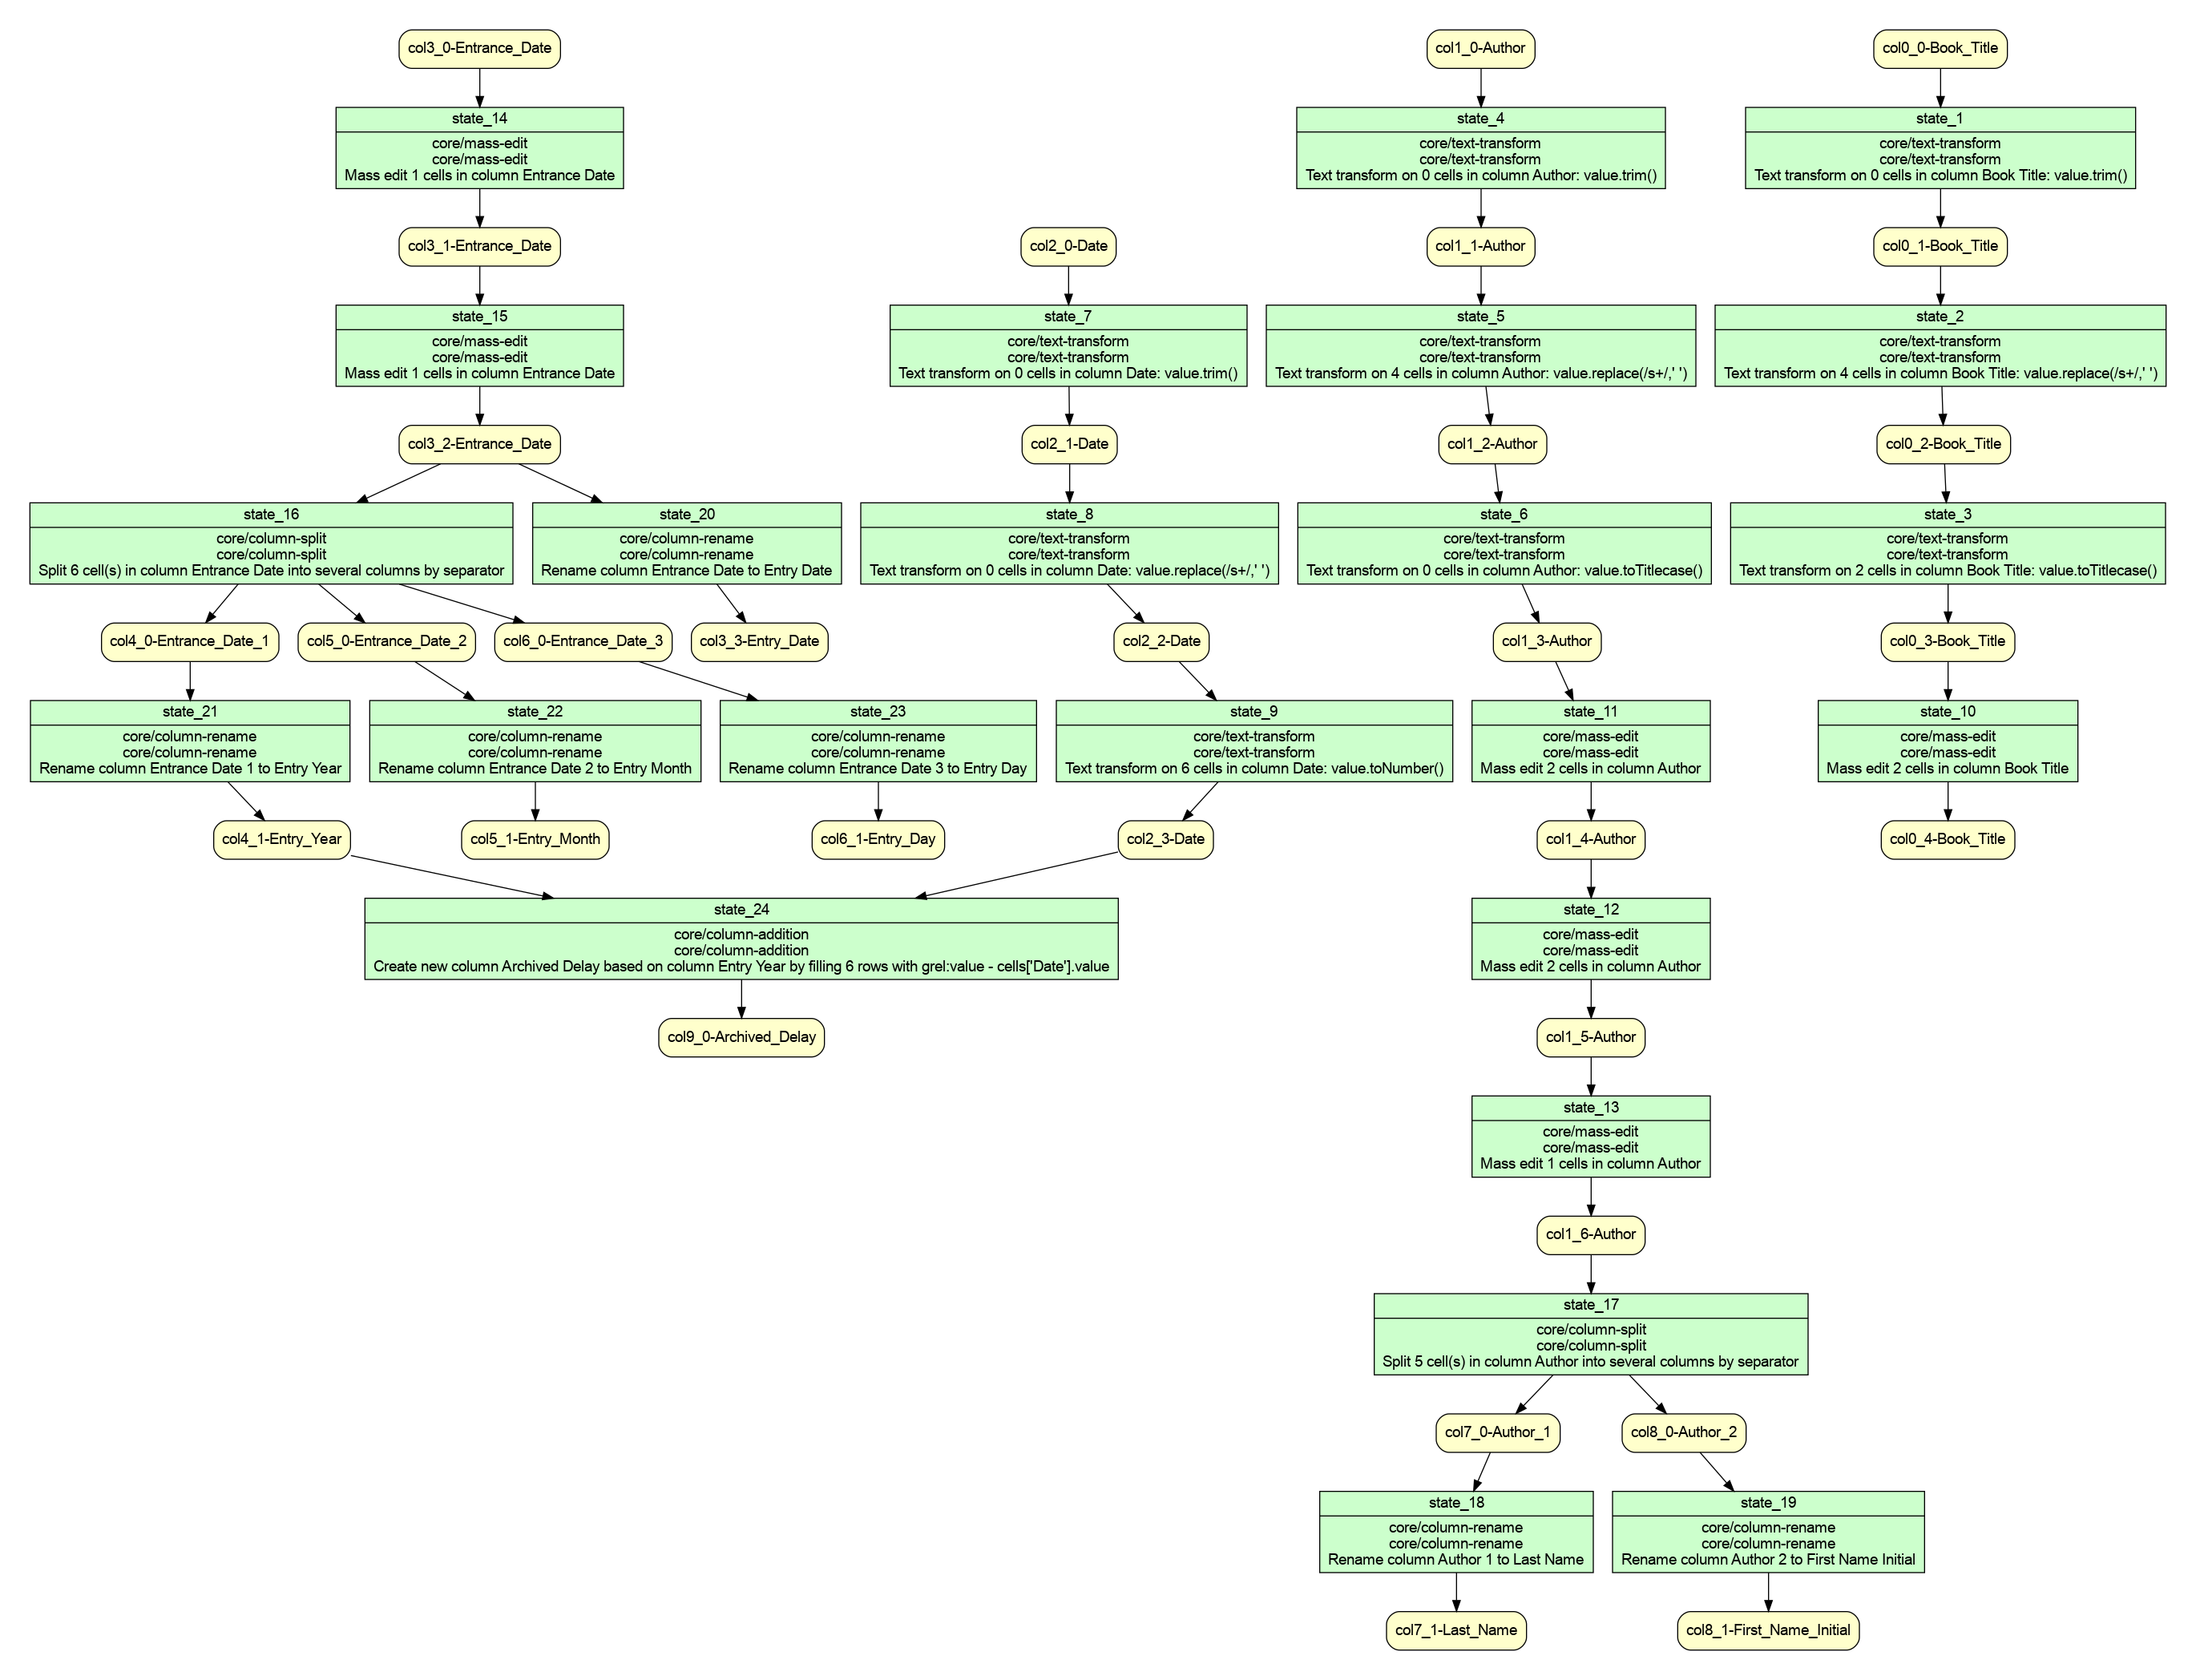

In [100]:
gv_string = header+single_process+column_nodes+parameters_nodes+group_process_nodes+freq_pattern_nodes+edges+footer
generate_pdf(gv_string)
display_yw(gv_string)

In [325]:
process_nodes,data_nodes_in-data_nodes_out,data_nodes_out-data_nodes_in

(['\n    #@begin state_1 #@desc core/text-transform\\ncore/text-transform\\nText transform on 0 cells in column name: value.trim() \n    \n        #@in col1_0-name\n____________\n        #@out col1_1-name\n________\n    #@end state_1     in\n    ',
  "\n    #@begin state_2 #@desc core/text-transform\\ncore/text-transform\\nText transform on 210 cells in column name: value.replace(/\\s+/,' ') \n    \n        #@in col1_1-name\n____________\n        #@out col1_2-name\n________\n    #@end state_2     in\n    ",
  '\n    #@begin state_3 #@desc core/text-transform\\ncore/text-transform\\nText transform on 6 cells in column host_name: value.trim() \n    \n        #@in col3_0-host_name\n____________\n        #@out col3_1-host_name\n________\n    #@end state_3     in\n    ',
  "\n    #@begin state_4 #@desc core/text-transform\\ncore/text-transform\\nText transform on 11 cells in column host_name: value.replace(/\\s+/,' ') \n    \n        #@in col3_1-host_name\n____________\n        #@out col3_2

In [188]:
compiled_yw = """#@begin test_or
"""
for x in data_nodes_in-data_nodes_out:
    compiled_yw+="#@in {}\n".format(x)
for x in data_nodes_out-data_nodes_in:
    compiled_yw+="#@out {}\n".format(x)    
for x in process_nodes:
    compiled_yw+=x+"\n"
compiled_yw += """#@end test_or"""

In [189]:
print(compiled_yw.strip())

#@begin test_or
#@in col1_0-Author
#@in col2_0-Date
#@in col3_0-Entrance_Date
#@in col0_0-Book_Title
#@out col6_1-Entry_Day
#@out col0_4-Book_Title
#@out col9_0-Archived_Delay
#@out col3_3-Entry_Date
#@out col7_1-Last_Name
#@out col5_1-Entry_Month
#@out col8_1-First_Name_Initial

    #@begin state_1 #@desc core/text-transform\ncore/text-transform\nText transform on 0 cells in column Book Title: value.trim() 
    
        #@in col0_0-Book_Title
____________
        #@out col0_1-Book_Title
________
    #@end state_1     in
    

    #@begin state_2 #@desc core/text-transform\ncore/text-transform\nText transform on 4 cells in column Book Title: value.replace(/\s+/,' ') 
    
        #@in col0_1-Book_Title
____________
        #@out col0_2-Book_Title
________
    #@end state_2     in
    

    #@begin state_3 #@desc core/text-transform\ncore/text-transform\nText transform on 2 cells in column Book Title: value.toTitlecase() 
    
        #@in col0_2-Book_Title
____________
        #@out co

In [190]:
def display_yw(compiled_yw,output="temporary.png"):
    with open("temporary.yw","w") as file:
        file.write(compiled_yw)
    !java -jar yesworkflow-0.2.2.0-SNAPSHOT-jar-with-dependencies.jar  graph temporary.yw -c extract.comment="#" | dot -Tpng -o $output
    from IPython.display import Image
    return Image(filename=output) 

In [191]:
def save_pdf_yw(compiled_yw,output="temporary.pdf"):
    with open("temporary.yw","w") as file:
        file.write(compiled_yw)
    !java -jar yesworkflow-0.2.2.0-SNAPSHOT-jar-with-dependencies.jar  graph temporary.yw -c extract.comment="#" | dot -Tpdf -o $output

In [488]:
#!java -jar yesworkflow-0.2.2.0-SNAPSHOT-jar-with-dependencies.jar  graph temporary.yw -c extract.comment="#" > collapsed_2.gv

In [466]:
!dot -Tpdf -o collapsed_2.pdf "collapsed_2 copy.gv"

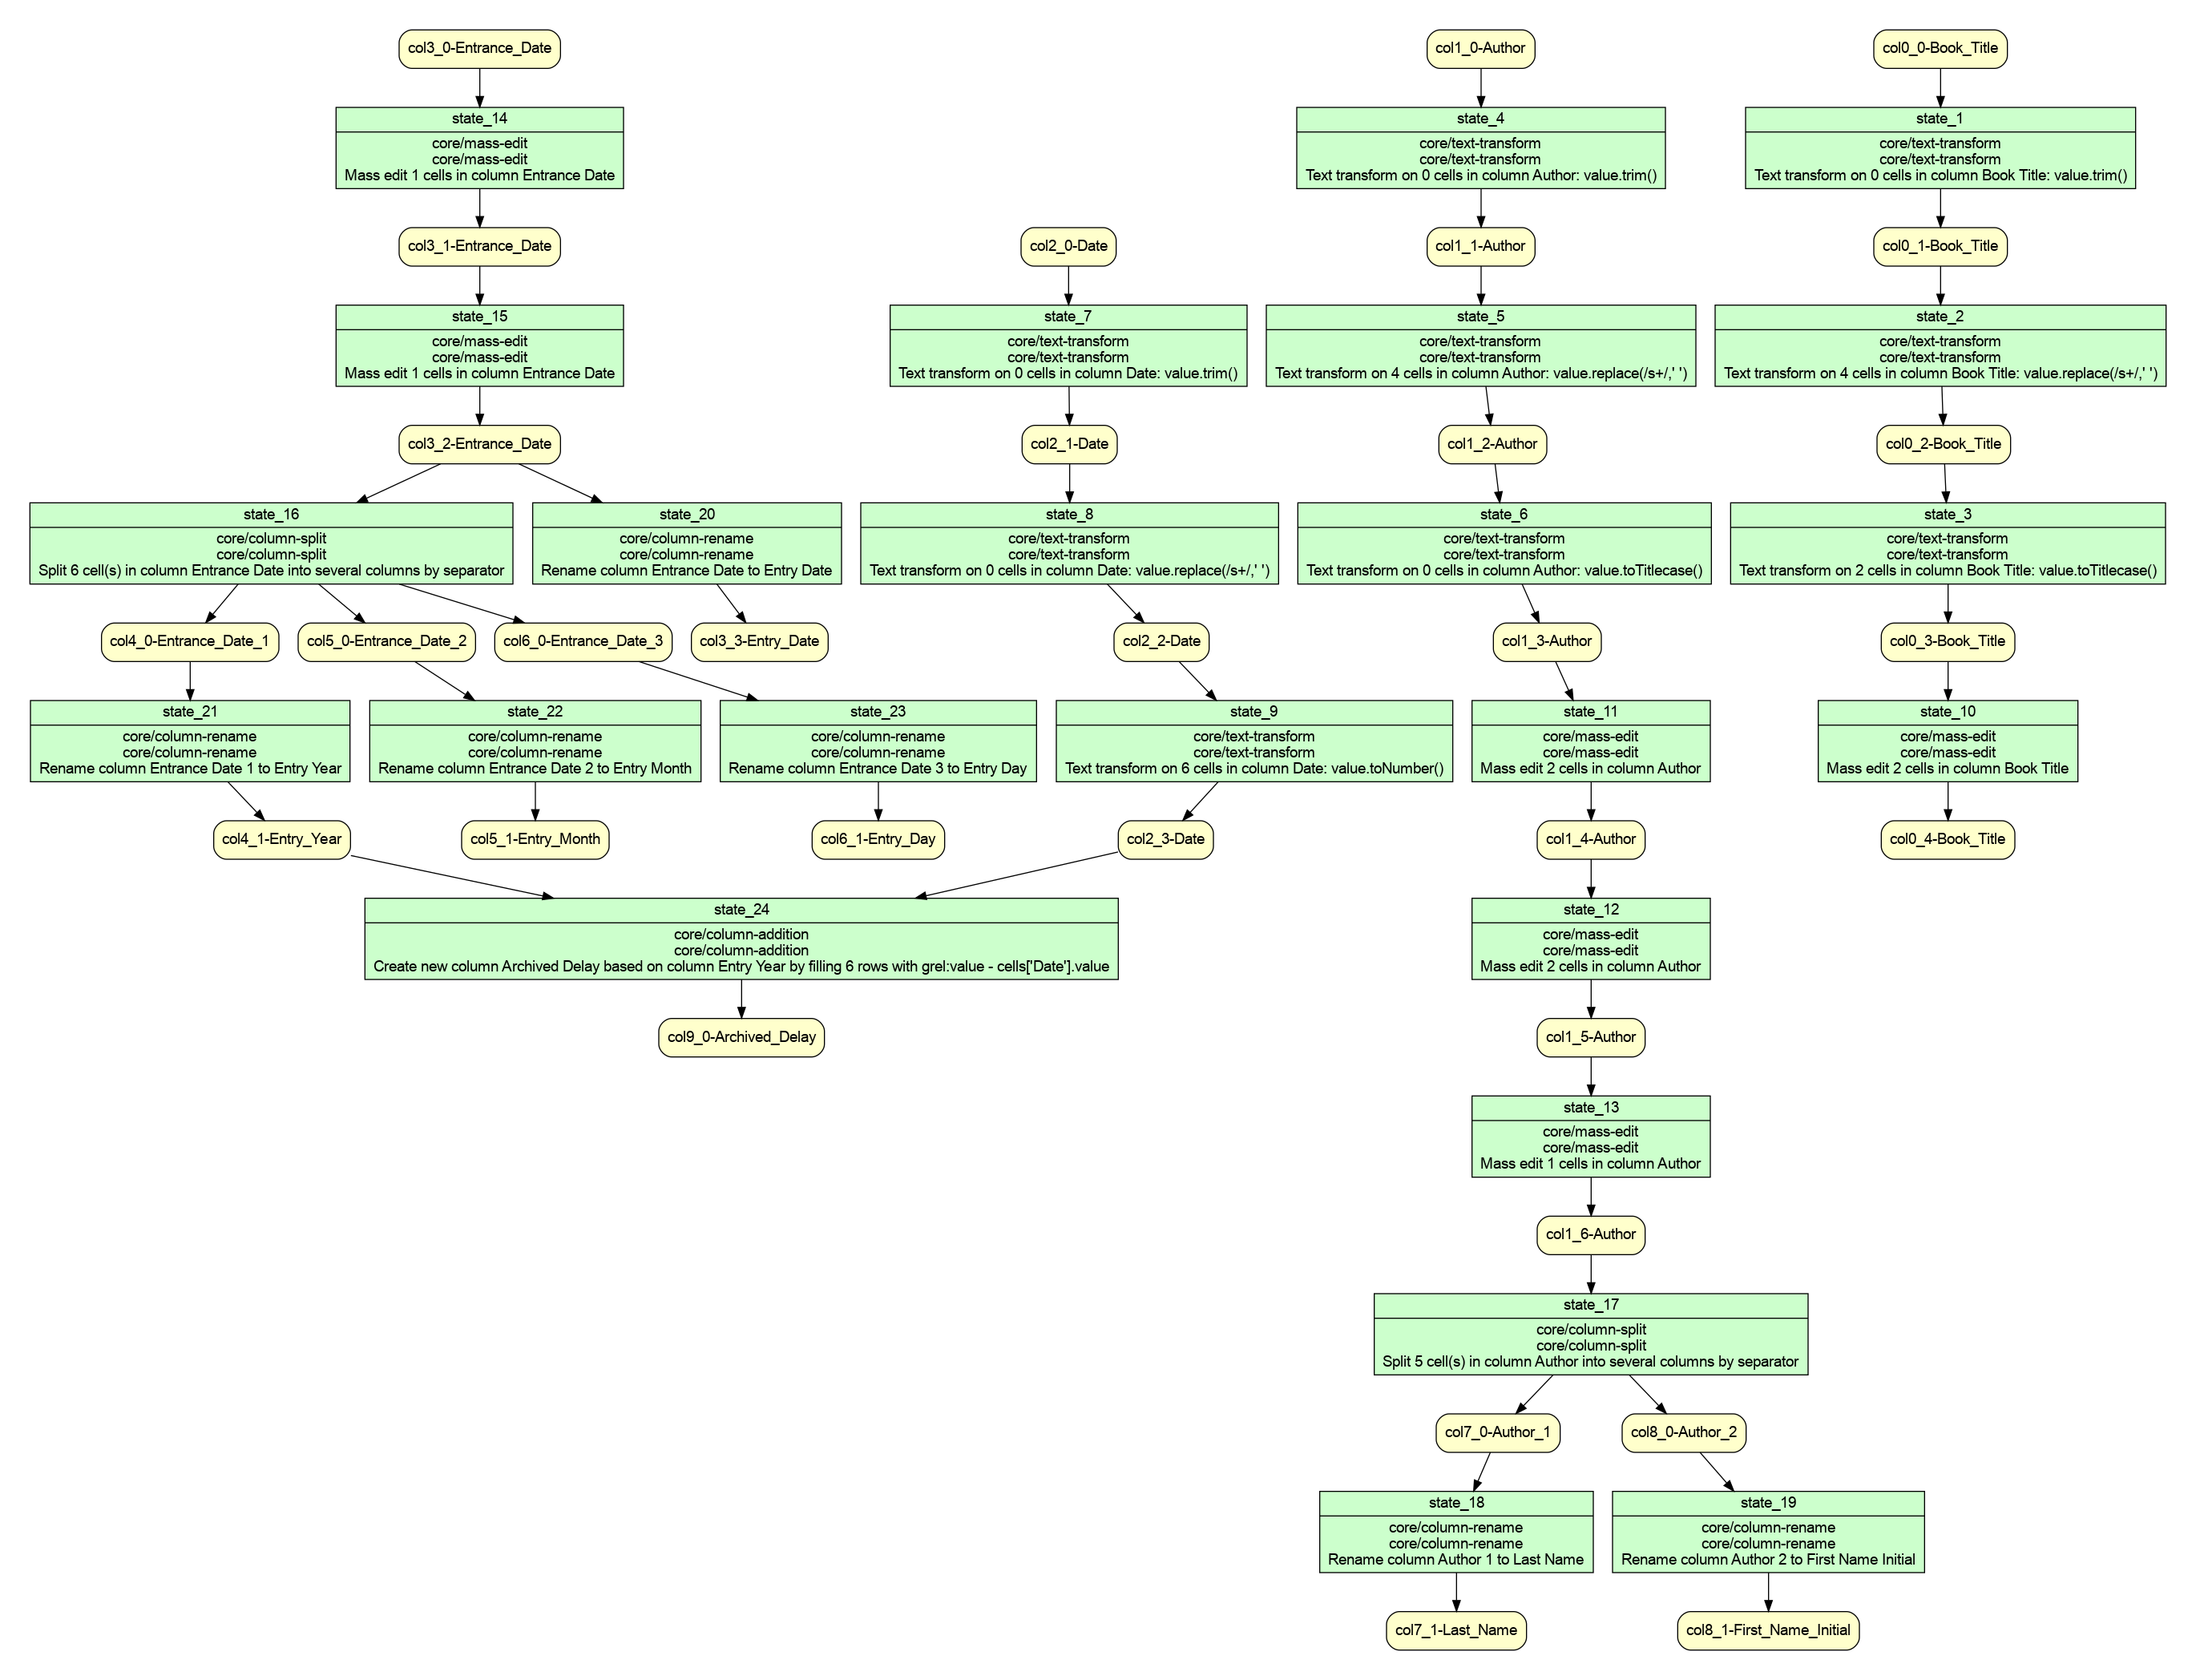

In [192]:
save_pdf_yw(compiled_yw)
display_yw(compiled_yw)

In [418]:
freq_pattern = collapsed_process.copy()

In [453]:
freq_pattern["state_58"]["annotation"] = "freq_pattern_analysis"
freq_pattern["state_5"]["annotation"] = "freq_pattern_analysis"
freq_pattern["state_13"]["annotation"] = "freq_pattern_analysis"
freq_pattern["state_12"]["annotation"] = "freq_pattern_analysis"
freq_pattern["state_11"]["annotation"] = "freq_pattern_analysis"
freq_pattern["state_10"]["annotation"] = "freq_pattern_analysis"
freq_pattern["state_10"]["annotation"] = "freq_pattern_analysis"
freq_pattern["state_36"]["annotation"] = "freq_pattern_analysis"
freq_pattern["state_69"]["annotation"] = "freq_pattern_analysis"



In [427]:
freq_pattern["state_58"]["output"] = freq_pattern["state_65"]["output"]
freq_pattern["state_58"]["desc"] = "sub_process_1"
freq_pattern["state_58"]["op"] = "clustering, remove_char"
del(freq_pattern["state_65"])

In [443]:
freq_pattern["state_5"]["output"] = freq_pattern["state_67"]["output"]
freq_pattern["state_5"]["desc"] = "sub_process_1"
freq_pattern["state_5"]["op"] = "clustering, remove_char"
del(freq_pattern["state_67"])

In [438]:
freq_pattern["state_13"]["output"] = freq_pattern["state_47"]["output"]
freq_pattern["state_13"]["desc"] = "sub_process_2"
freq_pattern["state_13"]["op"] = "upper_case, clustering"
del(freq_pattern["state_47"])

In [439]:
freq_pattern["state_12"]["output"] = freq_pattern["state_30"]["output"]
freq_pattern["state_12"]["desc"] = "sub_process_2"
freq_pattern["state_12"]["op"] = "upper_case, clustering"
del(freq_pattern["state_30"])

In [440]:
freq_pattern["state_11"]["output"] = freq_pattern["state_23"]["output"]
freq_pattern["state_11"]["desc"] = "sub_process_2"
freq_pattern["state_11"]["op"] = "upper_case, clustering"
del(freq_pattern["state_23"])

In [441]:
freq_pattern["state_10"]["output"] = freq_pattern["state_15"]["output"]
freq_pattern["state_10"]["desc"] = "sub_process_2"
freq_pattern["state_10"]["op"] = "upper_case, clustering"
del(freq_pattern["state_15"])

In [428]:
freq_pattern["state_36"]["output"] = freq_pattern["state_41"]["output"]
freq_pattern["state_36"]["desc"] = "sub_process_3"
freq_pattern["state_36"]["op"] = "remove_char, clustering, remove_char, clustering"
del(freq_pattern["state_39"])
del(freq_pattern["state_40"])
del(freq_pattern["state_41"])

In [437]:
freq_pattern["state_69"]["output"] = freq_pattern["state_86"]["output"]
freq_pattern["state_69"]["desc"] = "sub_process_3"
freq_pattern["state_69"]["op"] = "remove_char, clustering, remove_char, clustering"
del(freq_pattern["state_81"])
del(freq_pattern["state_85"])
del(freq_pattern["state_86"])

In [ ]:
#print(nodes_def+edge_def+"\n}")
from graphviz import Source

temp = nodes_def+edge_def+"\n}"
s = Source(temp)
s

In [118]:
process

{'state_1': {'input': ['col3_0'],
  'output': ['col3_1'],
  'desc': 'Rename column Entrance Date to Entry Date',
  'annotation': 'core/column-rename',
  'op': 'core/column-rename',
  'operation': {'op': 'core/column-rename',
   'oldColumnName': 'Entrance Date',
   'newColumnName': 'Entry Date',
   'description': 'Rename column Entrance Date to Entry Date'}},
 'state_2': {'input': ['col1_0'],
  'output': ['col1_1'],
  'desc': 'Text transform on 0 cells in column Author: value.toTitlecase()',
  'annotation': 'core/text-transform',
  'op': 'core/text-transform',
  'operation': {'op': 'core/text-transform',
   'engineConfig': {'facets': [], 'mode': 'row-based'},
   'columnName': 'Author',
   'expression': 'value.toTitlecase()',
   'onError': 'keep-original',
   'repeat': False,
   'repeatCount': 10,
   'description': 'Text transform on cells in column Author using expression value.toTitlecase()'}},
 'state_3': {'input': ['col0_0'],
  'output': ['col0_1'],
  'desc': 'Text transform on 1 cel

In [119]:
parallel_graph.edges

OutEdgeView([('state_1', 'col3_1'), ('col3_0', 'state_1'), ('col3_1', 'state_10'), ('state_2', 'col1_1'), ('col1_0', 'state_2'), ('col1_1', 'state_6'), ('state_3', 'col0_1'), ('col0_0', 'state_3'), ('col0_1', 'state_5'), ('state_4', 'col2_1'), ('col2_0', 'state_4'), ('col2_1', 'state_16'), ('state_5', 'col0_2'), ('col0_2', 'state_7'), ('state_6', 'col1_2'), ('col1_2', 'state_8'), ('state_7', 'col0_3'), ('state_8', 'col1_3'), ('col1_3', 'state_9'), ('state_9', 'col1_4'), ('col1_4', 'state_17'), ('state_10', 'col3_2'), ('col3_2', 'state_11'), ('state_11', 'col3_3'), ('col3_3', 'state_12'), ('state_12', 'col6_0'), ('state_12', 'col5_0'), ('state_12', 'col4_0'), ('col6_0', 'state_15'), ('col5_0', 'state_14'), ('col4_0', 'state_13'), ('state_13', 'col4_1'), ('col4_1', 'state_16'), ('col4_1', 'state_20'), ('state_14', 'col5_1'), ('col5_1', 'state_20'), ('state_15', 'col6_1'), ('col6_1', 'state_20'), ('state_16', 'col7_0'), ('state_17', 'col9_0'), ('state_17', 'col8_0'), ('col9_0', 'state_19'

In [120]:
#from matplotlib import pyplot as plt 
#plt.figure(figsize=(10,10))
#nx.draw_kamada_kawai(parallel_graph)

In [121]:
#col_state[col_state.col_id==int(colkey)]

In [122]:
"""
def parallel_state(parallel_graph,col_name):
    state_op_dict = dict(orpe.get_all_state_command().apply(lambda x:(x.state_id,json.loads(x.detail)["operation"]),axis=1).to_list())    
    state_graph = nx.DiGraph()
    all_path = nx.dfs_successors(parallel_graph,col_name)
    print(all_path)
    for key,val in all_path.items():
        if key.startswith("state"):
            try:
                print(key)
                for vv in all_path[key]:
                    for jj in all_path[vv]:
                        print("out",jj)            
                        state_graph.add_edge(key,jj)
            except:
                pass
    print(state_graph.edges)
    sink_nodes = [node for node, outdegree in dict(state_graph.out_degree(state_graph.nodes())).items() if outdegree == 0]
    source_nodes = [node for node, indegree in dict(state_graph.in_degree(state_graph.nodes())).items() if indegree == 0]
    recipes = []
    paths = []
    for x in [(source, sink) for sink in sink_nodes for source in source_nodes]:
        for path in nx.all_simple_paths(state_graph, source=x[0], target=x[1]):
            print(x)
            temp_path_recipe = list(filter(lambda x:x!=None,[json.loads(state_cmd[state_cmd.state_id==orpe.get_state_to_step(int(yy.split("_")[-1])-1)].detail.values[0])["operation"] for yy in path]))
            recipes.append(temp_path_recipe)
            paths.append(path)
    return recipes,paths
"""


'\ndef parallel_state(parallel_graph,col_name):\n    state_op_dict = dict(orpe.get_all_state_command().apply(lambda x:(x.state_id,json.loads(x.detail)["operation"]),axis=1).to_list())    \n    state_graph = nx.DiGraph()\n    all_path = nx.dfs_successors(parallel_graph,col_name)\n    print(all_path)\n    for key,val in all_path.items():\n        if key.startswith("state"):\n            try:\n                print(key)\n                for vv in all_path[key]:\n                    for jj in all_path[vv]:\n                        print("out",jj)            \n                        state_graph.add_edge(key,jj)\n            except:\n                pass\n    print(state_graph.edges)\n    sink_nodes = [node for node, outdegree in dict(state_graph.out_degree(state_graph.nodes())).items() if outdegree == 0]\n    source_nodes = [node for node, indegree in dict(state_graph.in_degree(state_graph.nodes())).items() if indegree == 0]\n    recipes = []\n    paths = []\n    for x in [(source, sink) f

# Parallel process / recipe

In [326]:
def parallel_state(parallel_graph,col_name):
    sink_nodes = [node for node, outdegree in dict(parallel_graph.out_degree(parallel_graph.nodes())).items() if outdegree == 0]
    source_nodes = [col_name]
    recipes = []
    data = []
    paths = []
    for x in [(source, sink) for sink in sink_nodes for source in source_nodes]:
        a_simple_path = list(nx.all_simple_paths(parallel_graph, source=x[0], target=x[1]))
        a_state_path = [list(filter(lambda x:x.startswith("state"), x)) for x in a_simple_path]
        #print(a_simple_path)
        a_data = [list(filter(lambda x:x.startswith("col"), x)) for x in a_simple_path]
        for i,path in enumerate(a_state_path):
            print(x)
            temp_path_recipe = list(filter(lambda x:x!=None,[json.loads(state_cmd[state_cmd.state_id==orpe.get_state_to_step(int(yy.split("_")[-1])-1)].detail.values[0])["operation"] for yy in path]))
            recipes.append(temp_path_recipe)
            paths.append((path,a_data[i]))
    return recipes,paths


In [327]:
def cluster_nodes(parallel_graph):
    sink_nodes = [node for node, outdegree in dict(parallel_graph.out_degree(parallel_graph.nodes())).items() if outdegree == 0]
    source_nodes = [node for node, indegree in dict(parallel_graph.in_degree(parallel_graph.nodes())).items() if indegree == 0]
    #res_cluster = {}
    res_cluster = {x:[] for x in source_nodes}
    #print(res_cluster)
    #try:
    #        res_cluster[x[0]] = []
    #except:
    #    pass
    for x in [(source, sink) for sink in sink_nodes for source in source_nodes]:
        #print(x)
        all_simple_path = list(nx.all_simple_paths(parallel_graph, source=x[0], target=x[1]))
        all_state_path = [list(filter(lambda x:x.startswith("state"), x)) for x in all_simple_path]
        all_data = [list(filter(lambda x:x.startswith("col"), x)) for x in all_simple_path]


        #a_state_path = [list(filter(lambda x:x.startswith("state"), x)) for x in a_simple_path]
        #a_data = [list(filter(lambda x:x.startswith("col"), x)) for x in a_simple_path]
        
        for ii,a_simple_path in enumerate(all_simple_path):
            #print(set(a_simple_path))
            if len(a_simple_path) > 0:
                #if len()
                is_intersect = False
                for y in res_cluster.copy():
                    if len(res_cluster[y])>0:
                        for j in res_cluster[y].copy(): 
                            #print(j)                   
                            if len(set(a_simple_path).intersection(j[0]))>0:
                                res_cluster[y].append((a_simple_path,all_state_path[ii],all_data[ii]))
                                is_intersect = True
                            #else:
                            #    res_cluster[x[0]].append(a_simple_path)     
                if not is_intersect:
                    res_cluster[x[0]].append((a_simple_path,all_state_path[ii],all_data[ii]))     
    return res_cluster                                   

In [328]:
a_cluster_nodes = cluster_nodes(parallel_graph)
a_cluster_nodes

{'col1_0': [(['col1_0',
    'state_1',
    'col1_1',
    'state_2',
    'col1_2',
    'state_31',
    'col22_0',
    'state_32',
    'col22_1',
    'state_37',
    'col22_2',
    'state_38',
    'col22_3'],
   ['state_1', 'state_2', 'state_31', 'state_32', 'state_37', 'state_38'],
   ['col1_0', 'col1_1', 'col1_2', 'col22_0', 'col22_1', 'col22_2', 'col22_3']),
  (['col1_0',
    'state_1',
    'col1_1',
    'state_2',
    'col1_2',
    'state_31',
    'col22_0',
    'state_32',
    'col22_1',
    'state_33',
    'col23_0',
    'state_34',
    'col23_1',
    'state_39',
    'col23_2',
    'state_40',
    'col23_3'],
   ['state_1',
    'state_2',
    'state_31',
    'state_32',
    'state_33',
    'state_34',
    'state_39',
    'state_40'],
   ['col1_0',
    'col1_1',
    'col1_2',
    'col22_0',
    'col22_1',
    'col23_0',
    'col23_1',
    'col23_2',
    'col23_3'])],
 'col3_0': [(['col3_0',
    'state_3',
    'col3_1',
    'state_4',
    'col3_2',
    'state_27',
    'col20_0',
    

In [329]:
class TraceTicker:
    ticker = -1
    def __init__(self,path,possible_set,id):
        self.path = path
        #print(self.path)
        self.len_path = len(path)
        self.possible_set = possible_set
        self.id = id

    def is_end_ticker(self):
        #print(self.len_path, self.ticker)
        if self.len_path-1 == self.ticker:
            return True
        return False
    
    def next_pos_ticker(self):
        try:
            self.possible_set[self.path[self.ticker+1]].remove(self.id)
            return False
        except:
            pass

        return self.path[self.ticker+1]

    def move_up_ticker(self):
        is_pass = False
        #print(self.is_end_ticker())
        if (not self.is_end_ticker()):
            if not self.next_pos_ticker():
                return None

        try:
            is_pass = len(self.possible_set[self.path[self.ticker+1]]) == 0            
        except:
            #if no lock
            is_pass = True            

        #print(is_pass,self.is_end_ticker)

        if (not self.is_end_ticker()) and is_pass:
            self.ticker+=1
            return self.path[self.ticker]


for key,val in a_cluster_nodes.items():
    #print(key,val)
    all_parallel_test = val
    #print(all_parallel_test)

    possible_set = {}
    for i,x in enumerate(all_parallel_test[:-1]):
        for j,y in enumerate(all_parallel_test[i+1:]):
            #print(x,y)
            temp_intersect = set(x[1]).intersection(y[1])
            #print(i,j+i+1,temp_intersect)
            for xx in temp_intersect:
                try:
                    possible_set[xx]
                except:
                    possible_set[xx] = set()
                possible_set[xx].add(i)
                possible_set[xx].add(j+i+1)

    #print(possible_set)

    ticker = [TraceTicker(x[1],possible_set,id) for id,x in  enumerate(all_parallel_test)]
    # check end condition
    end_condition = np.sum([x.is_end_ticker() for x in ticker])


    trace_ticker = set()

    combined_recipe = []

    while not end_condition:
        for id,x in enumerate(ticker):
            xx = x.move_up_ticker()
            if xx != None:
                if xx not in trace_ticker:
                    trace_ticker.add(xx)
                    #print(id,xx)
                    combined_recipe.append(xx)
        end_condition = np.sum([x.is_end_ticker() for x in ticker]) == len(ticker)
    
    print(key,combined_recipe)


col1_0 ['state_1', 'state_2', 'state_31', 'state_32', 'state_37', 'state_33', 'state_38', 'state_34', 'state_39', 'state_40']
col3_0 ['state_3', 'state_4', 'state_27', 'state_43', 'state_44', 'state_41', 'state_42', 'state_50', 'state_51', 'state_52', 'state_55']
col5_0 ['state_5', 'state_7', 'state_6', 'state_8', 'state_18', 'state_19', 'state_45', 'state_46', 'state_20', 'state_21', 'state_22', 'state_23', 'state_47', 'state_24', 'state_25', 'state_48', 'state_26', 'state_59', 'state_49']
col8_0 []
col2_0 ['state_9', 'state_53', 'state_54']
col6_0 ['state_10']
col7_0 ['state_11']
col9_0 ['state_12', 'state_35']
col10_0 ['state_13', 'state_36']
col11_0 ['state_14']
col13_0 ['state_15']
col14_0 ['state_16']
col15_0 ['state_17']
col4_0 ['state_28']
col12_0 ['state_29', 'state_30']


In [330]:
cluster_recipe = {}
for key,value in a_cluster_nodes.items(): 
    cluster_recipe[key] = value
cluster_recipe

{'col1_0': [(['col1_0',
    'state_1',
    'col1_1',
    'state_2',
    'col1_2',
    'state_31',
    'col22_0',
    'state_32',
    'col22_1',
    'state_37',
    'col22_2',
    'state_38',
    'col22_3'],
   ['state_1', 'state_2', 'state_31', 'state_32', 'state_37', 'state_38'],
   ['col1_0', 'col1_1', 'col1_2', 'col22_0', 'col22_1', 'col22_2', 'col22_3']),
  (['col1_0',
    'state_1',
    'col1_1',
    'state_2',
    'col1_2',
    'state_31',
    'col22_0',
    'state_32',
    'col22_1',
    'state_33',
    'col23_0',
    'state_34',
    'col23_1',
    'state_39',
    'col23_2',
    'state_40',
    'col23_3'],
   ['state_1',
    'state_2',
    'state_31',
    'state_32',
    'state_33',
    'state_34',
    'state_39',
    'state_40'],
   ['col1_0',
    'col1_1',
    'col1_2',
    'col22_0',
    'col22_1',
    'col23_0',
    'col23_1',
    'col23_2',
    'col23_3'])],
 'col3_0': [(['col3_0',
    'state_3',
    'col3_1',
    'state_4',
    'col3_2',
    'state_27',
    'col20_0',
    

In [331]:
state_cmd = orpe.get_all_state_command()

In [332]:
parallel_graph.nodes()

NodeView(('state_1', 'col1_0', 'col1_1', 'state_2', 'col1_2', 'state_3', 'col3_0', 'col3_1', 'state_4', 'col3_2', 'state_5', 'col5_0', 'col5_1', 'state_6', 'col5_2', 'state_7', 'col8_0', 'col8_1', 'state_8', 'col8_2', 'state_9', 'col2_0', 'col2_1', 'state_10', 'col6_0', 'col6_1', 'state_11', 'col7_0', 'col7_1', 'state_12', 'col9_0', 'col9_1', 'state_13', 'col10_0', 'col10_1', 'state_14', 'col11_0', 'col11_1', 'state_15', 'col13_0', 'col13_1', 'state_16', 'col14_0', 'col14_1', 'state_17', 'col15_0', 'col15_1', 'state_18', 'col16_0', 'state_19', 'col16_1', 'state_20', 'col17_0', 'state_21', 'col17_1', 'state_22', 'col18_0', 'state_23', 'col18_1', 'state_24', 'col18_2', 'state_25', 'col18_3', 'state_26', 'col18_4', 'state_27', 'col20_0', 'col19_0', 'state_28', 'col4_0', 'col_removed_0', 'state_29', 'col12_0', 'col12_1', 'state_30', 'col21_0', 'state_31', 'col22_0', 'state_32', 'col22_1', 'state_33', 'col23_0', 'state_34', 'col23_1', 'state_35', 'col24_0', 'state_36', 'col25_0', 'state_37'

In [333]:
sink_nodes = [node for node, outdegree in dict(parallel_graph.out_degree(parallel_graph.nodes())).items() if outdegree == 0]
source_nodes = [node for node, indegree in dict(parallel_graph.in_degree(parallel_graph.nodes())).items() if indegree == 0]

all_parallel_test = []
for x in source_nodes: 
    all_parallel_test.extend(parallel_state(parallel_graph,x)[1])

('col1_0', 'col22_3')
('col1_0', 'col23_3')
('col3_0', 'col20_2')
('col3_0', 'col19_5')
('col3_0', 'col19_5')
('col3_0', 'col3_4')
('col3_0', 'col3_4')
('col5_0', 'col16_3')
('col5_0', 'col18_5')
('col5_0', 'col26_0')
('col8_0', 'col26_0')
('col2_0', 'col2_3')
('col6_0', 'col6_1')
('col7_0', 'col7_1')
('col9_0', 'col24_0')
('col10_0', 'col25_0')
('col11_0', 'col11_1')
('col13_0', 'col13_1')
('col14_0', 'col14_1')
('col15_0', 'col15_1')
('col4_0', 'col_removed_0')
('col12_0', 'col21_0')


In [334]:
all_parallel_test

[(['state_1', 'state_2', 'state_31', 'state_32', 'state_37', 'state_38'],
  ['col1_0', 'col1_1', 'col1_2', 'col22_0', 'col22_1', 'col22_2', 'col22_3']),
 (['state_1',
   'state_2',
   'state_31',
   'state_32',
   'state_33',
   'state_34',
   'state_39',
   'state_40'],
  ['col1_0',
   'col1_1',
   'col1_2',
   'col22_0',
   'col22_1',
   'col23_0',
   'col23_1',
   'col23_2',
   'col23_3']),
 (['state_3', 'state_4', 'state_27', 'state_43', 'state_44'],
  ['col3_0', 'col3_1', 'col3_2', 'col20_0', 'col20_1', 'col20_2']),
 (['state_3',
   'state_4',
   'state_27',
   'state_41',
   'state_42',
   'state_50',
   'state_51',
   'state_52'],
  ['col3_0',
   'col3_1',
   'col3_2',
   'col19_0',
   'col19_1',
   'col19_2',
   'col19_3',
   'col19_4',
   'col19_5']),
 (['state_3', 'state_4', 'state_52'],
  ['col3_0', 'col3_1', 'col3_2', 'col19_5']),
 (['state_3',
   'state_4',
   'state_27',
   'state_41',
   'state_42',
   'state_50',
   'state_51',
   'state_52',
   'state_55'],
  ['col3_0'

In [335]:
all_parallel_test

[(['state_1', 'state_2', 'state_31', 'state_32', 'state_37', 'state_38'],
  ['col1_0', 'col1_1', 'col1_2', 'col22_0', 'col22_1', 'col22_2', 'col22_3']),
 (['state_1',
   'state_2',
   'state_31',
   'state_32',
   'state_33',
   'state_34',
   'state_39',
   'state_40'],
  ['col1_0',
   'col1_1',
   'col1_2',
   'col22_0',
   'col22_1',
   'col23_0',
   'col23_1',
   'col23_2',
   'col23_3']),
 (['state_3', 'state_4', 'state_27', 'state_43', 'state_44'],
  ['col3_0', 'col3_1', 'col3_2', 'col20_0', 'col20_1', 'col20_2']),
 (['state_3',
   'state_4',
   'state_27',
   'state_41',
   'state_42',
   'state_50',
   'state_51',
   'state_52'],
  ['col3_0',
   'col3_1',
   'col3_2',
   'col19_0',
   'col19_1',
   'col19_2',
   'col19_3',
   'col19_4',
   'col19_5']),
 (['state_3', 'state_4', 'state_52'],
  ['col3_0', 'col3_1', 'col3_2', 'col19_5']),
 (['state_3',
   'state_4',
   'state_27',
   'state_41',
   'state_42',
   'state_50',
   'state_51',
   'state_52',
   'state_55'],
  ['col3_0'

In [336]:
import networkx as nx
state_graph = nx.DiGraph()
for x in all_parallel_test:
    #print(x[0])
    if len(x[0])>1:
        for i,y in enumerate(x[0][:-1]):
            state_graph.add_edge(y,x[0][i+1])
    else:
        #print(y)
        state_graph.add_node(x[0][0])

In [337]:
end_sink_nodes = [node for node, outdegree in dict(state_graph.out_degree(state_graph.nodes())).items() if outdegree == 0]
start_source_nodes = [node for node, indegree in dict(state_graph.in_degree(state_graph.nodes())).items() if indegree == 0]
end_split =  [node for node, outdegree in dict(state_graph.out_degree(state_graph.nodes())).items() if outdegree > 1]
start_split =   list(set([x[1] for x in state_graph.out_edges(end_split)]))
start_merge = [node for node, indegree in dict(state_graph.in_degree(state_graph.nodes())).items() if indegree > 1]
end_merge =   list(set([x[0] for x in state_graph.in_edges(start_merge)]))


In [338]:
sink_nodes = [node for node, outdegree in dict(parallel_graph.out_degree(parallel_graph.nodes())).items() if outdegree == 0]
source_nodes = [node for node, indegree in dict(parallel_graph.in_degree(parallel_graph.nodes())).items() if indegree == 0]

all_parallel_test = []
for x in source_nodes: 
    all_parallel_test.extend(parallel_state(parallel_graph,x)[1])

import networkx as nx
state_graph = nx.DiGraph()
for x in all_parallel_test:
    #print(x[0])
    if len(x[0])>1:
        for i,y in enumerate(x[0][:-1]):
            state_graph.add_edge(y,x[0][i+1])
    else:
        #print(y)
        state_graph.add_node(x[0][0])

end_sink_nodes = [node for node, outdegree in dict(state_graph.out_degree(state_graph.nodes())).items() if outdegree == 0]
start_source_nodes = [node for node, indegree in dict(state_graph.in_degree(state_graph.nodes())).items() if indegree == 0]
end_split =  [node for node, outdegree in dict(state_graph.out_degree(state_graph.nodes())).items() if outdegree > 1]
start_split =   list(set([x[1] for x in state_graph.out_edges(end_split)]))
start_merge = [node for node, indegree in dict(state_graph.in_degree(state_graph.nodes())).items() if indegree > 1]
end_merge =   list(set([x[0] for x in state_graph.in_edges(start_merge)]))


start_points = start_source_nodes+start_split+start_merge
end_points = end_sink_nodes+end_split+end_merge

cluster = {}
for x in start_points:
    for y in end_points:
        try:
            #print(x)
            ps = nx.shortest_path(state_graph,x,y)
            try:
                if len(ps) < len(cluster[ps[-1]]):
                    cluster[ps[-1]] = ps
            except:
                cluster[ps[-1]] = ps
            #print(ps)
        except:
            pass

['state_38',
 'state_40',
 'state_44',
 'state_55',
 'state_46',
 'state_49',
 'state_59',
 'state_54',
 'state_10',
 'state_11',
 'state_35',
 'state_36',
 'state_14',
 'state_15',
 'state_16',
 'state_17',
 'state_28',
 'state_30']

In [339]:
start_points = start_source_nodes+start_split+start_merge
end_points = end_sink_nodes+end_split+end_merge

In [340]:
start_points,end_points

(['state_1',
  'state_3',
  'state_5',
  'state_7',
  'state_9',
  'state_10',
  'state_11',
  'state_12',
  'state_13',
  'state_14',
  'state_15',
  'state_16',
  'state_17',
  'state_28',
  'state_29',
  'state_43',
  'state_22',
  'state_37',
  'state_20',
  'state_27',
  'state_45',
  'state_52',
  'state_41',
  'state_47',
  'state_33',
  'state_52',
  'state_59'],
 ['state_38',
  'state_40',
  'state_44',
  'state_55',
  'state_46',
  'state_49',
  'state_59',
  'state_54',
  'state_10',
  'state_11',
  'state_35',
  'state_36',
  'state_14',
  'state_15',
  'state_16',
  'state_17',
  'state_28',
  'state_30',
  'state_32',
  'state_4',
  'state_27',
  'state_19',
  'state_21',
  'state_8',
  'state_48',
  'state_4',
  'state_51'])

In [341]:
#nx.shortest_path(state_graph,"state_12","state_77")

In [342]:
cluster = {}
for x in start_points:
    for y in end_points:
        try:
            #print(x)
            ps = nx.shortest_path(state_graph,x,y)
            try:
                if len(ps) < len(cluster[ps[-1]]):
                    cluster[ps[-1]] = ps
            except:
                cluster[ps[-1]] = ps
            #print(ps)
        except:
            pass

In [343]:
cluster.keys()

dict_keys(['state_38', 'state_40', 'state_32', 'state_44', 'state_55', 'state_4', 'state_27', 'state_51', 'state_46', 'state_49', 'state_59', 'state_19', 'state_21', 'state_48', 'state_8', 'state_54', 'state_10', 'state_11', 'state_35', 'state_36', 'state_14', 'state_15', 'state_16', 'state_17', 'state_28', 'state_30'])

In [344]:
cluster

{'state_38': ['state_37', 'state_38'],
 'state_40': ['state_33', 'state_34', 'state_39', 'state_40'],
 'state_32': ['state_1', 'state_2', 'state_31', 'state_32'],
 'state_44': ['state_43', 'state_44'],
 'state_55': ['state_52', 'state_55'],
 'state_4': ['state_3', 'state_4'],
 'state_27': ['state_27'],
 'state_51': ['state_41', 'state_42', 'state_50', 'state_51'],
 'state_46': ['state_45', 'state_46'],
 'state_49': ['state_22',
  'state_23',
  'state_24',
  'state_25',
  'state_26',
  'state_49'],
 'state_59': ['state_59'],
 'state_19': ['state_5', 'state_6', 'state_18', 'state_19'],
 'state_21': ['state_20', 'state_21'],
 'state_48': ['state_47', 'state_48'],
 'state_8': ['state_7', 'state_8'],
 'state_54': ['state_9', 'state_53', 'state_54'],
 'state_10': ['state_10'],
 'state_11': ['state_11'],
 'state_35': ['state_12', 'state_35'],
 'state_36': ['state_13', 'state_36'],
 'state_14': ['state_14'],
 'state_15': ['state_15'],
 'state_16': ['state_16'],
 'state_17': ['state_17'],
 'sta

In [345]:
#cluster["state_14"]

In [346]:
#for x in state_graph.edges(end_split[0]):
#    print(x[1])

In [347]:
# intersection of columns at state derived from all_parallel_test (return index of the parallel test)

possible_set = {}
for i,x in enumerate(all_parallel_test[:-1]):
    for j,y in enumerate(all_parallel_test[i+1:]):
        temp_intersect = set(x[0]).intersection(y[0])
        #print(i,j+i+1,temp_intersect)
        for xx in temp_intersect:
            try:
                possible_set[xx]
            except:
                possible_set[xx] = set()
            possible_set[xx].add(i)
            possible_set[xx].add(j+i+1)
            

In [348]:
ind_set = set()
for x in possible_set.values():
    for y in x:
        ind_set.add(y)
ind_set

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10}

In [349]:
ind_list = list(filter(lambda x:x is not None,[x[0] if i not in ind_set else None for i,x in enumerate(all_parallel_test)]))

In [350]:
possible_set = {}
for i,x in enumerate(all_parallel_test[:-1]):
    for j,y in enumerate(all_parallel_test[i+1:]):
        temp_intersect = set(x[0]).intersection(y[0])
        print(i,j+i+1,temp_intersect)
        for xx in temp_intersect:
            try:
                possible_set[xx]
            except:
                possible_set[xx] = set()
            possible_set[xx].add(i)
            possible_set[xx].add(j+i+1)
                         

0 1 {'state_31', 'state_32', 'state_2', 'state_1'}
0 2 set()
0 3 set()
0 4 set()
0 5 set()
0 6 set()
0 7 set()
0 8 set()
0 9 set()
0 10 set()
0 11 set()
0 12 set()
0 13 set()
0 14 set()
0 15 set()
0 16 set()
0 17 set()
0 18 set()
0 19 set()
0 20 set()
0 21 set()
1 2 set()
1 3 set()
1 4 set()
1 5 set()
1 6 set()
1 7 set()
1 8 set()
1 9 set()
1 10 set()
1 11 set()
1 12 set()
1 13 set()
1 14 set()
1 15 set()
1 16 set()
1 17 set()
1 18 set()
1 19 set()
1 20 set()
1 21 set()
2 3 {'state_27', 'state_3', 'state_4'}
2 4 {'state_3', 'state_4'}
2 5 {'state_27', 'state_3', 'state_4'}
2 6 {'state_3', 'state_4'}
2 7 set()
2 8 set()
2 9 set()
2 10 set()
2 11 set()
2 12 set()
2 13 set()
2 14 set()
2 15 set()
2 16 set()
2 17 set()
2 18 set()
2 19 set()
2 20 set()
2 21 set()
3 4 {'state_52', 'state_3', 'state_4'}
3 5 {'state_51', 'state_27', 'state_42', 'state_52', 'state_41', 'state_4', 'state_50', 'state_3'}
3 6 {'state_52', 'state_3', 'state_4'}
3 7 set()
3 8 set()
3 9 set()
3 10 set()
3 11 set()
3 

In [351]:
temp_set = set()
intertwined_set = []
for x,xx in possible_set.items():
    temp_combined = []
    if tuple(xx) not in temp_set:
        #temp_combined = [(x,xx,[all_parallel_test[xi] for xi in xx])] 
        temp_combined = [(x,xx)] 
        temp_set.add(tuple(xx))   
        for y,yy in possible_set.items():
            if x!=y:
                if tuple(yy) not in temp_set:
                    if len(set(xx).intersection(yy))>0:
                        #temp_combined.append((y,yy,[all_parallel_test[xi] for xi in yy]))
                        temp_combined.append((y,yy))
                        temp_set.add(tuple(yy))
    if len(temp_combined)>0:
        intertwined_set.append(temp_combined)
    

In [352]:
def intersection_check(next_set,temp,result=[]):
    #print(temp,next_set)
    if len(temp)==0:
        return
    for i,x in enumerate(next_set):
        temp_set = set.intersection(*map(set,[temp,x]))
        print("intersection",temp_set)
        if len(temp_set)>0:            
            result.append(temp_set)
        if i<len(next_set)-1 and len(temp_set)>0:
            intersection_check(next_set[1:],temp_set,result)

ind_intertw = []
for x in intertwined_set:    
    yy = [y[1] for y in x]
    temp_set = set()
    for y in yy:
        for z in y:
            temp_set.add(z)
    yy = [all_parallel_test[y][0] for y in temp_set]
    
    result = []
    for y in range(len(yy)-1):
        intersection_check(yy[y+1:],yy[y],result)
    #print(result)
    for y in yy:
        yc = y.copy()
        for r in result:
            for rr in r:
                try:
                    yc.remove(rr)
                except:
                    continue    
        #print("yc",yc)
        if len(yc)>0:
            ind_intertw.append(yc)

    for r in result:
        for y in yy:
            is_int = len(r-set(y))==0
            if is_int:
                temp_int = []
                for yi in y:
                    if yi in r:
                        temp_int.append(yi)
                ind_intertw.append(temp_int)
                break

    #print(yy)
    #print(set.intersection(*map(set,yy)))

intersection {'state_2', 'state_31', 'state_32', 'state_1'}
intersection {'state_27', 'state_3', 'state_4'}
intersection {'state_3', 'state_4'}
intersection {'state_3', 'state_4'}
intersection {'state_3', 'state_4'}
intersection {'state_3', 'state_4'}
intersection {'state_27', 'state_3', 'state_4'}
intersection {'state_27', 'state_3', 'state_4'}
intersection {'state_3', 'state_4'}
intersection {'state_3', 'state_4'}
intersection {'state_3', 'state_4'}
intersection {'state_3', 'state_4'}
intersection {'state_3', 'state_4'}
intersection {'state_3', 'state_4'}
intersection {'state_3', 'state_4'}
intersection {'state_3', 'state_4'}
intersection {'state_3', 'state_4'}
intersection {'state_3', 'state_4'}
intersection {'state_3', 'state_4'}
intersection {'state_3', 'state_4'}
intersection {'state_3', 'state_4'}
intersection {'state_27', 'state_3', 'state_4'}
intersection {'state_3', 'state_4'}
intersection {'state_3', 'state_4'}
intersection {'state_3', 'state_4'}
intersection {'state_3', 'st

In [353]:
all_parallel_test

[(['state_1', 'state_2', 'state_31', 'state_32', 'state_37', 'state_38'],
  ['col1_0', 'col1_1', 'col1_2', 'col22_0', 'col22_1', 'col22_2', 'col22_3']),
 (['state_1',
   'state_2',
   'state_31',
   'state_32',
   'state_33',
   'state_34',
   'state_39',
   'state_40'],
  ['col1_0',
   'col1_1',
   'col1_2',
   'col22_0',
   'col22_1',
   'col23_0',
   'col23_1',
   'col23_2',
   'col23_3']),
 (['state_3', 'state_4', 'state_27', 'state_43', 'state_44'],
  ['col3_0', 'col3_1', 'col3_2', 'col20_0', 'col20_1', 'col20_2']),
 (['state_3',
   'state_4',
   'state_27',
   'state_41',
   'state_42',
   'state_50',
   'state_51',
   'state_52'],
  ['col3_0',
   'col3_1',
   'col3_2',
   'col19_0',
   'col19_1',
   'col19_2',
   'col19_3',
   'col19_4',
   'col19_5']),
 (['state_3', 'state_4', 'state_52'],
  ['col3_0', 'col3_1', 'col3_2', 'col19_5']),
 (['state_3',
   'state_4',
   'state_27',
   'state_41',
   'state_42',
   'state_50',
   'state_51',
   'state_52',
   'state_55'],
  ['col3_0'

In [354]:
ind_intertw

[['state_37', 'state_38'],
 ['state_33', 'state_34', 'state_39', 'state_40'],
 ['state_1', 'state_2', 'state_31', 'state_32'],
 ['state_43', 'state_44'],
 ['state_3', 'state_4', 'state_27'],
 ['state_3', 'state_4'],
 ['state_3', 'state_4'],
 ['state_3', 'state_4'],
 ['state_3', 'state_4'],
 ['state_3', 'state_4', 'state_27'],
 ['state_3', 'state_4', 'state_27'],
 ['state_3', 'state_4'],
 ['state_3', 'state_4'],
 ['state_3', 'state_4'],
 ['state_3', 'state_4'],
 ['state_3', 'state_4'],
 ['state_3', 'state_4'],
 ['state_3', 'state_4'],
 ['state_3', 'state_4'],
 ['state_3', 'state_4'],
 ['state_3', 'state_4'],
 ['state_3', 'state_4'],
 ['state_3', 'state_4'],
 ['state_3', 'state_4'],
 ['state_3', 'state_4', 'state_27'],
 ['state_3', 'state_4'],
 ['state_3', 'state_4'],
 ['state_3', 'state_4'],
 ['state_3', 'state_4'],
 ['state_3', 'state_4', 'state_27'],
 ['state_3', 'state_4', 'state_27'],
 ['state_3', 'state_4'],
 ['state_3', 'state_4'],
 ['state_3', 'state_4'],
 ['state_3', 'state_4'],

In [355]:
ind_combined = ind_intertw + ind_list

In [356]:
ind_combined = list(cluster.values())
ind_combined

[['state_37', 'state_38'],
 ['state_33', 'state_34', 'state_39', 'state_40'],
 ['state_1', 'state_2', 'state_31', 'state_32'],
 ['state_43', 'state_44'],
 ['state_52', 'state_55'],
 ['state_3', 'state_4'],
 ['state_27'],
 ['state_41', 'state_42', 'state_50', 'state_51'],
 ['state_45', 'state_46'],
 ['state_22', 'state_23', 'state_24', 'state_25', 'state_26', 'state_49'],
 ['state_59'],
 ['state_5', 'state_6', 'state_18', 'state_19'],
 ['state_20', 'state_21'],
 ['state_47', 'state_48'],
 ['state_7', 'state_8'],
 ['state_9', 'state_53', 'state_54'],
 ['state_10'],
 ['state_11'],
 ['state_12', 'state_35'],
 ['state_13', 'state_36'],
 ['state_14'],
 ['state_15'],
 ['state_16'],
 ['state_17'],
 ['state_28'],
 ['state_29', 'state_30']]

In [357]:
cluster

{'state_38': ['state_37', 'state_38'],
 'state_40': ['state_33', 'state_34', 'state_39', 'state_40'],
 'state_32': ['state_1', 'state_2', 'state_31', 'state_32'],
 'state_44': ['state_43', 'state_44'],
 'state_55': ['state_52', 'state_55'],
 'state_4': ['state_3', 'state_4'],
 'state_27': ['state_27'],
 'state_51': ['state_41', 'state_42', 'state_50', 'state_51'],
 'state_46': ['state_45', 'state_46'],
 'state_49': ['state_22',
  'state_23',
  'state_24',
  'state_25',
  'state_26',
  'state_49'],
 'state_59': ['state_59'],
 'state_19': ['state_5', 'state_6', 'state_18', 'state_19'],
 'state_21': ['state_20', 'state_21'],
 'state_48': ['state_47', 'state_48'],
 'state_8': ['state_7', 'state_8'],
 'state_54': ['state_9', 'state_53', 'state_54'],
 'state_10': ['state_10'],
 'state_11': ['state_11'],
 'state_35': ['state_12', 'state_35'],
 'state_36': ['state_13', 'state_36'],
 'state_14': ['state_14'],
 'state_15': ['state_15'],
 'state_16': ['state_16'],
 'state_17': ['state_17'],
 'sta

In [358]:
detail_parallel = []
for x in ind_combined:
    #it_process = [(y,process[y]["op"],process[y]["annotation"],process[y]["input"],process[y]["output"]) for y in x]
    it_process = []
    for y in x:
        try:
            it_process.append((y,process[y]["op"],process[y]["annotation"],process[y]["input"],process[y]["output"]))
        except:
            it_process.append((y,"single-op","single-op",process[y]["input"],process[y]["output"]))
    #print(it_process)
    temp = it_process[0][2]
    temp_y = it_process[0]
    #print("tt",it_process)
    let_temp = []
    details = []
    #print(len(it_process))
    if len(it_process)==1:
        let_temp = [(temp_y,None,details)]
    else:
        #print(temp_y[0])
        test_break = False
        is_collapsed = False        
        if temp_y[0]=="state_14":
            print(it_process)
            test_break = True
        for y in it_process[1:]:
            #if test_break:
            #    print(y,temp,let_temp)
            if temp!=y[2]:            
                let_temp.append((temp_y,details[-1][4] if len(details)>0 else None,details))
                temp = y[2]
                temp_y = y
                details = []
                is_collapsed = False        
            else:
                details.append(y)
                is_collapsed = True
        if is_collapsed:
            let_temp.append((temp_y,details[-1][4] if len(details)>0 else None,details))
        if len(details)==0 and not is_collapsed:
            let_temp.append((temp_y,details[-1][4] if len(details)>0 else None,details))
        #print(let_temp)        
    detail_parallel.append(let_temp)


In [359]:
sink_nodes = [node for node, outdegree in dict(parallel_graph.out_degree(parallel_graph.nodes())).items() if outdegree == 0]
source_nodes = [node for node, indegree in dict(parallel_graph.in_degree(parallel_graph.nodes())).items() if indegree == 0]

all_parallel_test = []
for x in source_nodes: 
    all_parallel_test.extend(parallel_state(parallel_graph,x)[1])

import networkx as nx
state_graph = nx.DiGraph()
for x in all_parallel_test:
    #print(x[0])
    if len(x[0])>1:
        for i,y in enumerate(x[0][:-1]):
            state_graph.add_edge(y,x[0][i+1])
    else:
        #print(y)
        state_graph.add_node(x[0][0])

end_sink_nodes = [node for node, outdegree in dict(state_graph.out_degree(state_graph.nodes())).items() if outdegree == 0]
start_source_nodes = [node for node, indegree in dict(state_graph.in_degree(state_graph.nodes())).items() if indegree == 0]
end_split =  [node for node, outdegree in dict(state_graph.out_degree(state_graph.nodes())).items() if outdegree > 1]
start_split =   list(set([x[1] for x in state_graph.out_edges(end_split)]))
start_merge = [node for node, indegree in dict(state_graph.in_degree(state_graph.nodes())).items() if indegree > 1]
end_merge =   list(set([x[0] for x in state_graph.in_edges(start_merge)]))


start_points = start_source_nodes+start_split+start_merge
end_points = end_sink_nodes+end_split+end_merge

cluster = {}
for x in start_points:
    for y in end_points:
        try:
            #print(x)
            ps = nx.shortest_path(state_graph,x,y)
            try:
                if len(ps) < len(cluster[ps[-1]]):
                    cluster[ps[-1]] = ps
            except:
                cluster[ps[-1]] = ps
            #print(ps)
        except:
            pass
        
ind_combined = list(cluster.values())

detail_parallel = []
for x in ind_combined:
    #it_process = [(y,process[y]["op"],process[y]["annotation"],process[y]["input"],process[y]["output"]) for y in x]
    it_process = []
    for y in x:
        try:
            it_process.append((y,process[y]["op"],process[y]["annotation"],process[y]["input"],process[y]["output"]))
        except:
            it_process.append((y,"single-op","single-op",process[y]["input"],process[y]["output"]))
    #print(it_process)
    temp = it_process[0][2]
    temp_y = it_process[0]
    #print("tt",it_process)
    let_temp = []
    details = []
    #print(len(it_process))
    if len(it_process)==1:
        let_temp = [(temp_y,None,details)]
    else:
        #print(temp_y[0])
        test_break = False
        is_collapsed = False        
        if temp_y[0]=="state_14":
            print(it_process)
            test_break = True
        for y in it_process[1:]:
            #if test_break:
            #    print(y,temp,let_temp)
            if temp!=y[2]:            
                let_temp.append((temp_y,details[-1][4] if len(details)>0 else None,details))
                temp = y[2]
                temp_y = y
                details = []
                is_collapsed = False        
            else:
                details.append(y)
                is_collapsed = True
        if is_collapsed:
            let_temp.append((temp_y,details[-1][4] if len(details)>0 else None,details))
        if len(details)==0 and not is_collapsed:
            let_temp.append((temp_y,details[-1][4] if len(details)>0 else None,details))
        #print(let_temp)        
    detail_parallel.append(let_temp)

collapsed_process = {}
skip_orphan_nodes = False
for x in detail_parallel:
    if (len(x)==1) and (len(x[0][2])!=2) and skip_orphan_nodes :
        continue    
    for y in x:           
        print(y[0][0])
        group_process = y[2]
        group_detail = []
        try:
            temp_process = collapsed_process[y[0][0]]
        except:
            temp_process = process[y[0][0]].copy()
        if len(group_process)>0:
            temp_process["output"] = group_process[-1][4]
            #temp_process["desc"] = "group {} {} processes".format(temp_process["annotation"],len(group_process)+1)
            temp_process["group_process"] = [y[0]] + group_process
            #print(group_process[-1][4])            
        collapsed_process[y[0][0]] = temp_process
        
import itertools


def lookup(iterable, length):
    tees = itertools.tee(iterable, length)
    for i, t in enumerate(tees):
        for _ in range(i):
            next(t, None)
    return zip(*tees)

def has_sequence(array, sequence):
    sequence = tuple(sequence)
    group_index = []
    j = 0
    for i,group in enumerate(lookup(array, len(sequence))):
        #if j>0:
        #    j-=1
        #    continue
        if group == sequence:
            #print(i,array,group)
            #array=array[i+len(group):]
            #group_index.append((i,array,group))
            #j=len(group)
            return [i,array,group]
        
    #return any(group == sequence for group in lookup(array, len(sequence)))
    return None


all_new_proc = []
all_det_proc = []
for x in detail_parallel:
    proces_det = [y[0][2] for y in x]
    j=0
    new_proc = []
    det_proc = []
    for i,y in enumerate(sub_workflow):
        sequence = has_sequence(proces_det[j:],y)
        if sequence!=None:
            sequence[0] = sequence[0]+j
            sequence[1] = proces_det
            print(sequence)
            new_proc = new_proc + proces_det[j:sequence[0]] + ["sub_process_{}".format(i)]
            det_proc = det_proc + x[j:sequence[0]] + [ (("sub_process_{}".format(i),x[j+sequence[0]:(j+sequence[0]+len(sequence[2]))]),) ]
            j+=sequence[0]+len(sequence[2])
    if j == 0:
        new_proc = proces_det
        det_proc = x
    else:
        new_proc = new_proc + proces_det[j:]
        det_proc = det_proc + x[j:]
    all_new_proc.append(new_proc)
    all_det_proc.append(det_proc)


freq_pattern_process = {}
for x in all_det_proc:
    # skip orphan process
    if (len(x)==1) and (len(x[0][0])!=2) and skip_orphan_nodes :
        continue
    for y in x:           
        state = y[0][0]
        #print(state)
        # check freq_pattern_output
        #if len(y[0])
        #print(state)
        #if state=="sub_process_1":
        #    break
        if len(y[0]) == 2:
            first_process = y[0][1][0]
            #print(first_process)
            temp_process = process[first_process[0][0]].copy()
            last_process = y[0][1][-1]
            group_process = last_process[2]
            #group_process = last_process[0]
            if len(group_process)>0:
                temp_process["output"] = group_process[-1][4]                
            else:
                temp_process["output"] = last_process[0][4]

            #if len(group_process)>0:
            #        temp_process["output"] = group_process[-1][4]
            
            if state=="sub_process_1":
                print(group_process)

            """
            inside_group = []
            for z in y[0][1]:
                inside_state = z[0][0]
                group_process = z[2]
                temp_process = process[inside_state].copy()
                if len(group_process)>0:
                    temp_process["group_process"] = [z[0]] + group_process
                inside_group.append(temp_process)
            
            temp_process["inside_group"] = inside_group
            """
            
            temp_process["freq_pattern"] = y[0]
            freq_pattern_process[first_process[0][0]] = temp_process
        else:
            #if state=="sub_process_1":
            #    print(temp_process)

            group_process = y[2]
            temp_process = process[state].copy()
            if len(group_process)>0:
                temp_process["output"] = group_process[-1][4]
                temp_process["group_process"] = [y[0]] + group_process
            freq_pattern_process[state] = temp_process
        

        """
        group_process = y[2]
        group_detail = []
        try:
            temp_process = collapsed_process[y[0][0]]
        except:
            temp_process = process[y[0][0]].copy()
        if len(group_process)>0:
            temp_process["output"] = group_process[-1][4]
            #temp_process["desc"] = "group {} {} processes".format(temp_process["annotation"],len(group_process)+1)
            temp_process["group_process"] = [y[0]] + group_process
            #print(group_process[-1][4])            
        collapsed_process[y[0][0]] = temp_process
        """


In [360]:
collapsed_process = {}
skip_orphan_nodes = False
for x in detail_parallel:
    if (len(x)==1) and (len(x[0][2])!=2) and skip_orphan_nodes :
        continue    
    for y in x:           
        print(y[0][0])
        group_process = y[2]
        group_detail = []
        try:
            temp_process = collapsed_process[y[0][0]]
        except:
            temp_process = process[y[0][0]].copy()
        if len(group_process)>0:
            temp_process["output"] = group_process[-1][4]
            #temp_process["desc"] = "group {} {} processes".format(temp_process["annotation"],len(group_process)+1)
            temp_process["group_process"] = [y[0]] + group_process
            #print(group_process[-1][4])            
        collapsed_process[y[0][0]] = temp_process
        


state_37
state_33
state_34
state_1
state_31
state_32
state_43
state_52
state_55
state_3
state_27
state_41
state_50
state_51
state_45
state_22
state_23
state_49
state_59
state_5
state_18
state_19
state_20
state_21
state_47
state_7
state_9
state_53
state_10
state_11
state_12
state_35
state_13
state_36
state_14
state_15
state_16
state_17
state_28
state_29
state_30


In [361]:
collapsed_process

{'state_37': {'input': ['col22_1'],
  'output': ['col22_3'],
  'desc': 'Text transform on 9 cells in column name_grel: value.trim()',
  'annotation': 'core/text-transform',
  'op': 'core/text-transform',
  'operation': {'op': 'core/text-transform',
   'engineConfig': {'facets': [], 'mode': 'row-based'},
   'columnName': 'name_grel',
   'expression': 'value.trim()',
   'onError': 'keep-original',
   'repeat': False,
   'repeatCount': 10,
   'description': 'Text transform on cells in column name_grel using expression value.trim()'},
  'group_process': [('state_37',
    'core/text-transform',
    'core/text-transform',
    ['col22_1'],
    ['col22_2']),
   ('state_38',
    'core/text-transform',
    'core/text-transform',
    ['col22_2'],
    ['col22_3'])]},
 'state_33': {'input': ['col22_1'],
  'output': ['col23_0'],
  'desc': 'Create new column name_grel_star based on column name_grel by filling 7594 rows with grel:value',
  'annotation': 'core/column-addition',
  'op': 'core/column-add

In [362]:
count_details = {}
for x in detail_parallel:
    for y in x:
        try:
            count_details[y[0][2]]
        except:
            count_details[y[0][2]] = 0
        count_details[y[0][2]]+=1

In [363]:
count_details

{'core/text-transform': 23,
 'core/column-addition': 9,
 'core/column-move': 1,
 '': 2,
 'core/column-split': 1,
 'core/column-rename': 1,
 'core/mass-edit': 2,
 'core/row-reorder': 1,
 'core/column-removal': 1}

In [364]:
from nltk import ngrams

In [365]:
n = 1
is_recur = True
all_n_count = {}
while is_recur:
    n_count = {}
    for x in detail_parallel:
        yy = [y[0][2] for y in x]
        for y in ngrams(yy,n):
            try:
                n_count[y]
            except:
                n_count[y] = 0
            n_count[y]+=1
    if sum(n_count.values()) == len(n_count.values()):
        is_recur=False        
    else:
        all_n_count[n] = n_count
        #print(sum(n_count.values()),len(n_count.values()))
        n+=1
        #is_recur=False

    


In [366]:
pd.DataFrame(all_n_count)

,,,1,2,3
core/text-transform,NaN,NaN,NaN,NaN,NaN
core/column-addition,NaN,NaN,NaN,NaN,NaN
core/column-move,NaN,NaN,NaN,NaN,NaN
,NaN,NaN,NaN,NaN,NaN
core/column-split,NaN,NaN,NaN,NaN,NaN
core/column-rename,NaN,NaN,NaN,NaN,NaN
core/mass-edit,NaN,NaN,NaN,NaN,NaN
core/row-reorder,NaN,NaN,NaN,NaN,NaN
core/column-removal,NaN,NaN,NaN,NaN,NaN
core/column-addition,core/text-transform,NaN,NaN,NaN,NaN


In [367]:
max_keys = max(all_n_count.keys())
filtered_freq = []
temp_all_n_count = all_n_count.copy()
for x in range(max_keys,0,-1):
    temp = filter(lambda x:x[1]>1,list(temp_all_n_count[x].items()))
    for y in temp:
        for ii in range(x-1,0,-1):
            for j in list(ngrams(y[0],x-ii)):
                temp_all_n_count[x-ii][j]-=y[1]
    print(list(temp))

[]
[]
[]


In [368]:
flattened_items = []
for y in [list(x.items()) for x in temp_all_n_count.values()]:
    for x in y:
        flattened_items.append(x)
list(filter(lambda x:x[1]>1,flattened_items))

[(('core/text-transform',), 16),
 (('core/column-addition',), 2),
 (('',), 2),
 (('core/text-transform', 'core/column-addition'), 3),
 (('core/column-addition', 'core/mass-edit'), 2),
 (('core/text-transform', 'core/column-addition', 'core/text-transform'), 2)]

In [369]:
combined_ops = []
for i,x in enumerate(temp_all_n_count.values()):
    if i == 0:
        combined_ops.extend(list(filter(lambda x: x[1]> 0, list(x.items()))))
    else:
        combined_ops.extend(list(filter(lambda x: x[1]> 1, list(x.items()))))
combined_ops    

[(('core/text-transform',), 16),
 (('core/column-addition',), 2),
 (('core/column-move',), 1),
 (('',), 2),
 (('core/column-split',), 1),
 (('core/column-rename',), 1),
 (('core/row-reorder',), 1),
 (('core/column-removal',), 1),
 (('core/text-transform', 'core/column-addition'), 3),
 (('core/column-addition', 'core/mass-edit'), 2),
 (('core/text-transform', 'core/column-addition', 'core/text-transform'), 2)]

In [370]:
pd.DataFrame(combined_ops)

,0,1
0,"(core/text-transform,)",16
1,"(core/column-addition,)",2
2,"(core/column-move,)",1
3,"(,)",2
4,"(core/column-split,)",1
5,"(core/column-rename,)",1
6,"(core/row-reorder,)",1
7,"(core/column-removal,)",1
8,"(core/text-transform, core/column-addition)",3
9,"(core/column-addition, core/mass-edit)",2


In [379]:
sub_workflow = [x[0] for x in list(filter(lambda x: len(x[0])>1,combined_ops))]

In [ ]:
n = 1
is_recur = True
all_n_count = {}
while is_recur:
    n_count = {}
    for x in detail_parallel:
        yy = [y[0][2] for y in x]
        for y in ngrams(yy,n):
            try:
                n_count[y]
            except:
                n_count[y] = 0
            n_count[y]+=1
    if sum(n_count.values()) == len(n_count.values()):
        is_recur=False        
    else:
        all_n_count[n] = n_count
        #print(sum(n_count.values()),len(n_count.values()))
        n+=1
        #is_recur=False

max_keys = max(all_n_count.keys())
filtered_freq = []
temp_all_n_count = all_n_count.copy()
for x in range(max_keys,0,-1):
    temp = filter(lambda x:x[1]>1,list(temp_all_n_count[x].items()))
    for y in temp:
        for ii in range(x-1,0,-1):
            for j in list(ngrams(y[0],x-ii)):
                temp_all_n_count[x-ii][j]-=y[1]
    print(list(temp))


flattened_items = []
for y in [list(x.items()) for x in temp_all_n_count.values()]:
    for x in y:
        flattened_items.append(x)
list(filter(lambda x:x[1]>1,flattened_items))

combined_ops = []
for i,x in enumerate(temp_all_n_count.values()):
    if i == 0:
        combined_ops.extend(list(filter(lambda x: x[1]> 0, list(x.items()))))
    else:
        combined_ops.extend(list(filter(lambda x: x[1]> 1, list(x.items()))))


sub_workflow = [x[0] for x in list(filter(lambda x: len(x[0])>1,combined_ops))]

In [380]:
import itertools


def lookup(iterable, length):
    tees = itertools.tee(iterable, length)
    for i, t in enumerate(tees):
        for _ in range(i):
            next(t, None)
    return zip(*tees)

def has_sequence(array, sequence):
    sequence = tuple(sequence)
    group_index = []
    j = 0
    for i,group in enumerate(lookup(array, len(sequence))):
        #if j>0:
        #    j-=1
        #    continue
        if group == sequence:
            #print(i,array,group)
            #array=array[i+len(group):]
            #group_index.append((i,array,group))
            #j=len(group)
            return [i,array,group]
        
    #return any(group == sequence for group in lookup(array, len(sequence)))
    return None


all_new_proc = []
all_det_proc = []
for x in detail_parallel:
    proces_det = [y[0][2] for y in x]
    j=0
    new_proc = []
    det_proc = []
    for i,y in enumerate(sub_workflow):
        sequence = has_sequence(proces_det[j:],y)
        if sequence!=None:
            sequence[0] = sequence[0]+j
            sequence[1] = proces_det
            print(sequence)
            new_proc = new_proc + proces_det[j:sequence[0]] + ["sub_process_{}".format(i)]
            det_proc = det_proc + x[j:sequence[0]] + [ (("sub_process_{}".format(i),x[j+sequence[0]:(j+sequence[0]+len(sequence[2]))]),) ]
            j+=sequence[0]+len(sequence[2])
    if j == 0:
        new_proc = proces_det
        det_proc = x
    else:
        new_proc = new_proc + proces_det[j:]
        det_proc = det_proc + x[j:]
    all_new_proc.append(new_proc)
    all_det_proc.append(det_proc)



[0, ['core/text-transform', 'core/column-addition', 'core/text-transform'], ('core/text-transform', 'core/column-addition')]
[0, ['core/column-addition', 'core/mass-edit', 'core/text-transform'], ('core/column-addition', 'core/mass-edit')]
[0, ['core/text-transform', 'core/column-addition', 'core/text-transform'], ('core/text-transform', 'core/column-addition')]
[0, ['core/column-addition', 'core/mass-edit'], ('core/column-addition', 'core/mass-edit')]
[0, ['core/text-transform', 'core/column-addition'], ('core/text-transform', 'core/column-addition')]
[0, ['core/text-transform', 'core/column-addition'], ('core/text-transform', 'core/column-addition')]
[0, ['core/text-transform', 'core/column-addition'], ('core/text-transform', 'core/column-addition')]


In [381]:
all_det_proc

[[(('state_37',
    'core/text-transform',
    'core/text-transform',
    ['col22_1'],
    ['col22_2']),
   ['col22_3'],
   [('state_38',
     'core/text-transform',
     'core/text-transform',
     ['col22_2'],
     ['col22_3'])])],
 [(('state_33',
    'core/column-addition',
    'core/column-addition',
    ['col22_1'],
    ['col23_0']),
   None,
   []),
  (('state_34',
    'core/text-transform',
    'core/text-transform',
    ['col23_0'],
    ['col23_1']),
   ['col23_3'],
   [('state_39',
     'core/text-transform',
     'core/text-transform',
     ['col23_1'],
     ['col23_2']),
    ('state_40',
     'core/text-transform',
     'core/text-transform',
     ['col23_2'],
     ['col23_3'])])],
 [(('sub_process_0',
    [(('state_1',
       'core/text-transform',
       'core/text-transform',
       ['col1_0'],
       ['col1_1']),
      ['col1_2'],
      [('state_2',
        'core/text-transform',
        'core/text-transform',
        ['col1_1'],
        ['col1_2'])]),
     (('state_31',

In [467]:
freq_pattern_process = {}
for x in all_det_proc:
    # skip orphan process
    if (len(x)==1) and (len(x[0][0])!=2) and skip_orphan_nodes :
        continue
    for y in x:           
        state = y[0][0]
        #print(state)
        # check freq_pattern_output
        #if len(y[0])
        #print(state)
        #if state=="sub_process_1":
        #    break
        if len(y[0]) == 2:
            first_process = y[0][1][0]
            #print(first_process)
            temp_process = process[first_process[0][0]].copy()
            last_process = y[0][1][-1]
            group_process = last_process[2]
            #group_process = last_process[0]
            if len(group_process)>0:
                temp_process["output"] = group_process[-1][4]                
            else:
                temp_process["output"] = last_process[0][4]

            #if len(group_process)>0:
            #        temp_process["output"] = group_process[-1][4]
            
            if state=="sub_process_1":
                print(group_process)

            """
            inside_group = []
            for z in y[0][1]:
                inside_state = z[0][0]
                group_process = z[2]
                temp_process = process[inside_state].copy()
                if len(group_process)>0:
                    temp_process["group_process"] = [z[0]] + group_process
                inside_group.append(temp_process)
            
            temp_process["inside_group"] = inside_group
            """
            
            temp_process["freq_pattern"] = y[0]
            freq_pattern_process[first_process[0][0]] = temp_process
        else:
            #if state=="sub_process_1":
            #    print(temp_process)

            group_process = y[2]
            temp_process = process[state].copy()
            if len(group_process)>0:
                temp_process["output"] = group_process[-1][4]
                temp_process["group_process"] = [y[0]] + group_process
            freq_pattern_process[state] = temp_process
        

        """
        group_process = y[2]
        group_detail = []
        try:
            temp_process = collapsed_process[y[0][0]]
        except:
            temp_process = process[y[0][0]].copy()
        if len(group_process)>0:
            temp_process["output"] = group_process[-1][4]
            #temp_process["desc"] = "group {} {} processes".format(temp_process["annotation"],len(group_process)+1)
            temp_process["group_process"] = [y[0]] + group_process
            #print(group_process[-1][4])            
        collapsed_process[y[0][0]] = temp_process
        """


[('state_24', 'core/mass-edit', 'core/mass-edit', ['col18_1'], ['col18_2']), ('state_25', 'core/mass-edit', 'core/mass-edit', ['col18_2'], ['col18_3']), ('state_26', 'core/mass-edit', 'core/mass-edit', ['col18_3'], ['col18_4'])]
[]


In [454]:
y[0][1][-1][0][4]

['col21_0']

In [466]:
last_process

(('state_31',
  'core/column-addition',
  'core/column-addition',
  ['col1_2'],
  ['col22_0']),
 None,
 [])

In [428]:
y

(('state_33',
  'core/column-addition',
  'core/column-addition',
  ['col22_1'],
  ['col23_0']),
 None,
 [])

In [405]:
last_proces

'state_29'

In [403]:
freq_pattern_process["state_20"]

{'input': ['col16_1'],
 'output': ['col17_0'],
 'desc': 'Create new column neighbourhood_loop based on column neighbourhood_case by filling 7594 rows with grel:value',
 'annotation': 'core/column-addition',
 'op': 'core/column-addition',
 'operation': {'op': 'core/column-addition',
  'engineConfig': {'facets': [], 'mode': 'row-based'},
  'baseColumnName': 'neighbourhood_case',
  'expression': 'grel:value',
  'onError': 'set-to-blank',
  'newColumnName': 'neighbourhood_loop',
  'columnInsertIndex': 7,
  'description': 'Create column neighbourhood_loop at index 7 based on column neighbourhood_case using expression grel:value'},
 'freq_pattern': ('sub_process_1',
  [(('state_20',
     'core/column-addition',
     'core/column-addition',
     ['col16_1'],
     ['col17_0']),
    None,
    []),
   (('state_21', 'core/mass-edit', 'core/mass-edit', ['col17_0'], ['col17_1']),
    None,
    [])])}

In [244]:
detail_singular = []
for y in process.keys():
    try:
        detail_singular.append((y,process[y]["op"],process[y]["annotation"],process[y]["input"],process[y]["output"]))
    except:
        pass

In [245]:
detail_singular

[('state_1',
  'core/text-transform',
  'core/text-transform',
  ['col0_0'],
  ['col0_1']),
 ('state_2',
  'core/text-transform',
  'core/text-transform',
  ['col0_1'],
  ['col0_2']),
 ('state_3',
  'core/text-transform',
  'core/text-transform',
  ['col0_2'],
  ['col0_3']),
 ('state_4',
  'core/text-transform',
  'core/text-transform',
  ['col1_0'],
  ['col1_1']),
 ('state_5',
  'core/text-transform',
  'core/text-transform',
  ['col1_1'],
  ['col1_2']),
 ('state_6',
  'core/text-transform',
  'core/text-transform',
  ['col1_2'],
  ['col1_3']),
 ('state_7',
  'core/text-transform',
  'core/text-transform',
  ['col2_0'],
  ['col2_1']),
 ('state_8',
  'core/text-transform',
  'core/text-transform',
  ['col2_1'],
  ['col2_2']),
 ('state_9',
  'core/text-transform',
  'core/text-transform',
  ['col2_2'],
  ['col2_3']),
 ('state_10', 'core/mass-edit', 'core/mass-edit', ['col0_3'], ['col0_4']),
 ('state_11', 'core/mass-edit', 'core/mass-edit', ['col1_3'], ['col1_4']),
 ('state_12', 'core/ma

In [246]:
all_parallel_test

[(['state_1', 'state_2', 'state_3', 'state_10'],
  ['col0_0', 'col0_1', 'col0_2', 'col0_3', 'col0_4']),
 (['state_4',
   'state_5',
   'state_6',
   'state_11',
   'state_12',
   'state_13',
   'state_17',
   'state_18'],
  ['col1_0',
   'col1_1',
   'col1_2',
   'col1_3',
   'col1_4',
   'col1_5',
   'col1_6',
   'col7_0',
   'col7_1']),
 (['state_4',
   'state_5',
   'state_6',
   'state_11',
   'state_12',
   'state_13',
   'state_17',
   'state_19'],
  ['col1_0',
   'col1_1',
   'col1_2',
   'col1_3',
   'col1_4',
   'col1_5',
   'col1_6',
   'col8_0',
   'col8_1']),
 (['state_7', 'state_8', 'state_9', 'state_24'],
  ['col2_0', 'col2_1', 'col2_2', 'col2_3', 'col9_0']),
 (['state_14', 'state_15', 'state_20'],
  ['col3_0', 'col3_1', 'col3_2', 'col3_3']),
 (['state_14', 'state_15', 'state_16', 'state_22'],
  ['col3_0', 'col3_1', 'col3_2', 'col5_0', 'col5_1']),
 (['state_14', 'state_15', 'state_16', 'state_23'],
  ['col3_0', 'col3_1', 'col3_2', 'col6_0', 'col6_1']),
 (['state_14', 'sta

In [224]:
mg = nx.DiGraph()

In [271]:
for x in detail_parallel:
    for y in x:
        print(y)
        z = y[0]
        for zz in z[3]:
            mg.add_edge(zz,z[0])
        if len(y[2])>0:
            for zz in y[2][-1][4]:
                print(zz)
                mg.add_edge(z[0],zz)
        else:
            for zz in z[4]:
                mg.add_edge(z[0],zz)
        #mg.add_edge(y[0])

(('state_32', 'core/column-addition', 'create_new_column', ['col12_1'], ['col20_0']), None, [])
(('state_33', 'core/text-transform', 'to_date', ['col20_0'], ['col20_1']), None, [])
(('state_46', 'core/text-transform', 'remove_char', ['col9_0', 'col12_1'], ['col9_1']), None, [])
(('state_4', 'core/text-transform', 'to_date', ['col12_0'], ['col12_1']), None, [])
(('state_5', 'core/mass-edit', 'clustering', ['col1_0'], ['col1_1']), ['col1_4'], [('state_6', 'core/mass-edit', 'clustering', ['col1_1'], ['col1_2']), ('state_7', 'core/mass-edit', 'clustering', ['col1_2'], ['col1_3']), ('state_8', 'core/mass-edit', 'clustering', ['col1_3'], ['col1_4'])])
col1_4
(('state_9', 'core/text-transform', 'upper_case', ['col2_0'], ['col2_1']), None, [])
(('state_69', 'core/text-transform', 'remove_char', ['col2_1'], ['col2_2']), ['col2_5'], [('state_78', 'core/text-transform', 'remove_char', ['col2_2'], ['col2_3']), ('state_79', 'core/text-transform', 'remove_char', ['col2_3'], ['col2_4']), ('state_80',

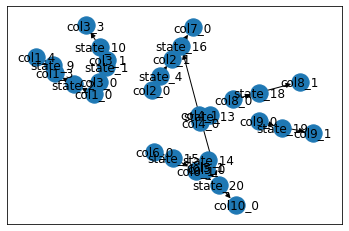

In [226]:
nx.draw_networkx(mg)

In [80]:
sink_nodes = [node for node, outdegree in dict(mg.out_degree(mg.nodes())).items() if outdegree == 0]
source_nodes = [node for node, indegree in dict(mg.in_degree(mg.nodes())).items() if indegree == 0]

In [81]:
sink_nodes,source_nodes

(['col23_0',
  'col22_0',
  'col20_0',
  'col19_5',
  'col3_3',
  'col18_4',
  'col17_0',
  'col26_0',
  'col2_1',
  'col6_1',
  'col7_1',
  'col9_1',
  'col10_1',
  'col11_1',
  'col13_1',
  'col14_1',
  'col15_1',
  'col_removed_0',
  'col12_1'],
 ['col22_1',
  'col1_0',
  'col3_0',
  'col17_1',
  'col5_0',
  'col8_2',
  'col17_3',
  'col2_0',
  'col6_0',
  'col7_0',
  'col9_0',
  'col10_0',
  'col11_0',
  'col13_0',
  'col14_0',
  'col15_0',
  'col4_0',
  'col12_0'])

In [82]:
recipes_par = []
for x in [(source, sink) for sink in sink_nodes for source in source_nodes]:
    #print(x)
    for path in nx.all_simple_paths(mg, source=x[0], target=x[1]):
        print(path[0])
        path = list(filter(lambda x:x.startswith("state"),path))
        print(path)
        recipes_par.append(list(filter(lambda x:x!=None,[json.loads(state_cmd[state_cmd.state_id==orpe.get_state_to_step(int(yy.split("_")[-1])-1)].detail.values[0])["operation"] for yy in path])))
#recipes_par

col22_1
['state_33']
col1_0
['state_1', 'state_31']
col3_0
['state_3', 'state_27']
col3_0
['state_3', 'state_27', 'state_41', 'state_50', 'state_51', 'state_52']
col3_0
['state_3', 'state_52']
col3_0
['state_3', 'state_27', 'state_41', 'state_50', 'state_51', 'state_52']
col3_0
['state_3', 'state_52']
col17_1
['state_22', 'state_23']
col5_0
['state_5', 'state_18', 'state_19', 'state_20']
col8_2
['state_59']
col17_3
['state_59']
col2_0
['state_9']
col6_0
['state_10']
col7_0
['state_11']
col9_0
['state_12']
col10_0
['state_13']
col11_0
['state_14']
col13_0
['state_15']
col14_0
['state_16']
col15_0
['state_17']
col4_0
['state_28']
col12_0
['state_29']


In [83]:
import jellyfish

jellyfish.levenshtein_distance('abcbab','bcab'),jellyfish.jaro_distance('abcbab','bcab'),jellyfish.hamming_distance('abcbab','bcab'),jellyfish.jaro_similarity('abcbab','bcab')

(2, 0.8055555555555555, 5, 0.8055555555555555)

In [84]:
dir(jellyfish)

['__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '__warningregistry__',
 'cjellyfish',
 'damerau_levenshtein_distance',
 'hamming_distance',
 'jaro_distance',
 'jaro_similarity',
 'jaro_winkler',
 'jaro_winkler_similarity',
 'levenshtein_distance',
 'library',
 'match_rating_codex',
 'match_rating_comparison',
 'metaphone',
 'nysiis',
 'porter_stem',
 'soundex',
 'warnings']

In [85]:
list(filter(lambda x:x[-2:]=="_0",list(mg.nodes)))

['col23_0',
 'col1_0',
 'col22_0',
 'col3_0',
 'col20_0',
 'col19_0',
 'col18_0',
 'col5_0',
 'col16_0',
 'col17_0',
 'col26_0',
 'col2_0',
 'col6_0',
 'col7_0',
 'col9_0',
 'col10_0',
 'col11_0',
 'col13_0',
 'col14_0',
 'col15_0',
 'col4_0',
 'col_removed_0',
 'col12_0']

In [86]:
list(mg.nodes)

['col22_1',
 'state_33',
 'col23_0',
 'col1_0',
 'state_1',
 'col1_2',
 'state_31',
 'col22_0',
 'col3_0',
 'state_3',
 'col3_2',
 'state_27',
 'col20_0',
 'col19_0',
 'state_41',
 'col19_2',
 'state_50',
 'col19_3',
 'state_51',
 'col19_4',
 'state_52',
 'col19_5',
 'col3_3',
 'col17_1',
 'state_22',
 'col18_0',
 'state_23',
 'col18_4',
 'col5_0',
 'state_5',
 'col5_2',
 'state_18',
 'col16_0',
 'state_19',
 'col16_1',
 'state_20',
 'col17_0',
 'col8_2',
 'state_59',
 'col17_3',
 'col26_0',
 'col2_0',
 'state_9',
 'col2_1',
 'col6_0',
 'state_10',
 'col6_1',
 'col7_0',
 'state_11',
 'col7_1',
 'col9_0',
 'state_12',
 'col9_1',
 'col10_0',
 'state_13',
 'col10_1',
 'col11_0',
 'state_14',
 'col11_1',
 'col13_0',
 'state_15',
 'col13_1',
 'col14_0',
 'state_16',
 'col14_1',
 'col15_0',
 'state_17',
 'col15_1',
 'col4_0',
 'state_28',
 'col_removed_0',
 'col12_0',
 'state_29',
 'col12_1']

In [270]:
detail_parallel

[[(('state_32',
    'core/column-addition',
    'create_new_column',
    ['col12_1'],
    ['col20_0']),
   None,
   []),
  (('state_33', 'core/text-transform', 'to_date', ['col20_0'], ['col20_1']),
   None,
   [])],
 [(('state_46',
    'core/text-transform',
    'remove_char',
    ['col9_0', 'col12_1'],
    ['col9_1']),
   None,
   [])],
 [(('state_4', 'core/text-transform', 'to_date', ['col12_0'], ['col12_1']),
   None,
   [])],
 [(('state_5', 'core/mass-edit', 'clustering', ['col1_0'], ['col1_1']),
   ['col1_4'],
   [('state_6', 'core/mass-edit', 'clustering', ['col1_1'], ['col1_2']),
    ('state_7', 'core/mass-edit', 'clustering', ['col1_2'], ['col1_3']),
    ('state_8', 'core/mass-edit', 'clustering', ['col1_3'], ['col1_4'])])],
 [(('state_9', 'core/text-transform', 'upper_case', ['col2_0'], ['col2_1']),
   None,
   []),
  (('state_69', 'core/text-transform', 'remove_char', ['col2_1'], ['col2_2']),
   ['col2_5'],
   [('state_78', 'core/text-transform', 'remove_char', ['col2_2'], ['

In [247]:
bigram_count = {}
#for x in detail_parallel:
yy = [y[2] for y in detail_singular]
for y in ngrams(yy,1):
    try:
        bigram_count[y]
    except:
        bigram_count[y] = 0
    bigram_count[y]+=1


In [248]:
yy

['core/text-transform',
 'core/text-transform',
 'core/text-transform',
 'core/text-transform',
 'core/text-transform',
 'core/text-transform',
 'core/text-transform',
 'core/text-transform',
 'core/text-transform',
 'core/mass-edit',
 'core/mass-edit',
 'core/mass-edit',
 'core/mass-edit',
 'core/mass-edit',
 'core/mass-edit',
 'core/column-split',
 'core/column-split',
 'core/column-rename',
 'core/column-rename',
 'core/column-rename',
 'core/column-rename',
 'core/column-rename',
 'core/column-rename',
 'core/column-addition']

In [249]:
pd.DataFrame(bigram_count.items())

,0,1
0,"(core/text-transform,)",9
1,"(core/mass-edit,)",6
2,"(core/column-split,)",2
3,"(core/column-rename,)",6
4,"(core/column-addition,)",1


In [471]:
pd.DataFrame(bigram_count.items())

,0,1
0,"(to_number,)",3
1,"(to_date,)",2
2,"(clustering,)",46
3,"(upper_case,)",5
4,"(lower_case,)",1
5,"(remove_column,)",4
6,"(create_new_column,)",2
7,"(standardize_format,)",1
8,"(remove_char,)",21
9,"(titlecase,)",1


In [472]:
trigram_count = {}
for x in detail_parallel:
    yy = [y[0][2] for y in x]
    for y in ngrams(yy,1):
        try:
            trigram_count[y]
        except:
            trigram_count[y] = 0
        trigram_count[y]+=1


In [473]:
trigram_count

{('to_date',): 2,
 ('create_new_column',): 2,
 ('clustering',): 10,
 ('remove_char',): 9,
 ('upper_case',): 5,
 ('titlecase',): 1}

In [284]:
fourgram_count = {}
for x in detail_parallel:
    yy = [y[0][2] for y in x]
    for y in ngrams(yy,4):
        try:
            fourgram_count[y]
        except:
            fourgram_count[y] = 0
        fourgram_count[y]+=1


In [285]:
fourgram_count

{('create_new_column', 'remove_char', 'clustering', 'remove_char'): 1,
 ('remove_char', 'clustering', 'remove_char', 'clustering'): 1,
 ('clustering', 'remove_char', 'clustering', 'remove_char'): 1,
 ('upper_case', 'remove_char', 'clustering', 'remove_char'): 1}

In [140]:
set(all_parallel_test[9][1]) - set(all_parallel_test[10][1]),set(all_parallel_test[10][1]) - set(all_parallel_test[9][1])

({'col5_4', 'col_removed_3'},
 {'col21_0',
  'col21_1',
  'col21_10',
  'col21_11',
  'col21_12',
  'col21_2',
  'col21_3',
  'col21_4',
  'col21_5',
  'col21_6',
  'col21_7',
  'col21_8',
  'col21_9'})

In [124]:
possible_set = {}
for i,x in enumerate(all_parallel_test[:-1]):
    for j,y in enumerate(all_parallel_test[i+1:]):
        temp_intersect = set(x[0]).intersection(y[0])
        print(i,j+i+1,temp_intersect)
        for xx in temp_intersect:
            try:
                possible_set[xx]
            except:
                possible_set[xx] = set()
            possible_set[xx].add(i)
            possible_set[xx].add(j+i+1)
                         
class TraceTicker:
    ticker = -1
    def __init__(self,path,possible_set,id):
        self.path = path
        #print(self.path)
        self.len_path = len(path)
        self.possible_set = possible_set
        self.id = id

    def is_end_ticker(self):
        #print(self.len_path, self.ticker)
        if self.len_path-1 == self.ticker:
            return True
        return False
    
    def next_pos_ticker(self):
        try:
            self.possible_set[self.path[self.ticker+1]].remove(self.id)
            return False
        except:
            pass

        return self.path[self.ticker+1]

    def move_up_ticker(self):
        is_pass = False
        #print(self.is_end_ticker())
        if (not self.is_end_ticker()):
            if not self.next_pos_ticker():
                return None

        try:
            is_pass = len(self.possible_set[self.path[self.ticker+1]]) == 0            
        except:
            #if no lock
            is_pass = True            

        #print(is_pass,self.is_end_ticker)

        if (not self.is_end_ticker()) and is_pass:
            self.ticker+=1
            return self.path[self.ticker]

ticker = [TraceTicker(x[0],possible_set,id) for id,x in  enumerate(all_parallel_test)]
# check end condition
end_condition = np.sum([x.is_end_ticker() for x in ticker])


trace_ticker = set()

combined_recipe = []


while not end_condition:
    for id,x in enumerate(ticker):
        xx = x.move_up_ticker()
        #print(xx)
        if xx != None:
            if xx not in trace_ticker:
                trace_ticker.add(xx)
                #print(id,xx)
                combined_recipe.append(xx)
    end_condition = np.sum([x.is_end_ticker() for x in ticker]) == len(ticker)




0 1 set()
0 2 set()
0 3 set()
0 4 set()
0 5 set()
0 6 set()
0 7 set()
0 8 set()
0 9 set()
0 10 set()
0 11 set()
0 12 set()
0 13 set()
0 14 set()
0 15 set()
0 16 set()
0 17 set()
1 2 set()
1 3 set()
1 4 set()
1 5 set()
1 6 set()
1 7 set()
1 8 set()
1 9 set()
1 10 set()
1 11 set()
1 12 set()
1 13 set()
1 14 set()
1 15 set()
1 16 set()
1 17 set()
2 3 set()
2 4 set()
2 5 set()
2 6 set()
2 7 set()
2 8 set()
2 9 set()
2 10 set()
2 11 set()
2 12 set()
2 13 set()
2 14 set()
2 15 set()
2 16 set()
2 17 set()
3 4 {'state_4'}
3 5 set()
3 6 set()
3 7 set()
3 8 set()
3 9 set()
3 10 set()
3 11 set()
3 12 set()
3 13 set()
3 14 set()
3 15 set()
3 16 set()
3 17 set()
4 5 set()
4 6 set()
4 7 set()
4 8 set()
4 9 set()
4 10 set()
4 11 set()
4 12 set()
4 13 set()
4 14 set()
4 15 set()
4 16 {'state_46'}
4 17 set()
5 6 set()
5 7 set()
5 8 set()
5 9 set()
5 10 set()
5 11 set()
5 12 set()
5 13 set()
5 14 set()
5 15 set()
5 16 set()
5 17 set()
6 7 set()
6 8 set()
6 9 set()
6 10 set()
6 11 set()
6 12 set()
6 13 s

In [109]:
ticker[3].move_up_ticker()

In [126]:
len(combined_recipe)

87

In [59]:
state_cmd = orpe.get_all_state_command()
temp_path_recipe = list(filter(lambda x:x!=None,[json.loads(state_cmd[state_cmd.state_id==orpe.get_state_to_step(int(yy.split("_")[-1])-1)].detail.values[0])["operation"] for yy in combined_recipe]))
temp_path_recipe

[{'op': 'core/text-transform',
  'engineConfig': {'facets': [], 'mode': 'row-based'},
  'columnName': 'id',
  'expression': 'value.toNumber()',
  'onError': 'keep-original',
  'repeat': False,
  'repeatCount': 10,
  'description': 'Text transform on cells in column id using expression value.toNumber()'},
 {'op': 'core/text-transform',
  'engineConfig': {'facets': [], 'mode': 'row-based'},
  'columnName': 'page_count',
  'expression': 'value.toNumber()',
  'onError': 'keep-original',
  'repeat': False,
  'repeatCount': 10,
  'description': 'Text transform on cells in column page_count using expression value.toNumber()'},
 {'op': 'core/text-transform',
  'engineConfig': {'facets': [], 'mode': 'row-based'},
  'columnName': 'dish_count',
  'expression': 'value.toNumber()',
  'onError': 'keep-original',
  'repeat': False,
  'repeatCount': 10,
  'description': 'Text transform on cells in column dish_count using expression value.toNumber()'},
 {'op': 'core/mass-edit',
  'engineConfig': {'face

In [60]:
possible_set

{'state_4': set(),
 'state_46': set(),
 'state_12': set(),
 'state_31': set(),
 'state_30': set()}

In [61]:
all_parallel_test

[(['state_1'], ['col0_0', 'col0_1']),
 (['state_2'], ['col18_0', 'col18_1']),
 (['state_3'], ['col19_0', 'col19_1']),
 (['state_4', 'state_32', 'state_33', 'state_34'],
  ['col12_0', 'col12_1', 'col20_0', 'col20_1', 'col20_2']),
 (['state_4', 'state_46'], ['col12_0', 'col12_1', 'col9_1']),
 (['state_5', 'state_6', 'state_7', 'state_8', 'state_67', 'state_68'],
  ['col1_0', 'col1_1', 'col1_2', 'col1_3', 'col1_4', 'col1_5', 'col1_6']),
 (['state_9',
   'state_69',
   'state_78',
   'state_79',
   'state_80',
   'state_81',
   'state_82',
   'state_83',
   'state_84',
   'state_85',
   'state_86',
   'state_87'],
  ['col2_0',
   'col2_1',
   'col2_2',
   'col2_3',
   'col2_4',
   'col2_5',
   'col2_6',
   'col2_7',
   'col2_8',
   'col2_9',
   'col2_10',
   'col2_11',
   'col2_12']),
 (['state_10',
   'state_15',
   'state_16',
   'state_17',
   'state_18',
   'state_19',
   'state_70'],
  ['col3_0',
   'col3_1',
   'col3_2',
   'col3_3',
   'col3_4',
   'col3_5',
   'col3_6',
   'col3_7'

In [62]:
#all_path = nx.all_simple_paths(parallel_graph, source="col3_0", target="col10_0")
#list(all_path)


In [63]:
#parallel_state(parallel_graph,"col3_0")

In [64]:
state_cmd = orpe.get_all_state_command()

In [65]:
source_nodes = [node for node, indegree in dict(parallel_graph.in_degree(parallel_graph.nodes())).items() if indegree == 0]

for x in source_nodes:
    if x.startswith("col"):
        test = parallel_state(parallel_graph,x)
        print(x,parallel_state(parallel_graph,x)[1])

col0_0 [(['state_1'], ['col0_0', 'col0_1'])]
col18_0 [(['state_2'], ['col18_0', 'col18_1'])]
col19_0 [(['state_3'], ['col19_0', 'col19_1'])]
col12_0 [(['state_4', 'state_32', 'state_33', 'state_34'], ['col12_0', 'col12_1', 'col20_0', 'col20_1', 'col20_2']), (['state_4', 'state_46'], ['col12_0', 'col12_1', 'col9_1'])]
col1_0 [(['state_5', 'state_6', 'state_7', 'state_8', 'state_67', 'state_68'], ['col1_0', 'col1_1', 'col1_2', 'col1_3', 'col1_4', 'col1_5', 'col1_6'])]
col2_0 [(['state_9', 'state_69', 'state_78', 'state_79', 'state_80', 'state_81', 'state_82', 'state_83', 'state_84', 'state_85', 'state_86', 'state_87'], ['col2_0', 'col2_1', 'col2_2', 'col2_3', 'col2_4', 'col2_5', 'col2_6', 'col2_7', 'col2_8', 'col2_9', 'col2_10', 'col2_11', 'col2_12'])]
col3_0 [(['state_10', 'state_15', 'state_16', 'state_17', 'state_18', 'state_19', 'state_70'], ['col3_0', 'col3_1', 'col3_2', 'col3_3', 'col3_4', 'col3_5', 'col3_6', 'col3_7'])]
col4_0 [(['state_11', 'state_23', 'state_24', 'state_25', 'st

In [90]:
atomic_recipe = test[1]
#set(atomic_recipe[1]).intersection(atomic_recipe[1])

NameError: name 'test' is not defined

In [71]:
atomic_recipe

[(['state_56',
   'state_57',
   'state_58',
   'state_59',
   'state_60',
   'state_61',
   'state_62',
   'state_63',
   'state_64',
   'state_65',
   'state_66',
   'state_75'],
  ['col13_0',
   'col13_1',
   'col13_2',
   'col13_3',
   'col13_4',
   'col13_5',
   'col13_6',
   'col13_7',
   'col13_8',
   'col13_9',
   'col13_10',
   'col13_11',
   'col13_12'])]

In [72]:
test

([[{'op': 'core/text-transform',
    'engineConfig': {'facets': [], 'mode': 'row-based'},
    'columnName': 'location',
    'expression': 'grel:value.replace(/\\s+/i," ")',
    'onError': 'keep-original',
    'repeat': False,
    'repeatCount': 10,
    'description': 'Text transform on cells in column location using expression grel:value.replace(/\\s+/i," ")'},
   {'op': 'core/text-transform',
    'engineConfig': {'facets': [], 'mode': 'row-based'},
    'columnName': 'location',
    'expression': 'value.toTitlecase()',
    'onError': 'keep-original',
    'repeat': False,
    'repeatCount': 10,
    'description': 'Text transform on cells in column location using expression value.toTitlecase()'},
   {'op': 'core/mass-edit',
    'engineConfig': {'facets': [], 'mode': 'row-based'},
    'columnName': 'location',
    'expression': 'value',
    'edits': [{'from': ['Norddeutscher Lloyd Bremen',
       'Norddeutscher Lloyd, Bremen',
       'Bremen Norddeutscher Lloyd',
       'Norddeutscher Llo

In [73]:
source_nodes = [node for node, indegree in dict(parallel_graph.in_degree(parallel_graph.nodes())).items() if indegree == 0]
source_nodes

['col0_0',
 'col18_0',
 'col19_0',
 'col12_0',
 'col1_0',
 'col2_0',
 'col3_0',
 'col4_0',
 'col5_0',
 'col7_0',
 'col17_0',
 'col10_0',
 'col11_0',
 'col14_0',
 'col9_0',
 'col13_0']

In [74]:
nx.dfs_successors(parallel_graph,"col3_0")

{'col3_0': ['state_10'],
 'state_10': ['col3_1'],
 'col3_1': ['state_15'],
 'state_15': ['col3_2'],
 'col3_2': ['state_16'],
 'state_16': ['col3_3'],
 'col3_3': ['state_17'],
 'state_17': ['col3_4'],
 'col3_4': ['state_18'],
 'state_18': ['col3_5'],
 'col3_5': ['state_19'],
 'state_19': ['col3_6'],
 'col3_6': ['state_70'],
 'state_70': ['col3_7']}

In [75]:
graph_dict = parallel_graph.nodes(data=True)
graph_dict["state_1"]

{'label': 'Text transform on 17079 cells in column id: value.toNumber()',
 'type': 'state',
 't_id': '1'}

In [76]:
state_graph = nx.DiGraph()
all_path = nx.dfs_successors(parallel_graph,"col3_0")
for key,val in all_path.items():
    if key.startswith("state"):
        try:
            for vv in all_path[key]:
                for jj in all_path[vv]:            
                    state_graph.add_edge(key,jj)
        except:
            pass


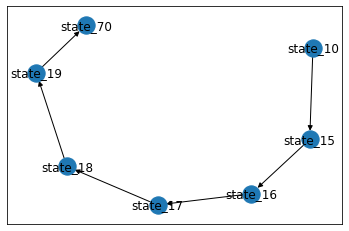

In [77]:
nx.draw_networkx(state_graph)

In [78]:
sink_nodes = [node for node, outdegree in dict(state_graph.out_degree(state_graph.nodes())).items() if outdegree == 0]
source_nodes = [node for node, indegree in dict(state_graph.in_degree(state_graph.nodes())).items() if indegree == 0]


In [422]:
state_graph.nodes

NodeView(('state_10', 'state_15', 'state_16', 'state_17', 'state_18', 'state_19', 'state_70'))

In [80]:
recipes = []
for x in [(source, sink) for sink in sink_nodes for source in source_nodes]:
    for path in nx.all_simple_paths(state_graph, source=x[0], target=x[1]):
        #print(path)
        recipes.append(list(filter(lambda x:x!=None,[json.loads(state_cmd[state_cmd.state_id==orpe.get_state_to_step(int(yy.split("_")[-1])-1)].detail.values[0])["operation"] for yy in path])))
recipes

[[{'op': 'core/text-transform',
   'engineConfig': {'facets': [], 'mode': 'row-based'},
   'columnName': 'event',
   'expression': 'value.toUppercase()',
   'onError': 'keep-original',
   'repeat': False,
   'repeatCount': 10,
   'description': 'Text transform on cells in column event using expression value.toUppercase()'},
  {'op': 'core/mass-edit',
   'engineConfig': {'facets': [], 'mode': 'row-based'},
   'columnName': 'event',
   'expression': 'value',
   'edits': [{'from': ['DINNER',
      '[DINNER]',
      '(DINNER)',
      'DINNER;',
      'DINNER (?)',
      'DINNER(?)',
      '[DINNER?]',
      '(?DINNER?)',
      'DINNER,',
      'DINNER?',
      '[?DINNER?]',
      '[DINNER ?]'],
     'fromBlank': False,
     'fromError': False,
     'to': 'DINNER'},
    {'from': ['LUNCH',
      '[LUNCH]',
      '(?LUNCH?)',
      'LUNCH;',
      '[LUNCH?]',
      '(LUNCH)',
      'LUNCH (?)',
      'LUNCH.'],
     'fromBlank': False,
     'fromError': False,
     'to': 'LUNCH'},
    {'from'

In [81]:
orpe.get_column_at_state(0)

,state,state_id,col_schema_id,col_id,col_name,prev_col_id,prev_col_schema_id
0,0,86,0,0,id,-1,-1
1,0,86,1,1,name,0,-1
2,0,86,2,2,sponsor,1,-1
3,0,86,3,3,event,2,-1
4,0,86,4,4,venue,3,-1
5,0,86,7,7,occasion,6,-1
6,0,86,8,8,notes,7,-1
7,0,86,9,9,call_number,8,-1
8,0,86,14,16,currency_symbol,15,-1
9,0,86,15,17,status,16,-1


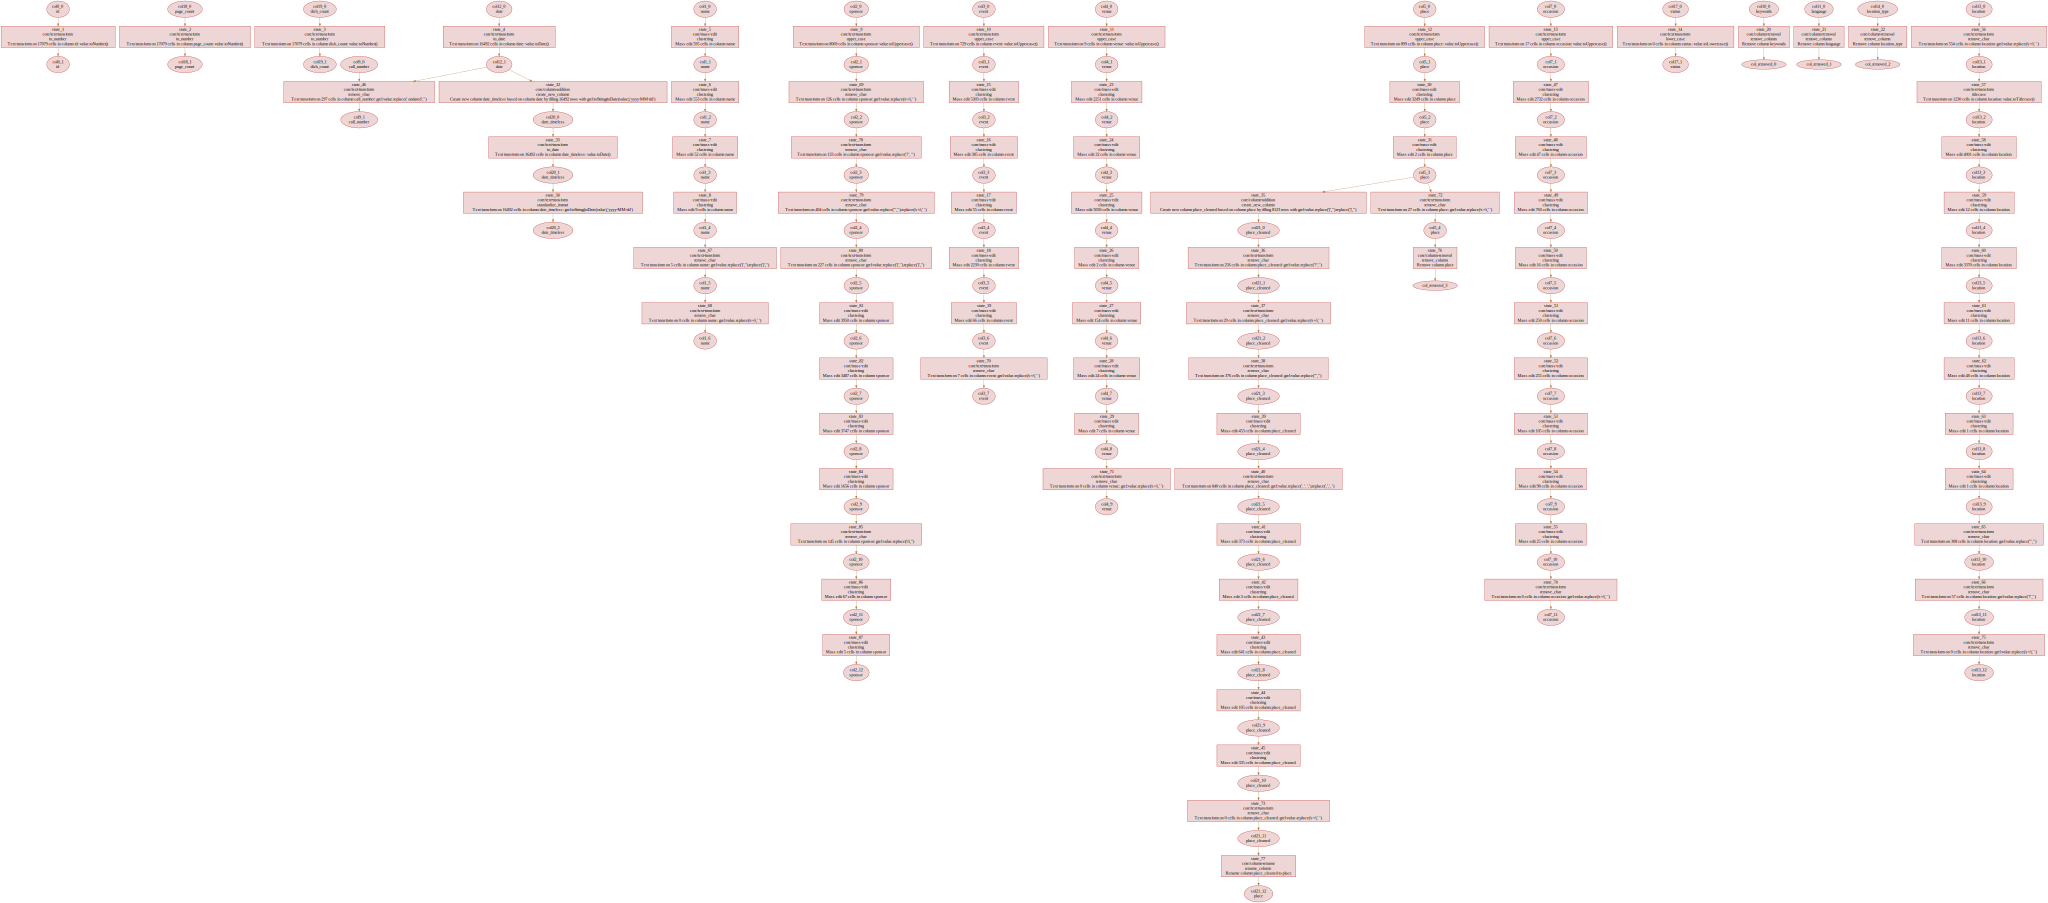

In [115]:
#print(nodes_def+edge_def+"\n}")
from graphviz import Source

temp = nodes_def+edge_def+"\n}"
s = Source(temp)
s

# Reuse recipe

In [28]:
# select recipe based on column
def reuse_recipe(col_id):
    state_dep = orpe.get_state_dependency(orpe.get_column_dependency(col_id).state.tolist())
    print(",".join([str(x) for x in state_dep.dep_state.unique()]))
    state_det = pd.read_sql("select * from state_detail where state_id in ({})".format(",".join([str(orpe.get_step_to_state(x)+1) for x in state_dep.dep_state.unique()])),orpe.conn) #orpe.conn reuse_recipe(3).state.unique()
    state_det = {x.state_id:json.loads(x.detail)["operation"] for x in state_det[["detail","state_id"]].to_records()}
    #print(state_det)
    state_list = []
    state_ids = []
    for x in orpe.get_state_order().sort_values("ord",ascending=False).to_records():
        try:
            #print(state_det[x.state_id])
            state_list.append(state_det[x.state_id])
            state_ids.append(x.state_id)
        except:
            pass
    
    #state_list = list(filter(lambda x: x!=None,[json.loads(x)["operation"] for x in state_det.detail]))
    return state_list,state_ids



In [29]:
import json
test = reuse_recipe(3)

3,4,27,41,42,50,51,52,55


In [30]:
test

([{'op': 'core/text-transform',
   'engineConfig': {'facets': [], 'mode': 'row-based'},
   'columnName': 'host_name',
   'expression': 'value.trim()',
   'onError': 'keep-original',
   'repeat': False,
   'repeatCount': 10,
   'description': 'Text transform on cells in column host_name using expression value.trim()'},
  {'op': 'core/text-transform',
   'engineConfig': {'facets': [], 'mode': 'row-based'},
   'columnName': 'host_name',
   'expression': "value.replace(/\\s+/,' ')",
   'onError': 'keep-original',
   'repeat': False,
   'repeatCount': 10,
   'description': "Text transform on cells in column host_name using expression value.replace(/\\s+/,' ')"},
  {'op': 'core/column-split',
   'engineConfig': {'facets': [], 'mode': 'row-based'},
   'columnName': 'host_name',
   'guessCellType': True,
   'removeOriginalColumn': False,
   'mode': 'separator',
   'separator': '\\s+And\\s+',
   'regex': True,
   'maxColumns': 0,
   'description': 'Split column host_name by separator'},
  {'op'

In [11]:
state_dep = orpe.get_state_dependency(orpe.get_column_dependency(3).state.tolist())
for x in set(state_dep["input_column"]):
    print(x)
    test = reuse_recipe(x)
    print(test)

19
27,41,42,50,51,52
([{'op': 'core/column-split', 'engineConfig': {'facets': [], 'mode': 'row-based'}, 'columnName': 'host_name', 'guessCellType': True, 'removeOriginalColumn': False, 'mode': 'separator', 'separator': '\\s+And\\s+', 'regex': True, 'maxColumns': 0, 'description': 'Split column host_name by separator'}, {'op': 'core/text-transform', 'engineConfig': {'facets': [], 'mode': 'row-based'}, 'columnName': 'host_name 1', 'expression': 'value.trim()', 'onError': 'keep-original', 'repeat': False, 'repeatCount': 10, 'description': 'Text transform on cells in column host_name 1 using expression value.trim()'}, {'op': 'core/text-transform', 'engineConfig': {'facets': [], 'mode': 'row-based'}, 'columnName': 'host_name 1', 'expression': "value.replace(/\\s+/,' ')", 'onError': 'keep-original', 'repeat': False, 'repeatCount': 10, 'description': "Text transform on cells in column host_name 1 using expression value.replace(/\\s+/,' ')"}, {'op': 'core/column-rename', 'oldColumnName': 'host

In [12]:
state_dep

,state,command,dep_state,dep_command,input_column,output_column
0,3,MassCellChange,3,MassCellChange,3,3
1,4,MassCellChange,3,MassCellChange,3,3
2,4,MassCellChange,4,MassCellChange,3,3
3,52,ColumnMoveChange,3,MassCellChange,19,19
4,52,ColumnMoveChange,3,MassCellChange,3,3
5,52,ColumnMoveChange,4,MassCellChange,19,19
6,52,ColumnMoveChange,4,MassCellChange,3,3
7,52,ColumnMoveChange,27,ColumnSplitChange,19,19
8,52,ColumnMoveChange,27,ColumnSplitChange,3,3
9,52,ColumnMoveChange,41,MassCellChange,19,19


In [194]:
test

[{'op': 'core/text-transform',
  'engineConfig': {'facets': [], 'mode': 'row-based'},
  'columnName': 'sponsor',
  'expression': 'value.toUppercase()',
  'onError': 'keep-original',
  'repeat': False,
  'repeatCount': 10,
  'description': 'Text transform on cells in column sponsor using expression value.toUppercase()'},
 {'op': 'core/text-transform',
  'engineConfig': {'facets': [], 'mode': 'row-based'},
  'columnName': 'sponsor',
  'expression': 'grel:value.replace(/\\s+/i," ")',
  'onError': 'keep-original',
  'repeat': False,
  'repeatCount': 10,
  'description': 'Text transform on cells in column sponsor using expression grel:value.replace(/\\s+/i," ")'},
 {'op': 'core/text-transform',
  'engineConfig': {'facets': [], 'mode': 'row-based'},
  'columnName': 'sponsor',
  'expression': "grel:value.replace('?', '')",
  'onError': 'keep-original',
  'repeat': False,
  'repeatCount': 10,
  'description': "Text transform on cells in column sponsor using expression grel:value.replace('?', '

# end of reusable recipe

In [95]:
state_dep = orpe.get_state_dependency(orpe.get_column_dependency(1).state.tolist())
state_dep

,state,command,dep_state,dep_command,input_column,output_column
0,4,MassCellChange,4,MassCellChange,1,1
1,5,MassCellChange,4,MassCellChange,1,1
2,5,MassCellChange,5,MassCellChange,1,1
3,6,MassCellChange,4,MassCellChange,1,1
4,6,MassCellChange,5,MassCellChange,1,1
5,6,MassCellChange,6,MassCellChange,1,1
6,11,MassCellChange,4,MassCellChange,1,1
7,11,MassCellChange,5,MassCellChange,1,1
8,11,MassCellChange,6,MassCellChange,1,1
9,11,MassCellChange,11,MassCellChange,1,1


In [96]:
orpe.get_all_column_dependency()

,state,command,dep_command,input_column,output_column,state_id
0,1,MassCellChange,MassCellChange,0,0,23
1,2,MassCellChange,MassCellChange,0,0,22
2,3,MassCellChange,MassCellChange,0,0,21
3,4,MassCellChange,MassCellChange,1,1,20
4,5,MassCellChange,MassCellChange,1,1,19
5,6,MassCellChange,MassCellChange,1,1,18
6,7,MassCellChange,MassCellChange,2,2,17
7,8,MassCellChange,MassCellChange,2,2,16
8,9,MassCellChange,MassCellChange,2,2,15
9,10,MassCellChange,MassCellChange,0,0,14


In [97]:

nodes_def = """
digraph "[stackcollapse]" {
node [style=filled fillcolor="#f8f8f8"]
"""

edge_def = ""

isinput = set()

col_order = {}

params = set()
process = {}

max_state = orpe.get_number_of_state()

for x in state_col_dep.to_records():
    xx = json.loads(x.detail)

    real_state = max_state.values[0][0]-x.state_id    
    prev_state = max_state.values[0][0]-x.prev_state_id

    if real_state == 0:
        input_name = "tableoriginal"
    else:
        input_name = "table{}".format(real_state) 

    process["state{}".format(prev_state)] = {}
    process["state{}".format(prev_state)]["input"] = input_name
    process["state{}".format(prev_state)]["output"] = "table{}".format(prev_state)
    process["state{}".format(prev_state)]["desc"] = xx["description"]
    try:
        process["state{}".format(prev_state)]["op"] = xx["operation"]["op"]
        process["state{}".format(prev_state)]["operation"] = xx["operation"]
    except:
        pass
    print(xx)


AttributeError: 'record' object has no attribute 'detail'

In [ ]:

nodes_def = """
digraph "[stackcollapse]" {
node [style=filled fillcolor="#f8f8f8"]
"""

edge_def = ""

isinput = set()

for key,val in process.items():
    temp_desc = "{state}\\n".format(state=key)
    try:
        temp_desc += val["op"] +"\\n"
    except:
        pass
    temp_desc += val["desc"]
    nodes_def+="""
        {x} [label="{label}" id="{id}" fontsize=18 shape=box tooltip="{tt}" color="#b20400" fillcolor="#edd6d5"]
    """.format(x=key,label=temp_desc.replace('"',"'"),id=key,tt="")
    if val["input"] not in isinput:
        nodes_def+="""
            {x} [label="{label}" id="{id}" fontsize=18 shape=oval tooltip="" color="#b20400" fillcolor="#edd6d5"]
        """.format(x=val["input"],label=val["input"].replace('"',"'"),id=key,tt="")
        isinput.add(val["input"])
    if val["output"] not in isinput:
        nodes_def+="""
            {x} [label="{label}" id="{id}" fontsize=18 shape=oval tooltip="" color="#b20400" fillcolor="#edd6d5"]
        """.format(x=val["output"],label=val["output"].replace('"',"'"),id=key,tt="")
        isinput.add(val["output"])
    edge_def+="""
        {input} -> {output} [label="{data}" weight=14 color="#b26e37" tooltip="" labeltooltip=""]    
    """.format(input=val["input"],output=key,data="")
    edge_def+="""
        {input} -> {output} [label="{data}" weight=14 color="#b26e37" tooltip="" labeltooltip=""]    
    """.format(input=key,output=val["output"],data="")

In [98]:
import json

linear_recipe = orpe.get_linear_recipe()

params = set()
process = {}

max_state = orpe.get_number_of_state()

for x in linear_recipe.to_records():
    xx = json.loads(x.detail)

    if x.prev_state_id == -1:
        input_name = "table-original"
    else:
        input_name = "table-{}".format(x.prev_state_id) 

    process["state-{}".format(x.state_id)] = {}
    process["state-{}".format(x.state_id)]["input"] = input_name
    process["state-{}".format(x.state_id)]["output"] = "table-{}".format(x.state_id)
    process["state-{}".format(x.state_id)]["desc"] = xx["description"]
    try:
        process["state-{}".format(x.state_id)]["op"] = xx["operation"]["op"]
        process["state-{}".format(x.state_id)]["operation"] = xx["operation"]
    except:
        pass
    print(xx)

    

{'id': 1641783716150, 'description': 'Create new column Archived Delay based on column Entry Year by filling 6 rows with grel:value - cells["Date"].value', 'operation': {'op': 'core/column-addition', 'engineConfig': {'facets': [], 'mode': 'row-based'}, 'baseColumnName': 'Entry Year', 'expression': 'grel:value - cells["Date"].value', 'onError': 'set-to-blank', 'newColumnName': 'Archived Delay', 'columnInsertIndex': 7, 'description': 'Create column Archived Delay at index 7 based on column Entry Year using expression grel:value - cells["Date"].value'}, 'time': '2022-01-10T03:00:30Z'}
{'id': 1641784024886, 'description': 'Rename column Entrance Date 3 to Entry Day', 'operation': {'op': 'core/column-rename', 'oldColumnName': 'Entrance Date 3', 'newColumnName': 'Entry Day', 'description': 'Rename column Entrance Date 3 to Entry Day'}, 'time': '2022-01-10T02:59:09Z'}
{'id': 1641783722911, 'description': 'Rename column Entrance Date 2 to Entry Month', 'operation': {'op': 'core/column-rename',

In [99]:
process

{'state-0': {'input': 'table-original',
  'output': 'table-0',
  'desc': 'Create new column Archived Delay based on column Entry Year by filling 6 rows with grel:value - cells["Date"].value',
  'op': 'core/column-addition',
  'operation': {'op': 'core/column-addition',
   'engineConfig': {'facets': [], 'mode': 'row-based'},
   'baseColumnName': 'Entry Year',
   'expression': 'grel:value - cells["Date"].value',
   'onError': 'set-to-blank',
   'newColumnName': 'Archived Delay',
   'columnInsertIndex': 7,
   'description': 'Create column Archived Delay at index 7 based on column Entry Year using expression grel:value - cells["Date"].value'}},
 'state-1': {'input': 'table-0',
  'output': 'table-1',
  'desc': 'Rename column Entrance Date 3 to Entry Day',
  'op': 'core/column-rename',
  'operation': {'op': 'core/column-rename',
   'oldColumnName': 'Entrance Date 3',
   'newColumnName': 'Entry Day',
   'description': 'Rename column Entrance Date 3 to Entry Day'}},
 'state-2': {'input': 'tabl

In [100]:
"""
#@begin Linear_OR #@desc Linear OpenRefine Workflow
#@param col-name:\nevent
#@param GRELEXPRESSION:\ngrel:cells.year.value+'-'+cells.month.value+'-'+cells.day.value
#@param newColumnName:\nday
#@param separator:\n"-"
#@param col-name:\ndate
#@param oldColumnName:\ndate_2
#@param col-name:\nyear
#@param InsertPosition:\n13
#@param oldColumnName:\ndate_3
#@param newColumnName:\nyear
#@param newColumnName:\nmonth
#@param newColumnName:\nrepaired_date
#@param EXPRESSION:\nvalue.toNumber()
#@param EXPRESSION:\nvalue.toUppercase()
#@param removeOriginalColumn:\nTrue
#@param col-name:\ndish_count
#@param oldColumnName:\ndate_1
#@in table0
#@out table8
"""

'\n#@begin Linear_OR #@desc Linear OpenRefine Workflow\n#@param col-name:\nevent\n#@param GRELEXPRESSION:\ngrel:cells.year.value+\'-\'+cells.month.value+\'-\'+cells.day.value\n#@param newColumnName:\nday\n#@param separator:\n"-"\n#@param col-name:\ndate\n#@param oldColumnName:\ndate_2\n#@param col-name:\nyear\n#@param InsertPosition:\n13\n#@param oldColumnName:\ndate_3\n#@param newColumnName:\nyear\n#@param newColumnName:\nmonth\n#@param newColumnName:\nrepaired_date\n#@param EXPRESSION:\nvalue.toNumber()\n#@param EXPRESSION:\nvalue.toUppercase()\n#@param removeOriginalColumn:\nTrue\n#@param col-name:\ndish_count\n#@param oldColumnName:\ndate_1\n#@in table0\n#@out table8\n'

In [101]:
# visualize linear workflow

output_trace = []
for i,x in enumerate(dep_state[1:]):
    dep_x = all_dep[all_dep.state==x]
    #print(dep_x)
    for y in dep_x[["input_column","output_column"]].to_records():
        xx_input = xx_hist[y.input_column]
        xx_output = xx_hist[y.output_column]
        #print(dep_state[i-1],x)
        #print("input",xx_input[xx_input.state==dep_state[(i+1)-1]])
        #print("output",xx_output[xx_output.state==x])
        output_trace.append((dep_state[(i+1)-1],x,y.input_column,y.output_column,xx_input[xx_input.state==dep_state[(i+1)-1]],xx_output[xx_output.state==x]))
    #print(dep_x)

from graphviz import Source
temp = """
digraph {
rankdir=TB;
node [ shape=record ];
splines="line";
"""
s_coll=""
s_port=""
is_processed = []

s_ah = {}
for s in output_trace:
    try:
        s_ah[s[0]]
    except:
        s_ah[s[0]] = []
    s_ah[s[0]].append(s)
    if s[0]>0:
        try:
            s_ah[s[0]-1]
        except:
            s_ah[s[0]-1] = []
        s_ah[s[0]-1].append(s)

        
#print(s_ah)

s0_s1_rel = []

for s in output_trace:
    s0 = s[0]
    s1 = s[1]
    row_logic_s0 = self.get_row_at_state_order(s0)
    row_logic_s1 = self.get_row_at_state_order(s1)
    
    s0_ex_col = False
    s1_ex_col =False

    if col in self.get_col_at_state_order(s0).col_id.values:
        s0_ex_col = True
    
    if col in self.get_col_at_state_order(s1).col_id.values:
        s1_ex_col = True

    if s0 not in is_processed:
        col_port = []
        for x in self.get_col_at_state_order(s0).to_records():
            is_ss = False
            for ss in s_ah[s0]:
                if (x.col_id==col):
                    xx_col = xx_hist[col]
                    #print(xx_col)
                    #xx_col = xx_col[xx_col.state_id==self.get_state_to_step(ss[0])]
                    xx_col = xx_col[xx_col.state==s0]
                    #print(xx_col)
                    xx = "{{<port{col_id}i>{col_name}|row:{row}|<port{col_id}o>{value}}}".format(col_id=x.col_id,col_name=x.col_name,value=xx_col.value_text.values[0],row=row_logic_s1[row_logic_s1.row_id==row].level.values[0])
                    is_ss = True
                elif (x.col_id==ss[4].col_id.values[0]):
                    xx = "{{<port{col_id}i>{col_name}|row:{row}|<port{col_id}o>{value}}}".format(col_id=x.col_id,col_name=x.col_name,value=ss[4].value_text.values[0],row=row_logic_s0[row_logic_s0.row_id==row].level.values[0])
                    #xx = "{{<port{col_id}>{col_name}|row:{row}|<port{col_id}>{value}}}".format(col_id=x.col_id,col_name=x.col_name,value=ss[4].value_text.values[0],row=row_logic_s0.iloc[row].row_id)
                    is_ss = True

            #print(x.col_id)

            if not is_ss:
                #xx = "{{<port{col_id}>{col_name}}}".format(col_id=x.col_id,col_name=x.col_name)
                xx = "{{<port{}i>{}|<port{}o>}}".format(x.col_id,x.col_name,x.col_id)
                #xx = "<port{}>{}\n{}".format(x.col_id,x.col_name,s[4].value_text.values[0])
            col_port.append(xx)

        s_coll+="""
        subgraph cluster_{step} {{
            label="step {step}";

            struct{s_num}[
                label = "{s_label}";
            ];
        }}
        """.format(step=s[0],s_num=s0,s_label="|".join(col_port))
        is_processed.append(s0)

    if s1 not in is_processed:
        col_port = []
        for x in self.get_col_at_state_order(s1).to_records():
            is_ss = False
            for ss in s_ah[s0]:
                if (x.col_id==col):
                    xx_col = xx_hist[col]
                    #xx_col = xx_col[xx_col.state_id==self.get_state_to_step(ss[0])]
                    xx_col = xx_col[xx_col.state==s1]
                    #print(xx_col)
                    xx = "{{<port{col_id}i>{col_name}|row:{row}|<port{col_id}o>{value}}}".format(col_id=x.col_id,col_name=x.col_name,value=xx_col.value_text.values[0],row=row_logic_s1[row_logic_s1.row_id==row].level.values[0])
                    is_ss = True
                elif (x.col_id==ss[5].col_id.values[0]):
                    #xx = "{{<port{col_id}>{col_name}|row:{row}|<port{col_id}>{value}}}".format(col_id=x.col_id,col_name=x.col_name,value=ss[5].value_text.values[0],row=row_logic_s1.iloc[row].row_id)                                         
                    xx = "{{<port{col_id}i>{col_name}|row:{row}|<port{col_id}o>{value}}}".format(col_id=x.col_id,col_name=x.col_name,value=ss[5].value_text.values[0],row=row_logic_s1[row_logic_s1.row_id==row].level.values[0])
                    is_ss = True
                    
                    #xx = "{{<port{}i>{}|<port{}o>{}}}".format(x.col_id,x.col_name,x.col_id,s[5].value_text.values[0])
                    #xx = "<port{}>{}\n{}".format(x.col_id,x.col_name,s[5].value_text.values[0])

            #print(x.col_id)
            if x.col_id == col:
                s1_ex_col = True

            if not is_ss:
                #xx = "{{<port{col_id}>{col_name}}}".format(col_id=x.col_id,col_name=x.col_name)
                xx = "{{<port{}i>{}|<port{}o>}}".format(x.col_id,x.col_name,x.col_id)                    

            col_port.append(xx)
        '''
        for x in orpe.get_col_at_state_order(s1).to_records():
            xx = "<port{}>".format(x.col_id)+x.col_name
            col_port.append(xx)
        '''
        s_coll+="""
        subgraph cluster_{step} {{
            label="step {step}";
            struct{s_num}[
                label = "{s_label}";
            ];
        }}
        """.format(step=s1,s_num=s1,s_label="|".join(col_port))
        is_processed.append(s1)
    
    
    s_port+="""
    struct{}:port{}o -> struct{}:port{}i [ label="{}" ];
    """.format(s0,s[2],s1,s[3],all_dep[all_dep.state==s1].command.values[0])
    s0_s1_rel.append((s0,s[2],s1,s[3]))

    #print(col,s0_ex_col,s1_ex_col)

    
    if s0_ex_col and s1_ex_col and ((s0,col,s1,col) not in s0_s1_rel):
        #s_port+="""
        #struct{}:port{}o -> struct{}:port{}i [ label="{}" ];
        #""".format(s0,col,s1,col,all_dep[all_dep.state==s1].command.values[0])
        s_port+="""
        struct{}:port{}o -> struct{}:port{}i [ label="{}" ];
        """.format(s0,col,s1,col,"")
        s0_s1_rel.append((s0,col,s1,col))

    #print(s0_s1_rel)

    '''
    s_port+="""
    struct{source} -> struct{target} [
        tailport = port{porto}
        headport = port{porti}
        label = {label}
    ];
    """.format(source=s0,target=s1,porto=s[2],porti=s[3],label=all_dep[all_dep.state==s1].command.values[0])
    '''

    #if s>0:
    #    s_port+="""
    #    struct{}:port1 -> struct{}:port2 [ label="xyz" ];
    #    """.format(s-1,s)

temp+=s_coll
temp+="""
{}
}}
""".format(s_port)
s = Source(temp)
#s.view()
#s

NameError: name 'dep_state' is not defined

In [8]:
#dir(wf),wf.state_viz[0].data_list[0].value

In [9]:
for x in wf.state_viz:
    label = []
    for y in x.data_list:
        if y.is_used:
            xx = "{{<port{col_id}i>{col_name}|row:{row}|<port{col_id}o>{value}}}".format(col_id=y.col_id,col_name=y.col_name,value=y.value,row=y.row)
        else:
            #xx = "{{<port{col_id}i>{col_name}|row:{row}|<port{col_id}o>{value}}}".format(col_id=y.col_id,col_name=y.col_name,value=y.value,row=y.row)
            xx = "{{<port{col_id}>{col_name}}}".format(col_id=y.col_id,col_name=y.col_name,value=y.value,row=y.row)
        label.append(xx)

    s_coll = ""
    s_coll+="""
    subgraph cluster_{step} {{
        label="step {step}";

        struct{s_num}[
            label = "{s_label}";
        ];
    }}
    """.format(step=x.step,s_num=x.step_id,s_label="|".join(label))
    print(s_coll)

    
for x in wf.relation:    
    s_port="""
    struct{}:port{}o -> struct{}:port{}i [ label="{}" ];
    """.format(x.input_step,x.input_col,x.output_col,x.output_col,x.relation)
    print(s_port)

    


    subgraph cluster_0 {
        label="step 0";

        struct9[
            label = "{<port0>Book Title}|{<port1i>Author|row:2|<port1o> P. Kyle Stanford}|{<port2i>Date|row:2|<port2o> 2006}";
        ];
    }
    

    subgraph cluster_2 {
        label="step 2";

        struct7[
            label = "{<port0>TItle}|{<port1i>Author|row:2|<port1o>Stanford, P.K.}|{<port2i>Date|row:2|<port2o> 2006}";
        ];
    }
    

    subgraph cluster_3 {
        label="step 3";

        struct6[
            label = "{<port0>TItle}|{<port1i>Author|row:2|<port1o>Stanford, P.K.}|{<port2i>Date|row:2|<port2o>2006}";
        ];
    }
    

    subgraph cluster_4 {
        label="step 4";

        struct5[
            label = "{<port0>TItle}|{<port1i>Author|row:3|<port1o>Stanford, P.K.}|{<port2i>Date|row:3|<port2o>2006}";
        ];
    }
    

    subgraph cluster_7 {
        label="step 7";

        struct2[
            label = "{<port0>TItle}|{<port2i>Date|row:2|<port2o>2006}|{<port1i>Author|row:

In [21]:
tt = wf.state_viz[0]
tt = tt.data_list[0]
tt.col_name

'Book Title'

In [23]:
from graphviz import Source
temp = """
digraph {
rankdir=TB;
node [ shape=record ];
splines="line";
"""



In [24]:
wf.state_idx

{0: 0, 2: 1, 3: 2, 4: 3, 7: 4}

In [29]:
import os

db_files = []
for x in os.listdir():
    if x.endswith(".db"):
        db_files.append(x)

global orpe,num_state

@interact
def interactive_form(file=db_files):
    global orpe,num_state
    orpe = ProvenanceExplorer(file)
    num_state = orpe.get_number_of_state().num_state.values[0]
    


interactive(children=(Dropdown(description='file', options=('collaborative_demo_t1.openrefine.db', 'ipaw_2021_…

In [30]:
@interact
def interactive_form(col="2",row="2",step="-1"):
    #return df.loc[df[column] > x]
    xx = orpe.get_cell_lineage(int(row),int(col))
    return xx[1]
#orpe.get_changes_each_state(2)

interactive(children=(Text(value='2', description='col'), Text(value='2', description='row'), Text(value='-1',…

In [70]:
xx = orpe.get_cell_lineage(2,1)
xx[1].save("demo.pdf")


'demo.pdf'

In [80]:
xx[1].render("demo")

'pdf/demo.pdf'

In [55]:
@interact
def interactive_form(col="2",row="3",step="4"):
    #return df.loc[df[column] > x]
    xx = orpe.get_cell_lineage(int(row),int(col),int(step))
    return xx[1]
#orpe.get_changes_each_state(2)

interactive(children=(Text(value='2', description='col'), Text(value='3', description='row'), Text(value='4', …

In [44]:
state_dep = orpe.get_state_dependency(7)
dep_state = state_dep.dep_state.unique()
all_dep = orpe.get_all_column_dependency()
print(all_dep)
state_dep = all_dep[all_dep.state.isin(dep_state)]
#print(dep_state)        
#xx = state_dep[state_dep.command!=]state_dep[["input_column","output_column"]].values.flatten()
xx = state_dep[state_dep.command!="ColumnMoveChange"][["input_column","output_column"]].values.flatten()
#xx = state_dep[["input_column","output_column"]].values.flatten()
xx

   state              command          dep_command  input_column  \
0      1   ColumnRenameChange   ColumnRenameChange             0   
1      2           CellChange           CellChange             1   
2      3       MassCellChange       MassCellChange             2   
3      4     RowReorderChange     RowReorderChange             2   
4      7     ColumnMoveChange     ColumnMoveChange             2   
5      7     ColumnMoveChange     ColumnMoveChange             1   
6      8    ColumnSplitChange    ColumnSplitChange             1   
7      8    ColumnSplitChange    ColumnSplitChange             1   
8      9   ColumnRenameChange   ColumnRenameChange             3   
9     10  ColumnRemovalChange  ColumnRemovalChange             4   

   output_column  
0              0  
1              1  
2              2  
3              2  
4              2  
5              1  
6              4  
7              3  
8              3  
9             -2  


array([1, 1, 2, 2, 2, 2])

In [16]:
orpe.get_row_logic_to_idx(52,7561)

1034

In [23]:
orpe.get_step_to_state(52)
ehe = orpe.get_row_at_state_order(52) #.iloc[5].row_id
#ehe[ehe.level==14612]
ehe.iloc[14612]

state             6
state_id         52
row_id            5
prev_row_id    2113
level          7519
Name: 14612, dtype: int64

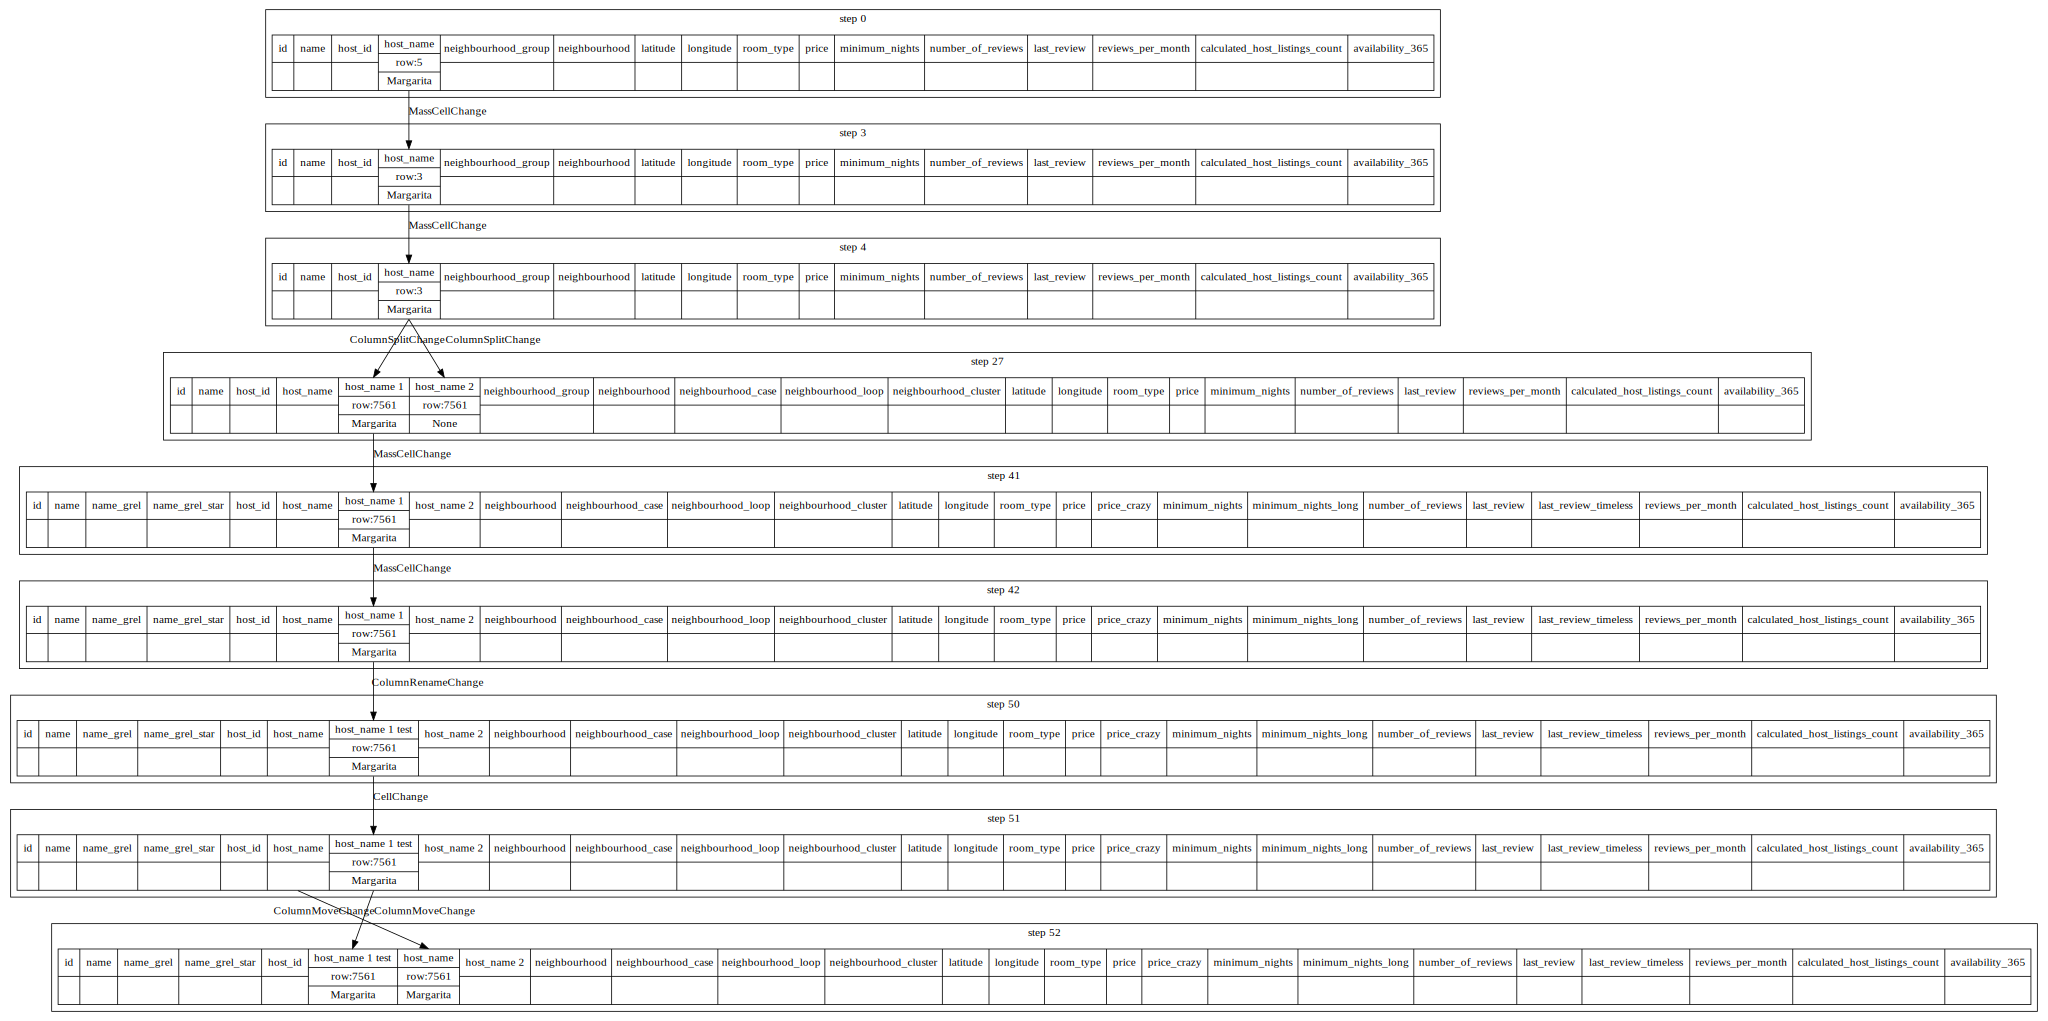

In [471]:
xx[1]

In [464]:
xx[0]

[(0,
  3,
  3,
  3,
     state  state_id  content_id  prev_content_id value_text  row_id  col_id
  0      0        58         138               -1  Margarita       5       3,
     state  state_id  content_id  prev_content_id value_text  row_id  col_id
  3      3        55         138               -1  Margarita       5       3),
 (3,
  4,
  3,
  3,
     state  state_id  content_id  prev_content_id value_text  row_id  col_id
  3      3        55         138               -1  Margarita       5       3,
     state  state_id  content_id  prev_content_id value_text  row_id  col_id
  4      4        54         138               -1  Margarita       5       3),
 (4,
  27,
  3,
  20,
     state  state_id  content_id  prev_content_id value_text  row_id  col_id
  4      4        54         138               -1  Margarita       5       3,
      state  state_id  content_id  prev_content_id value_text  row_id  col_id
  27     27        31         155               -1       None       5      20),
 (4

In [465]:
print(xx[1].source)


        digraph {
        rankdir=TB;
        node [ shape=record ];
        splines="line";
        
                subgraph cluster_0 {
                    label="step 0";

                    struct0[
                        label = "{<port0>id}|{<port1>name}|{<port2>host_id}|{<port3>host_name|row:5|<port3>Margarita}|{<port4>neighbourhood_group}|{<port5>neighbourhood}|{<port6>latitude}|{<port7>longitude}|{<port8>room_type}|{<port9>price}|{<port10>minimum_nights}|{<port11>number_of_reviews}|{<port12>last_review}|{<port13>reviews_per_month}|{<port14>calculated_host_listings_count}|{<port15>availability_365}";
                    ];
                }
                
                subgraph cluster_3 {
                    label="step 3";
                    struct3[
                        label = "{<port0>id}|{<port1>name}|{<port2>host_id}|{<port3>host_name|row:3|<port3>Margarita}|{<port4>neighbourhood_group}|{<port5>neighbourhood}|{<port6>latitude}|{<port7>longitude}|{<port8>room_

In [288]:
pd.DataFrame(xx[0])

,0,1,2,3,4,5
0,0,5,5,5,state state_id content_id prev_content_i...,state state_id content_id prev_content_i...
1,5,6,5,5,state state_id content_id prev_content_i...,state state_id content_id prev_content_i...
2,6,10,6,6,state state_id content_id prev_content_i...,state state_id content_id prev_content_...
3,10,18,5,16,state state_id content_id prev_content_...,state state_id content_id prev_content_...
4,18,52,5,5,state state_id content_id prev_content_...,state state_id content_id prev_content_...
5,18,52,6,6,state state_id content_id prev_content_...,state state_id content_id prev_content_...


In [289]:
xx[0]

[(0,
  5,
  5,
  5,
     state  state_id  content_id  prev_content_id  value_text  row_id  col_id
  0      0        58         140               -1  Bridgeport       5       5,
     state  state_id  content_id  prev_content_id  value_text  row_id  col_id
  5      5        53         140               -1  Bridgeport       5       5),
 (5,
  6,
  5,
  5,
     state  state_id  content_id  prev_content_id  value_text  row_id  col_id
  5      5        53         140               -1  Bridgeport       5       5,
     state  state_id  content_id  prev_content_id  value_text  row_id  col_id
  6      6        52         140               -1  Bridgeport       5       5),
 (6,
  10,
  6,
  6,
     state  state_id  content_id  prev_content_id   value_text  row_id  col_id
  6      6        52      281300              141  41.82704745       5       6,
      state  state_id  content_id  prev_content_id   value_text  row_id  col_id
  10     10        48         141               -1  41.82704745       

In [136]:
#orpe.get_state_dependency(55)
orpe.get_column_dependency(6).state.tolist()
orpe.get_state_dependency(orpe.get_column_dependency(6).state.tolist())


,state,command,dep_state,dep_command,input_column,output_column
0,10,MassCellChange,10,MassCellChange,6,6
1,52,ColumnMoveChange,5,MassCellChange,5,5
2,52,ColumnMoveChange,6,MassCellChange,5,5
3,52,ColumnMoveChange,10,MassCellChange,6,6
4,52,ColumnMoveChange,18,ColumnAdditionChange,5,5
5,52,ColumnMoveChange,28,ColumnRemovalChange,6,6
6,52,ColumnMoveChange,52,ColumnMoveChange,5,5
7,52,ColumnMoveChange,52,ColumnMoveChange,6,6


In [152]:
col=6        
col_state_dep = orpe.get_column_dependency(col).state.tolist()
state_dep = orpe.get_state_dependency(col_state_dep)
state_dep.dep_state.unique()
state_dep[["input_column","output_column"]].values.flatten()

array([6, 6, 5, 5, 5, 5, 6, 6, 5, 5, 6, 6, 5, 5, 6, 6])

In [163]:
xx = state_dep[["input_column","output_column"]].values.flatten()
{x:x for x in xx}

{6: 6, 5: 5}

# Changes at state

In [10]:
@interact
def interactive_form(start_state=range(0,num_state),end_state=range(0,num_state+2)):
    #return df.loc[df[column] > x]
    return orpe.get_changes_each_state(range(start_state,end_state+1))
#orpe.get_changes_each_state(2)

interactive(children=(Dropdown(description='start_state', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 1…

# Column Schema changes at state

In [11]:
@interact
def interactive_form(start_state=range(0,num_state),end_state=range(0,num_state+2)):
    #return df.loc[df[column] > x]
    return orpe.get_col_at_state_order(range(start_state,end_state+1))

#orpe.get_col_at_state_order(range(2,5))

interactive(children=(Dropdown(description='start_state', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 1…

# Row order at state

In [12]:
@interact
def interactive_form(state_id=range(0,num_state+2)):
    #return df.loc[df[column] > x]
    return orpe.get_row_at_state_order(state_id)

#orpe.get_row_at_state_order(5) 

interactive(children=(Dropdown(description='state_id', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, …

# Cell History

In [13]:
@interact
def interactive_form(col="0",row="3"):
    #return df.loc[df[column] > x]
    return orpe.get_cell_history(int(row),int(col))


interactive(children=(Text(value='0', description='col'), Text(value='3', description='row'), Output()), _dom_…

# Snapshot at state

In [14]:
@interact
def interactive_form(state=range(0,num_state+2)):
    #return df.loc[df[column] > x]
    return orpe.get_snapshot_at_state(state)


interactive(children=(Dropdown(description='state', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14,…

# Graphviz

In [15]:
from graphviz import Digraph
# Create Digraph object
dot = Digraph()
dot2 = Digraph()

In [71]:
orpe.get_number_of_state().num_state[0]

58

In [74]:
temp

'\ndigraph {{\n  rankdir=TB;\n  node [ shape=record ];\n\n    struct0 \n        label = "id|name|host_id|host_name|neighbourhood_group|neighbourhood|latitude|longitude|room_type|price|minimum_nights|number_of_reviews|last_review|reviews_per_month|calculated_host_listings_count|availability_365";\n    ];\n    \n    struct1 \n        label = "id|name|host_id|host_name|neighbourhood_group|neighbourhood|latitude|longitude|room_type|price|minimum_nights|number_of_reviews|last_review|reviews_per_month|calculated_host_listings_count|availability_365";\n    ];\n    \n    struct2 \n        label = "id|name|host_id|host_name|neighbourhood_group|neighbourhood|latitude|longitude|room_type|price|minimum_nights|number_of_reviews|last_review|reviews_per_month|calculated_host_listings_count|availability_365";\n    ];\n    \n    struct3 \n        label = "id|name|host_id|host_name|neighbourhood_group|neighbourhood|latitude|longitude|room_type|price|minimum_nights|number_of_reviews|last_review|reviews_p

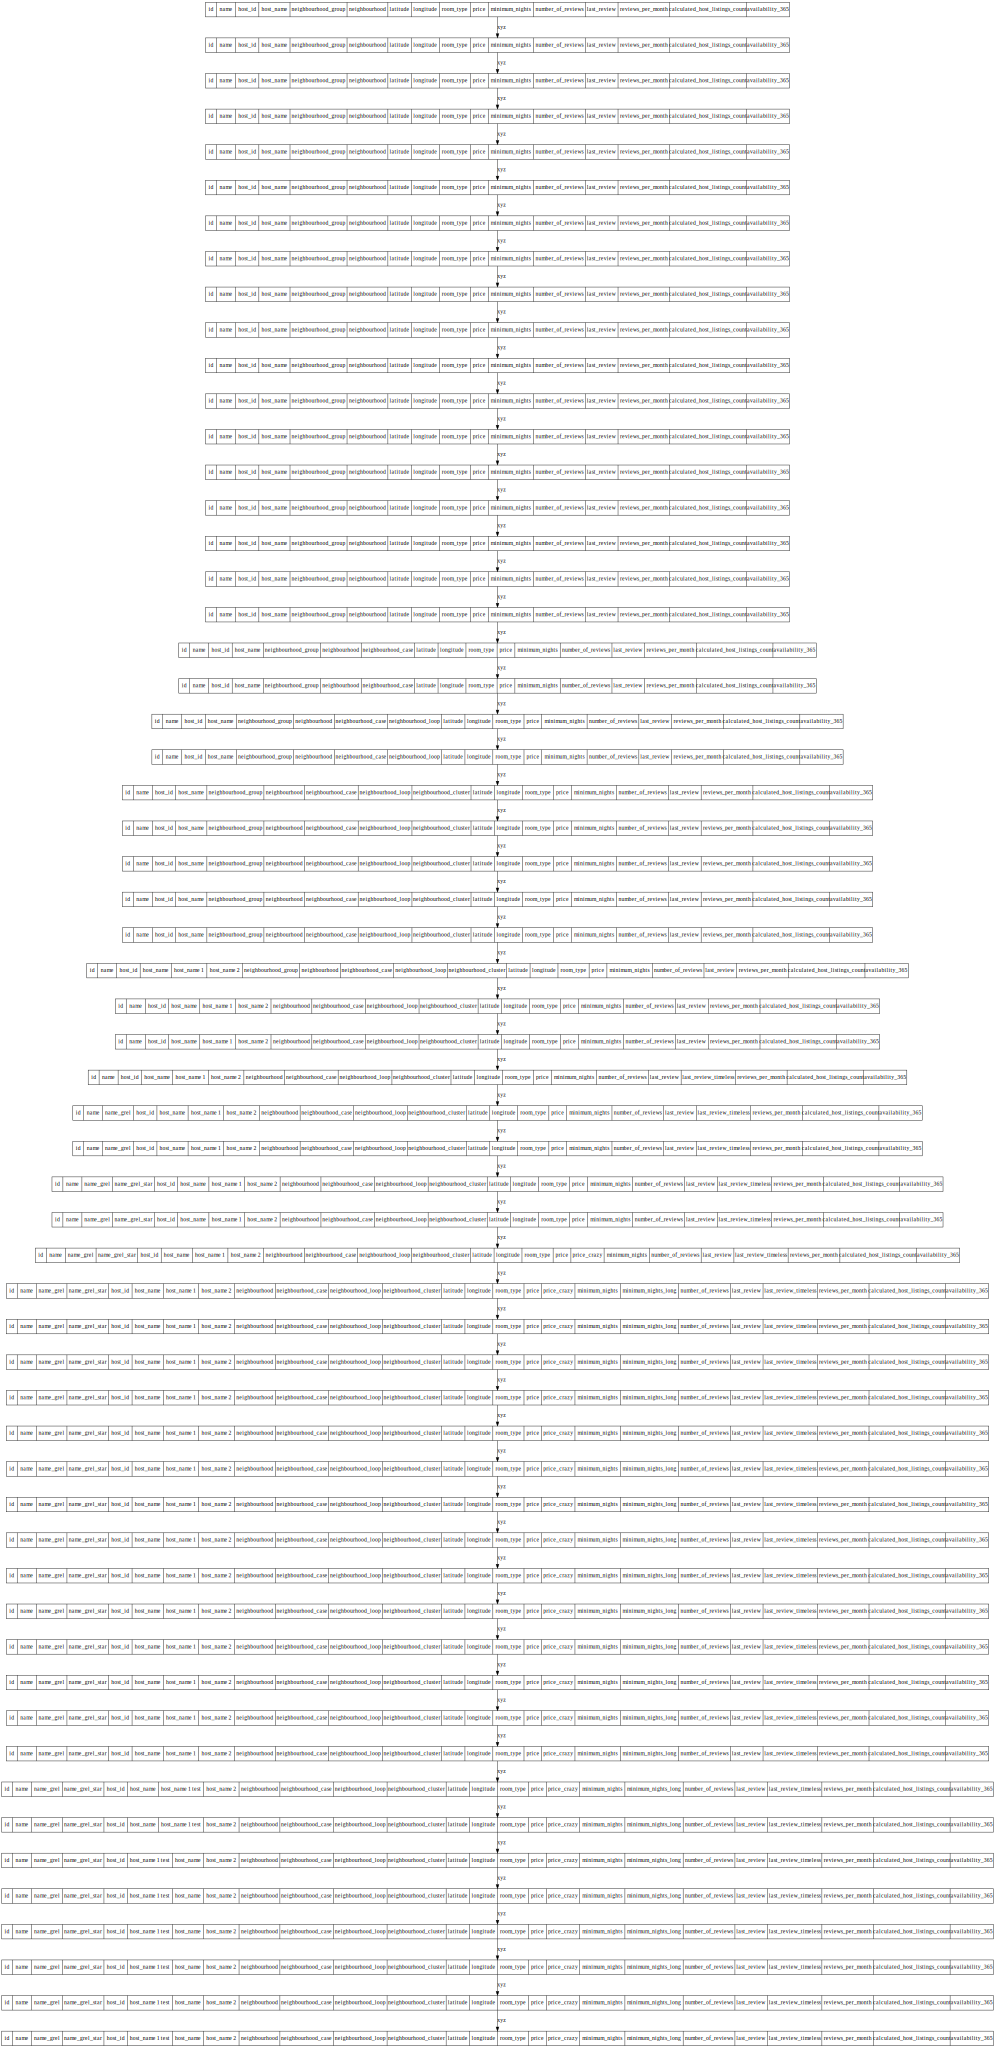

In [92]:
from graphviz import Source
temp = """
digraph {
  rankdir=TB;
  node [ shape=record ];
"""
s_coll=""
s_port=""
for s in range(0,orpe.get_number_of_state().num_state[0]):    
    s_coll+="""
    struct{s_num}[
        label = "{s_label}";
    ];
    """.format(s_num=s,s_label="|".join(orpe.get_col_at_state_order(s).col_name.tolist()))
    if s>0:
        s_port+="""
        struct{}:port1 -> struct{}:port2 [ label="xyz" ];
        """.format(s-1,s)

temp+=s_coll
temp+="""
{}
}}
""".format(s_port)
s = Source(temp)
#s.view()
s

In [ ]:
digraph {
  rankdir=LR;
  node [ shape=record ];

  struct1 [
      label = "a|b|<port1>c";
  ];
  
  struct2 [
      label = "a|{<port2>b1|b2}|c";
  ];
  
  struct1:port1 -> struct2:port2 [ label="xyz" ];
}

In [91]:
"|".join(orpe.get_col_at_state_order(0).col_name.tolist())

'id|name|host_id|host_name|neighbourhood_group|neighbourhood|latitude|longitude|room_type|price|minimum_nights|number_of_reviews|last_review|reviews_per_month|calculated_host_listings_count|availability_365'

In [86]:
print(temp)


digraph {{
  rankdir=TB;
  node [ shape=record ];

    struct0[
        label = "id|name|host_id|host_name|neighbourhood_group|neighbourhood|latitude|longitude|room_type|price|minimum_nights|number_of_reviews|last_review|reviews_per_month|calculated_host_listings_count|availability_365";
    ];
    
    struct1[
        label = "id|name|host_id|host_name|neighbourhood_group|neighbourhood|latitude|longitude|room_type|price|minimum_nights|number_of_reviews|last_review|reviews_per_month|calculated_host_listings_count|availability_365";
    ];
    

        struct1:port1 -> struct0:port2 [ label="xyz" ];
        
}



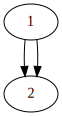

In [30]:
dot.subgraph(dot2)
dot.node('1')
dot.node('2')

# Add edge between 1 and 2
dot.edges(['12'])
dot2.node('1')
dot2.node('2')

# Add edge between 1 and 2
dot2.edges(['12'])
dot
dot2

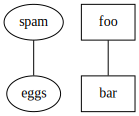

In [36]:
from graphviz import Graph

p = Graph(name='parent')
p.edge('spam', 'eggs')

c = Graph(name='child', node_attr={'shape': 'box'})
c.edge('foo', 'bar')

p.subgraph(c)
p

In [28]:
from graphviz import Source
temp = """
digraph G {

  subgraph cluster_0 {
    style=filled;
    color=lightgrey;
    node [style=filled,color=white];
    a0 -> a1 -> a2 -> a3;
    label = "process #1";
  }

  subgraph cluster_1 {
    node [style=filled];
    b0 -> b1 -> b2 -> b3;
    label = "process #2";
    color=blue
  }
  start -> a0;
  start -> b0;
  a1 -> b3;
  b2 -> a3;
  a3 -> a0;
  a3 -> end;
  b3 -> end;

  start [shape=Mdiamond];
  end [shape=Msquare];
}
"""
s = Source(temp, filename="test.gv", format="png")
s.view()


'test.gv.png'

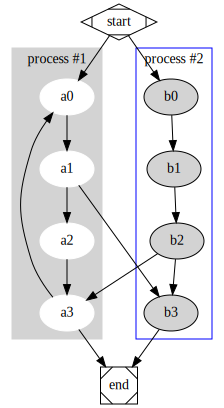

In [29]:
s

In [ ]:
s.

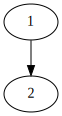

In [15]:
# Add nodes 1 and 2
dot.node('1')
dot.node('2')

# Add edge between 1 and 2
dot.edges(['12'])
dot

In [177]:
orpe.get_col_at_state_order(1)

,state,col_id,col_name,prev_col_id,level
0,1,0,Title,-1,0
1,1,1,Author,0,1
2,1,2,Date,1,2


In [154]:
@interact
def interactive_form(x=range(0,num_state),y=range(0,num_state)):
    #return df.loc[df[column] > x]
    return orpe.get_column_at_state(range(x,y+1))


interactive(children=(Dropdown(description='x', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15,…

In [108]:
tt = orpe.get_snapshot_at_state(0)

In [109]:
tt

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,30041063,(Quiet & Affordable Private BDR near UOC),225773707,LaShun test,None,Woodlawn,41.77712429,-87.59471115,Private room,25,1,0,None,None,1,173
1,29960994,(Feel cozy in chicago),225262670,Karla,None,Edgewater,41.98536071,-87.66898893,Private room,70,2,0,None,None,1,179
2,29946929,(Cozy 2 Bedroom Apartment in the Heart of Chic...,225157895,Frankie,None,Lower West Side,41.85198185,-87.67767597,Entire home/apt,79,1,0,None,None,1,62
3,29940545,(Beautiful 7Br 6200 sf Brick & Steel Custom Ma...,225106605,Neda,None,Bridgeport,41.84452795,-87.6558587,Entire home/apt,300,2,0,None,None,1,355
4,29936021,"(Convenient, Beautiful, Spacious 2Br/2Ba Condo)",225076770,J,None,Mckinley Park,41.8296729,-87.67826309,Entire home/apt,70,1,0,None,None,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7587,10610,(3 Comforts of Cooperative Living),2140,Lois And Ed,None,hyde park,41.79708495,-87.59194894,Private room,35,2,31,2018-07-29T00:00:00Z,0.63,5,179
7588,3907071,(2 A Walk in Hyde Park),2140,Lois And Ed,None,hyde park,41.79554928,-87.59174205,Private room,37,2,45,2018-09-28T00:00:00Z,0.91,5,232
7589,3983057,(4 Cooperative Living in Hyde Park),2140,Lois And Ed,None,hyde park,41.79507237,-87.59332266,Private room,40,2,38,2018-09-16T00:00:00Z,0.88,5,333
7590,3984079,(5 Sabbatical in Hyde Park),2140,Lois And Ed,None,hyde park,41.79718187,-87.59378733,Entire home/apt,150,2,10,2018-07-23T00:00:00Z,0.31,5,55


In [14]:
orpe.get_cell_history(3,2)

,state,state_id,content_id,prev_content_id,value_text,row_id,col_id
0,0,58,288897,83,225106605,3,2
1,1,57,288897,83,225106605,3,2
2,2,56,288897,83,225106605,3,2
3,3,55,288897,83,225106605,3,2
4,4,54,288897,83,225106605,3,2
5,5,53,288897,83,225106605,3,2
6,6,52,288897,83,225106605,3,2
7,7,51,288897,83,225106605,3,2
8,8,50,288897,83,225106605,3,2
9,9,49,83,-1,225106605,3,2


In [4]:
orpe.get_column_at_state(1)

,state,state_id,col_schema_id,col_id,col_name,prev_col_id,prev_col_schema_id
0,1,57,0,0,id,-1,-1
1,1,57,1,1,name,0,-1
2,1,57,2,22,name_grel,1,-1
3,1,57,3,23,name_grel_star,22,-1
4,1,57,9,16,neighbourhood_case,5,-1
5,1,57,10,17,neighbourhood_loop,16,-1
6,1,57,11,26,test_combine,17,-1
7,1,57,14,7,longitude,6,-1
8,1,57,15,8,room_type,7,-1
9,1,57,16,9,price,8,-1


In [6]:
orpe.get_col_at_state_order(0)

,state,col_id,col_name,prev_col_id,level
0,0,0,id,-1,0
1,0,1,name,0,1
2,0,22,name_grel,1,2
3,0,2,host_id,1,2
4,0,23,name_grel_star,22,3
5,0,3,host_name,2,3
6,0,4,neighbourhood_group,3,4
7,0,5,neighbourhood,4,5
8,0,16,neighbourhood_case,5,6
9,0,6,latitude,5,6


In [6]:
orpe.get_col_idx_to_logic(8,1)

1

In [7]:
orpe.get_col_logic_to_idx(8,2)

22

In [3]:
xx = orpe.get_row_at_state(1)
xx

In [13]:
orpe.get_row_at_state_order(0)

,state,state_id,row_id,prev_row_id,level
0,58,0,0,-1,0
1,58,0,1,0,1
2,58,0,2,1,2
3,58,0,3,2,3
4,58,0,4,3,4
...,...,...,...,...,...
7587,58,0,7587,7586,7587
7588,58,0,7588,7587,7588
7589,58,0,7589,7588,7589
7590,58,0,7590,7589,7590


In [175]:
orpe.get_row_logic_to_idx(4,2)

3

In [176]:
orpe.get_row_idx_to_logic(4,3)

2

In [177]:
orpe.get_values_at_state(0)

,state,state_id,content_id,prev_content_id,value_text,row_id,col_id
0,0,9,0,-1,Against Method,0,0
1,0,9,1,-1,"Feyerabend, P.",0,1
2,0,9,3,-1,Feyerabend,0,3
3,0,9,4,-1,None,0,4
4,0,9,5,-1,Changing Order,1,0
5,0,9,6,-1,"Collins, H.M.",1,1
6,0,9,8,-1,Collins,1,3
7,0,9,9,-1,None,1,4
8,0,9,10,-1,Exceeding Our Grasp,2,0
9,0,9,13,-1,Stanford,2,3


In [164]:
xx.row_pos_id.tolist().index(4)

2

In [22]:
list(orpe.cursor.execute("select * from col_each_state where state=8"))
names = list(map(lambda x: x[0], orpe.cursor.description))
names

['state',
 'state_id',
 'col_schema_id',
 'col_id',
 'col_name',
 'prev_col_id',
 'prev_col_schema_id']

In [21]:
xx = orpe.cursor.execute("select * from col_each_state where state=8")

['state',
 'state_id',
 'col_schema_id',
 'col_id',
 'col_name',
 'prev_col_id',
 'prev_col_schema_id']

In [16]:
orpe.get_column_at_state(5)

[(5, 4, 0, 0, 'Title', -1, -1),
 (5, 4, 8, 2, 'Date', 1, 1),
 (5, 4, 9, 1, 'Author', 0, 2)]